# Using Time Series Analysis for Sales and Demand Forecasting

## Introduction  

This project focuses on applying **time series analysis** techniques to forecast sales and demand using historical data. Forecasting plays a critical role in business decision-making, enabling organisations to anticipate future trends, optimise inventory management, and allocate resources effectively.  

Accurate sales and demand forecasts help reduce costs, maximise profitability, and ensure stock availability aligns with customer demand. By combining classical statistical methods, machine learning, and deep learning approaches, this project explores how time series analysis can generate actionable insights for the publishing industry.  

## Business Context  

The dataset used in this project comes from one of the largest continuous book sales tracking services, which collects transactional data at the point of sale from major retailers. This dataset provides highly accurate information on book sales volumes, prices, and formats, and can be used to:  

- Monitor titles against competitors and overall market performance  
- Analyse the impact of pricing and discounting strategies  
- Evaluate marketing campaigns and promotions  
- Track market trends by category, publisher, and format  

Small to medium-sized publishers are particularly interested in forecasting tools that can guide investment decisions in new titles. Producing a book requires significant upfront costs, so understanding which titles have strong long-term sales potential is essential for profitability. Forecasting also helps manage stock levels to avoid overproduction or shortages.  

## Project Objective  

The objective of this project is to build and evaluate forecasting models that can identify sales patterns with seasonal and trend characteristics, providing insights into reordering, restocking, and reprinting decisions.  

The analysis focuses on:  
- Preprocessing and cleaning historical sales data  
- Exploring sales patterns across time horizons  
- Applying classical statistical models (ARIMA, SARIMA)  
- Building machine learning and deep learning models (XGBoost, LSTM)  
- Developing hybrid approaches that combine statistical and deep learning methods  
- Comparing weekly and monthly forecasting approaches  

## Notebook Tasks  

In this notebook, the following steps will be completed:  

1. **Data Preparation**  
   - Import datasets, resample weekly sales, and handle missing values  
   - Convert identifiers to appropriate formats and set date indices  
   - Filter ISBNs and visualise sales patterns  

2. **Exploratory Analysis**  
   - Investigate general sales patterns across different time horizons  
   - Select case study titles (*The Alchemist* and *The Very Hungry Caterpillar*) for deeper analysis  

3. **Classical Forecasting**  
   - Perform decomposition, ACF/PACF analysis, and stationarity checks  
   - Apply Auto ARIMA models to generate forecasts and evaluate residuals  

4. **Machine Learning & Deep Learning Models**  
   - Implement XGBoost with parameter tuning and cross-validation  
   - Build and tune LSTM models for forecasting  
   - Compare results using MAE and MAPE  

5. **Hybrid Models**  
   - Sequential SARIMA + LSTM  
   - Parallel SARIMA + LSTM with weighted averaging  

6. **Monthly Forecasting**  
   - Aggregate weekly sales to monthly data  
   - Train SARIMA and XGBoost models for 8-month predictions  
   - Compare monthly vs. weekly results  

# **Model Files**

Due to issues running this notebook in google colab, the models were generated in a local run. The saved model files generated from my local run can be downloaded here to avoid any reprocessing in google colab.

In [ ]:
# import gdown
# from pathlib import Path

# # Model folder ID.
# folder_id = "17hq5as1_ulsEPyg03ohXau7HjI4tvgXD"

# # Download the folder.
# url = f"https://drive.google.com/drive/folders/{folder_id}"
# gdown.download_folder(url=url, output='models', quiet=False, use_cookies=False)

# **1. Set up Workspace**

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"

# Import core libraries.
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import gdown
import json
import time
import os
import joblib
from pathlib import Path
import pprint

# Import visualisation libraries.
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from matplotlib import animation, rc
import statsmodels.graphics.api as smgraphics
from pandas.plotting import register_matplotlib_converters

# Import statsmodels libraries.
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import scipy libraries.
from scipy import stats
from scipy.stats import boxcox, boxcox_normmax
from scipy.special import boxcox1p, inv_boxcox1p

# Import sktime libraries.
import sktime
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, ForecastingGridSearchCV)
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.base import BaseTransformer

# Import pmdarima libraries.
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import LogEndogTransformer, BoxCoxEndogTransformer

# Import machine learning libraries.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from xgboost import XGBRegressor
import lightgbm as lgb

# Import deep learning libraries.
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
import keras_tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber

# Ensure datetime compatability between pandas and matplotlib.
register_matplotlib_converters()

# Set default figure size for all matplotlib plots.
plt.rcParams["figure.figsize"] = (10, 5)

# Suppress all warnings.
import warnings
warnings.filterwarnings("ignore")

# Set seed.
seed = 42
import random
np.random.seed(seed)
random.seed(seed)

In [ ]:
# File IDs from Google Drive
UK_weekly_data_file_id = "16Hw57l_-Bc2OSHefYg6Sg9UpUuAiezJt"
ISBN_list_data_file_id = "1P7HwOIrJuk1n9JCW81xiNBSP7LUfaW57"

# Construct URLs from file IDs.
UK_weekly_data_url = f"https://drive.google.com/uc?id={UK_weekly_data_file_id}"
ISBN_list_data_url = f"https://drive.google.com/uc?id={ISBN_list_data_file_id}"

# Download the Excel files and name them locally.
gdown.download(UK_weekly_data_url, "UK_weekly_data.xlsx", quiet=False)
gdown.download(ISBN_list_data_url, "ISBN_list_data.xlsx", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16Hw57l_-Bc2OSHefYg6Sg9UpUuAiezJt
To: /Users/laurenbrixey/Documents/Data Science Career Accelerator/Project Submissions/Course 3/topic_project_9.1/UK_weekly_data.xlsx
100%|██████████| 15.7M/15.7M [00:00<00:00, 56.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P7HwOIrJuk1n9JCW81xiNBSP7LUfaW57
To: /Users/laurenbrixey/Documents/Data Science Career Accelerator/Project Submissions/Course 3/topic_project_9.1/ISBN_list_data.xlsx
100%|██████████| 56.0k/56.0k [00:00<00:00, 3.81MB/s]


'ISBN_list_data.xlsx'

In [ ]:
# Import the data.
data_dictionary_UK = pd.read_excel("UK_weekly_data.xlsx", sheet_name=None, engine='openpyxl')
data_dictionary_ISBN = pd.read_excel("ISBN_list_data.xlsx", sheet_name=None, engine='openpyxl')

print('UK_weekly_data:', data_dictionary_UK.keys())
print('ISBN_list_data:', data_dictionary_ISBN.keys())

UK_weekly_data: dict_keys(['F Adult Fiction', 'S Adult Non-Fiction Specialist', 'T Adult Non-Fiction Trade', "Y Children's, YA & Educational"])
ISBN_list_data: dict_keys(['F - Adult Fiction', 'S Adult Non-Fiction Specialist', 'T Adult Non-Fiction Trade', "Y Children's, YA & Educational"])


# **2. Data Cleaning**

In [ ]:
# Create UK_weekly_data dataframe.
df_UK_weekly = pd.concat(
    [df.assign(Category=sheet_name) for sheet_name, df in data_dictionary_UK.items()],
    ignore_index=True
)

df_UK_weekly.head()

ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   

                     Product Class         Category  
0  F1.1 General & Literary Fiction  F Adult Fiction  
1  F1.1 General & Literary Fiction  F Adult Fiction  
2  F1.1 General & Literary Fiction  F Adult Fiction  
3  F1.1 General & Literary Fiction  F Adult Fiction  
4  F1.1 General & Literary Fiction  F Adult Fiction

In [ ]:
# Create ISBN_list_data dataframe.
df_ISBN = pd.concat(
    [df.assign(Category=sheet_name) for sheet_name, df in data_dictionary_ISBN.items()],
    ignore_index=True
)

df_ISBN.head()

In [ ]:
# Standardise the column names.
keep_upper = ['ISBN', 'RRP', 'ASP']

df_UK_weekly.columns = [col if col in keep_upper else col.strip().replace(' ', '_').lower() for col in df_UK_weekly.columns]
df_ISBN.columns = [col if col in keep_upper else col.strip().replace(' ', '_').lower() for col in df_ISBN.columns]

In [ ]:
# Resample the data by week (W), sum the data and fill missing values with zeros.
# Convert 'End Date' to datetime and ISBN to string
df_UK_weekly['end_date'] = pd.to_datetime(df_UK_weekly['end_date'])
df_UK_weekly['ISBN'] = df_UK_weekly['ISBN'].astype(str)
df_ISBN['ISBN'] = df_ISBN['ISBN'].astype(str)

# Select only the relevant columns
df_UK_weekly = df_UK_weekly[['ISBN', 'end_date','title', 'volume']]

# Initialise list to store results.
resampled_dfs = []

# Resample per ISBN
for isbn, group in df_UK_weekly.groupby('ISBN'):
    group = group.set_index('end_date')
    group = group.resample('W').sum()  # sum weekly sales
    group = group.fillna(0)            # fill missing weeks with 0
    group['ISBN'] = isbn               # re-add ISBN
    resampled_dfs.append(group)

# Combine all ISBNs back into one DataFrame
df_UK_weekly = pd.concat(resampled_dfs).reset_index()

# Set end_date as index.
df_UK_weekly.set_index('end_date', inplace=True)

In [ ]:
# View the dataframe.
df_UK_weekly.head()

# **3. Initial Data Investigation**

## **3.1 General Sales Patterns**

In [ ]:
# Filter df_UK_weekly for records with sales data beyond 2024-07-01.
df_UK_weekly_filtered = df_UK_weekly[df_UK_weekly.index > '2024-07-01']

# Get the list of ISBNs that meet this criterion.
ISBN_filtered = df_UK_weekly_filtered['ISBN'].unique()
print('Number of ISBNs:', len(ISBN_filtered))

Number of ISBNs: 61


In [ ]:
# View the filtered ISBNs.
print(ISBN_filtered)

['9780006512134' '9780006514091' '9780006514213' '9780006531203'
 '9780006550433' '9780006647553' '9780007101887' '9780091816971'
 '9780091867775' '9780099244721' '9780099285823' '9780099286387'
 '9780099286578' '9780099422587' '9780099428558' '9780099771517'
 '9780140259506' '9780140275421' '9780140276336' '9780140276619'
 '9780140281293' '9780140285215' '9780140294231' '9780140295962'
 '9780224060875' '9780241003008' '9780261103252' '9780330355667'
 '9780340696767' '9780340766057' '9780340786055' '9780349112763'
 '9780349113609' '9780349114033' '9780440864141' '9780440864554'
 '9780552145053' '9780552145060' '9780552145954' '9780552997034'
 '9780552997348' '9780552998000' '9780552998444' '9780552998482'
 '9780552998727' '9780593048153' '9780719559792' '9780722532935'
 '9780744523232' '9780747268161' '9780749395698' '9780749397548'
 '9780752844299' '9780752846576' '9781841150437' '9781841460307'
 '9781841460406' '9781841461502' '9781841462301' '9781841462400'
 '9781841462509']


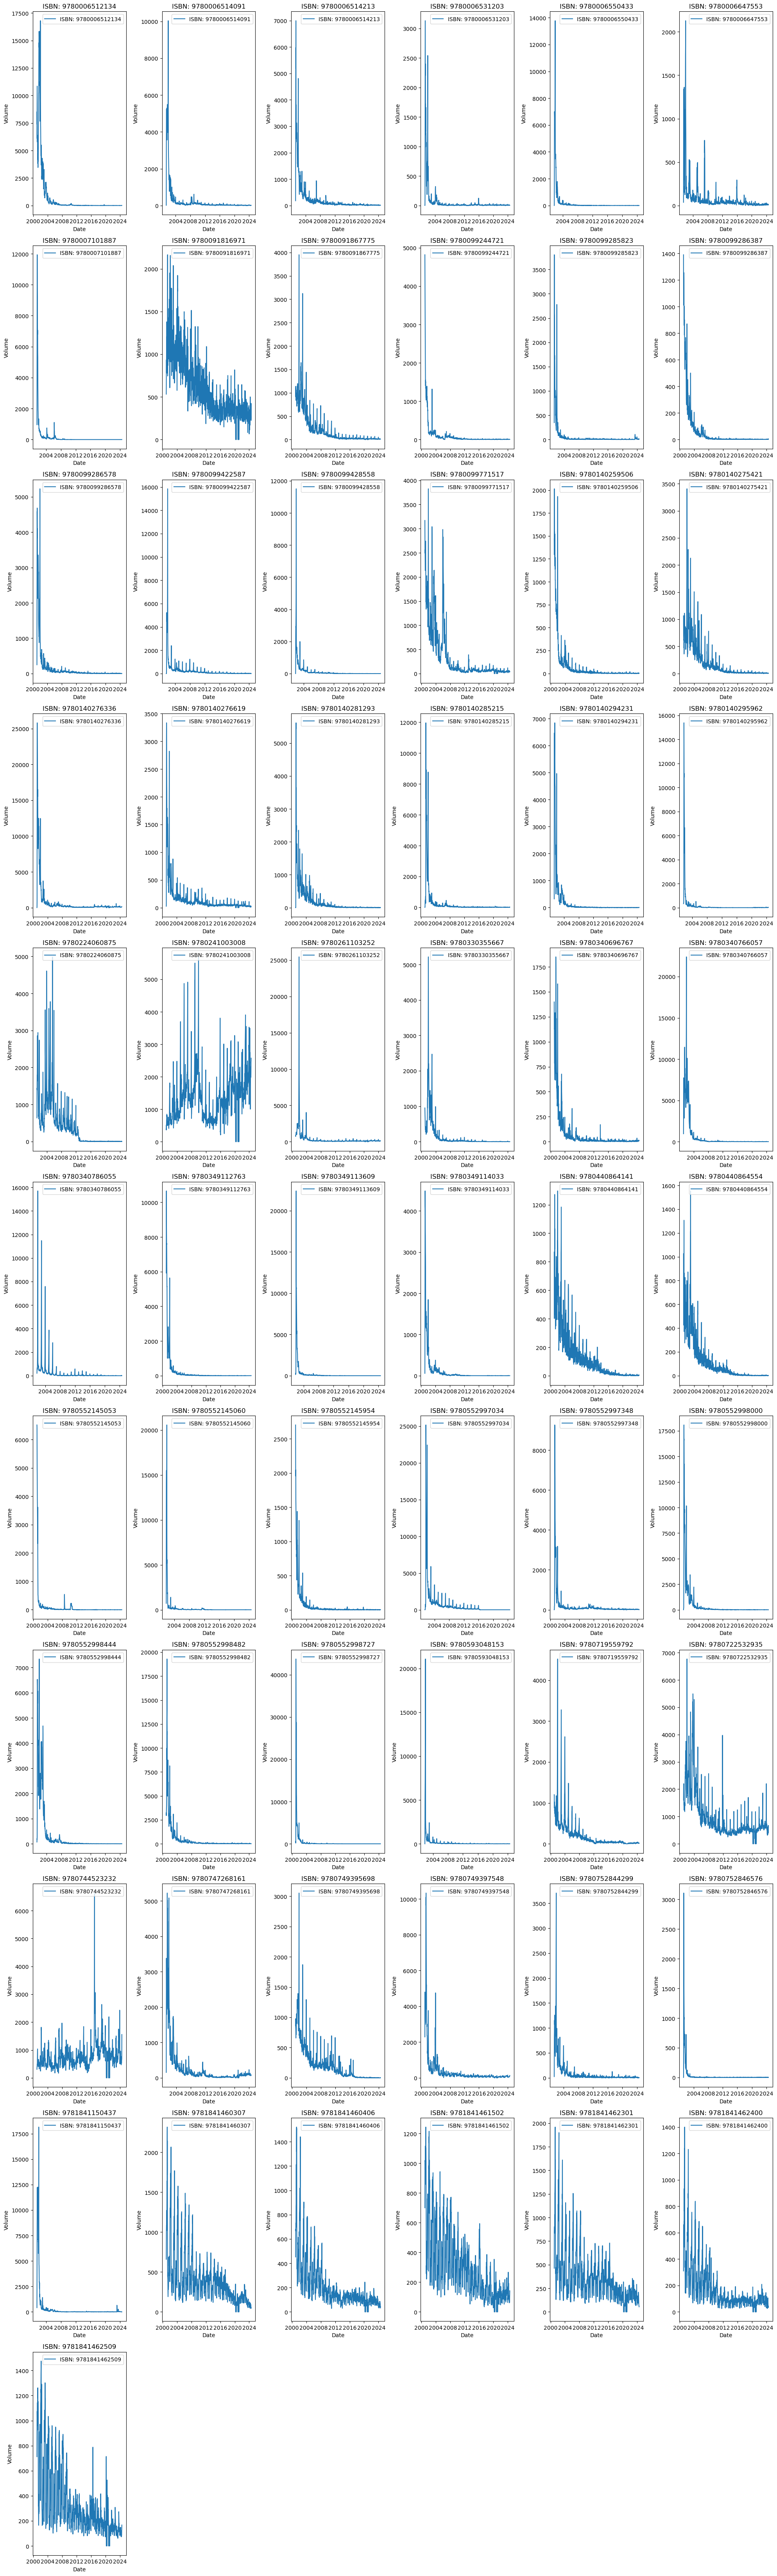

In [ ]:
# Plot the sales volume time series for these ISBNs.
num_plots = len(ISBN_filtered)
rows = (num_plots//6) + (1 if num_plots % 6 != 0 else 0)
cols = 6

# Create the figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each ISBN and plot the data from the original df_UK_weekly dataframe
for idx, isbn in enumerate(ISBN_filtered):
    # Filter the original df_UK_weekly to get data for the current ISBN
    df_UK_weekly_isbn = df_UK_weekly[df_UK_weekly['ISBN'] == isbn]

    # Plot the data
    axes[idx].plot(df_UK_weekly_isbn.index, df_UK_weekly_isbn['volume'], label=f'ISBN: {isbn}')
    axes[idx].set_title(f'ISBN: {isbn}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Volume')
    axes[idx].legend()

# Remove unused subplots if there are any
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout for better spacing
plt.tight_layout()

**General Sales Pattern**
- From these plots, the general sales pattern is fairly consistent across titles whereby there is a strong initial spike in sales immediately after the book is released, followed by a rapid decay in the months following release.
- There is a long tail of lower but relatively stable sales afterwards, sometimes with seasonal increases.
- Some titles show periodic peaks (like annual seasonality) while others decline smoothly without strong seasonality.

**1-12 Years after Release**
- The dominant trend is the rapid drop-off from the intial release spike
- Seasonal peaks are more visible in the first few years for the the more popular titles

**12-24 Years after Release**
- For most titles, the patterns do not drastically change where the long-tail behaviour continues but often at a lower baseline
- The seasonal spikes, if present earlier, generally persist at a smaller scale
- Some older titles retain a steady low-lower sales baseline (e.g. classics)
- The reason the patterns do not drastically change from 1-12 vs 12-24  is likely because by year 12, the book's market position has been established, and it will either continue to have steady sales as a classic or it will have previouslly dropped off with low demand
- In addition, the intial novelty-driven spikes are over after the first year and media attention is often minimal for older titles and so trends tend to remain stable unless a major external event occurs.

## **3.2 Further Analysis**

The books selected for further analysis are 'The Alchemist' and 'The Very Hungry Caterpillar'

In [ ]:
# View 'The Alchemist' ISBNs.
alchemist_isbns = df_ISBN[df_ISBN['title'].str.contains('alchemist', case=False, na=False)]['ISBN'].astype(str).unique()

print('The Alchemist ISBNs:')
print(alchemist_isbns)

The Alchemist ISBNs:
['9780722532935']


In [ ]:
# View 'The Very Hungry Caterpillar ISBNs'.
caterpillar_isbns = df_ISBN[df_ISBN['title'].str.contains('caterpillar', case=False, na=False)]['ISBN'].astype(str).unique()

print('The Very Hungry Caterpillar ISBNs:')
print(caterpillar_isbns)

The Very Hungry Caterpillar ISBNs:
['9780241003008' '9780140500875']


In [ ]:
# Filter sales to retain the date range > 2012-01-01.
df_UK_weekly_post2012 = df_UK_weekly[df_UK_weekly.index > '2012-01-01']

In [ ]:
# View the sales volume for The Alchemist.
for isbns in alchemist_isbns:
    volume = df_UK_weekly_post2012[df_UK_weekly_post2012['ISBN']== isbns]['volume'].sum()
    print(f'Sales Volume for The Alchemist post 2012-01-01 (ISBN = {isbns}): {volume}')

Sales Volume for The Alchemist post 2012-01-01 (ISBN = 9780722532935): 345907


In [ ]:
# View the sales volume for The Very Hungry Caterpillar.
for isbns in caterpillar_isbns:
    volume = df_UK_weekly_post2012[df_UK_weekly_post2012['ISBN']== isbns]['volume'].sum()
    print(f'Sales Volume for The Very Hungry Caterpillar post 2012-01-01 (ISBN = {isbns}): {volume}')

Sales Volume for The Very Hungry Caterpillar post 2012-01-01 (ISBN = 9780241003008): 883534
Sales Volume for The Very Hungry Caterpillar post 2012-01-01 (ISBN = 9780140500875): 2


Time series analysis will focus on 'The Alchemist' (ISBN = 9780722532935) and 'The Very Hungry Caterpillar' (ISBN = 9780241003008). As there are only two sales for ISBN: 9780140500875, this was dropped from further analysis.

In [ ]:
# Filter the dataframe to only contain these two ISBNs.
ts_isbns = ['9780241003008', '9780722532935']

df_UK_weekly_post2012 = df_UK_weekly_post2012[df_UK_weekly_post2012['ISBN'].isin(ts_isbns)]

In [ ]:
# View dataframe.
display(df_UK_weekly_post2012.head())
display(df_UK_weekly_post2012.tail())

# View shape and titles.
print('Shape of DataFrame:', df_UK_weekly_post2012.shape)
print('Titles:', df_UK_weekly_post2012['title'].unique())

In [ ]:
# Standardise the titles.
df_UK_weekly_post2012['title'] = df_UK_weekly_post2012['title'].str.replace(r'^(.*), The$', r'The \1', regex=True)
print('Titles:', df_UK_weekly_post2012['title'].unique())

Titles: ['The Very Hungry Caterpillar' nan 'The Alchemist']


In [ ]:
# Check for missing volume values.
print('Number of Missing Volume Values:', df_UK_weekly_post2012['volume'].isna().sum())

Number of Missing Volume Values: 0


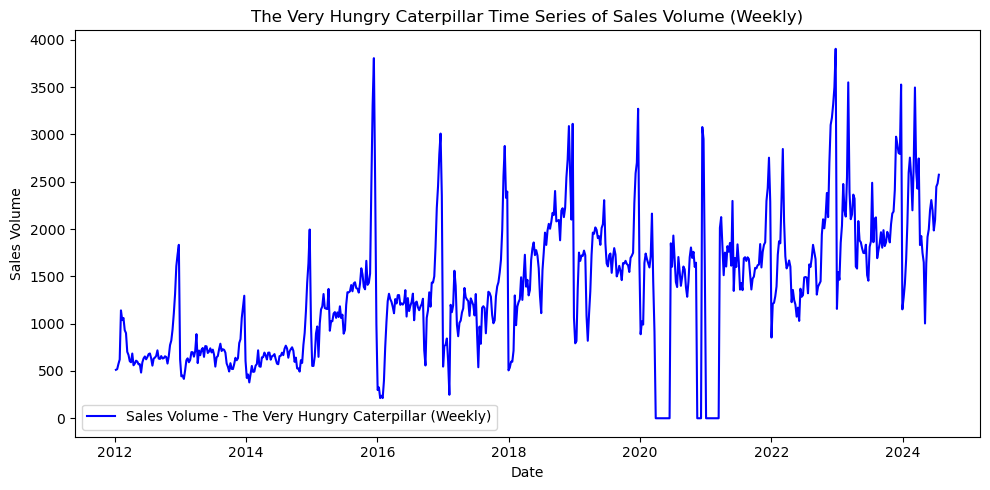

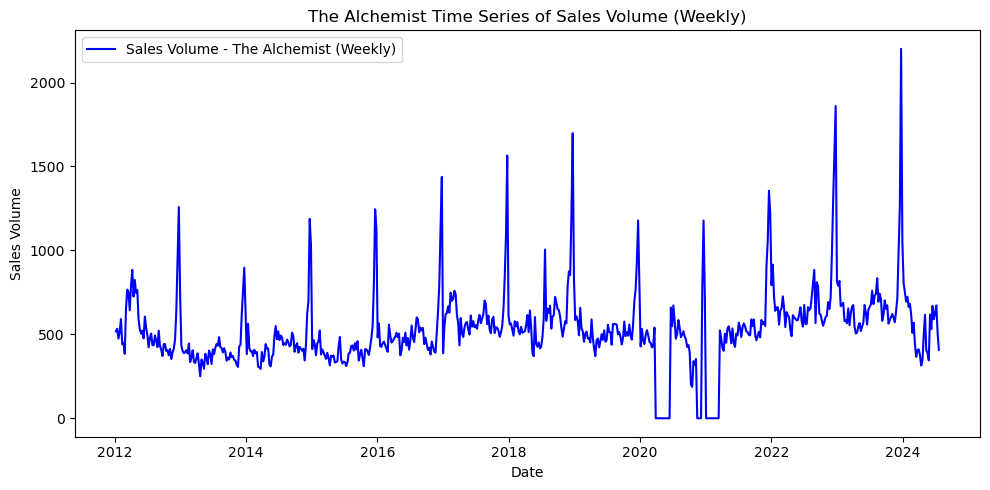

In [ ]:
# Plot the data.
for isbn in ts_isbns:
    book_data = df_UK_weekly_post2012[df_UK_weekly_post2012['ISBN']==isbn]
    title = book_data['title'].unique()[0]

    plt.figure()
    plt.plot(book_data.index, book_data['volume'], label=f'Sales Volume - {title} (Weekly)', color='blue')
    plt.title(f'{title} Time Series of Sales Volume (Weekly)')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

**The Very Hungry Caterpillar**
- Displays a long-term upwards trend where sales generally increase over the 2012-2024 period, indicating sustained popularity.
- Displays strong seasonality with large regular peaks
- Has periods of zero sales, potentially aligning with zero demand due to COVID-19 market disruption
- Has a stable baseline where the weekly sales rarely drop below ~500 units after 2016.

**The Alchemist**
- Has a stable long-term baseline where overall sales hover ~400-600 units/week, with no strong upwards or downwards trend
- Displays highly regular seasonal peaks evidenced by large spikes at consistent intervals
- Also has periods of zero sales at identical time periods to The Very Hungry Caterpillar
- Has no strong growth trend as the book maintains steady sales.

In [ ]:
# Define the dataframes for each book.
df_alchemist = df_UK_weekly_post2012[df_UK_weekly_post2012['ISBN']=='9780722532935']
df_caterpillar = df_UK_weekly_post2012[df_UK_weekly_post2012['ISBN']=='9780241003008']

display(df_alchemist.head())
print('Number of Data Points:', df_alchemist.shape[0])
display(df_caterpillar.head())
print('Number of Data Points:', df_caterpillar.shape[0])

# **4. Classical Time Series Analysis**

## **4.1 Functions**

In [ ]:
# Function to split training and test data.
def train_test(data, forecast_horizon):
    train = data.iloc[:-forecast_horizon]
    test = data.iloc[-forecast_horizon:]

    print(f'Training Period: {train.index.min().date()} to {train.index.max().date()} ({train.shape[0]})')
    print(f'Test Period: {test.index.min().date()} to {test.index.max().date()} ({test.shape[0]})')

    return train, test

In [ ]:
# Function to make arima pipeline.
def arima_pipeline(use_log:bool, use_boxcox:bool, **arima_kwargs):
    steps = []

    # If the data needs to be transformed (multiplicative), add log transformer/ boxcox transformer to pipeline.
    if use_log:
        steps.append(('log1p', LogEndogTransformer(lmbda=1.0)))

    elif use_boxcox:
        steps.append(('boxcox', BoxCoxEndogTransformer(lmbda=None, lmbda2=1.0, neg_action='shift')))

    # auto-arima step
    steps.append(('auto_arima', pm.AutoARIMA(**arima_kwargs)))

    return Pipeline(steps=steps)

In [ ]:
# Function to load or fit a new model.
def load_or_fit_arima(model_path, train, use_log, use_boxcox, **arima_kwargs):

    # If the model exists, load the model, if not, then train a new model.
    if os.path.exists(model_path):
        print(f'Model Found. Loading: {model_path}')
        model = joblib.load(model_path)
    else:
        print('No Model Found. Training new Model.')
        model = arima_pipeline(use_log=use_log, use_boxcox=use_boxcox, **arima_kwargs)
        model.fit(train)

        # Save the model only if the model converged.
        if model.named_steps['auto_arima'].model_.arima_res_.mle_retvals.get('converged', False):
            joblib.dump(model, model_path)
            print(f'Model Converged. Model Saved to: {model_path}')
        else:
            print('Model did not Converged. Model not Saved.')

    return model

In [ ]:
# Function for residual diagnostics.
def residual_diagnostics(model, lags):
    residuals = model.named_steps['auto_arima'].model_.arima_res_.resid

    # Plot a histogram of the residuals.
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Plot an ACF plot of the residuals
    sm.graphics.tsa.plot_acf(residuals)
    plt.title('ACF plot of Residuals')
    plt.tight_layout()
    plt.show()

    lb_df = acorr_ljungbox(residuals, lags=lags, return_df=True)
    ac = lb_df.index[lb_df['lb_pvalue'] < 0.05].tolist()
    if ac:
        print(f'Evidence of auocorrelation at lags: {ac} (alpha = 0.05)')
    else:
        print('No signficiant autocorrelation at tested lags (alpha = 0.05)')

    return residuals

In [ ]:
# Function to forecast and plot the results.
def forecast_and_plot_arima(model, y_full, y_train, y_test, title):
    n_periods = len(y_test)
    pred, conf = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)
    fitted = model.predict_in_sample()

    pred = pd.Series(pred, index=y_test.index)
    lower_ci = pd.Series(conf[:, 0], index=y_test.index)
    upper_ci = pd.Series(conf[:, 1], index=y_test.index)

    # align fitted to the tail of y_train
    fitted_index = y_train.index[-len(fitted):]
    fitted = pd.Series(fitted, index=fitted_index)

    # make a full-length fitted series for the full-history plot
    fitted_full = pd.Series(index=y_train.index, dtype=float)
    fitted_full.iloc[-len(fitted):] = fitted.values
    fitted = pd.Series(fitted, index=y_train.index)

    mae = mean_absolute_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred) * 100

    # Plot the standard plot.
    plt.figure(figsize=(14, 4))
    plt.plot(y_full, label='Observed', color='black')
    plt.plot(fitted.index, fitted, label='Fitted', color='red', linestyle='--')
    plt.plot(pred.index, pred, label='Forecast', color='orange')
    plt.fill_between(pred.index, lower_ci, upper_ci, color='grey', alpha=0.3, label='95% CI')
    plt.title(f'{title} (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot a zoomed plot for visibility.
    zoom_start = y_test.index[0] - pd.Timedelta(weeks=104)
    zoom_end = y_test.index[-1]
    zoom = y_full[(y_full.index >= zoom_start) & (y_full.index <= zoom_end)]
    shared_index = zoom.index.intersection(fitted.index)

    plt.plot(zoom, label='Observed', color='black')
    plt.plot(shared_index, fitted.loc[shared_index], label='Fitted', color='red', linestyle='--')
    plt.plot(pred.index, pred, label='Forecast', color='orange')
    plt.fill_between(pred.index, lower_ci, upper_ci, color='grey', alpha=0.3, label='95% CI')
    plt.title(f'{title} - Zoomed (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.legend()
    plt.tight_layout()

    # Save the zoomed figure.
    out_dir = 'figures'
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, (f'{title} (zoomed).png')), dpi=300, bbox_inches='tight')

    plt.show()

    return pred, mae, mape

## **4.2 Training and Test Data**

In [ ]:
# Keep a copy of the original book data (full time series).
alchemist_arima = df_alchemist.copy()
caterpillar_arima = df_caterpillar.copy()

# Ensure data is sorted by date.
alchemist_arima = alchemist_arima.sort_index()
caterpillar_arima = caterpillar_arima.sort_index()

# Keep only end_date index and sales volume.
alchemist_arima = alchemist_arima.drop(['title', 'ISBN'], axis=1)
caterpillar_arima = caterpillar_arima.drop(['title', 'ISBN'], axis=1)

# Set the forecast horizon.
fh_weekly = 32

# Split the data into training and test set.
alchemist_train_arima, alchemist_test_arima = train_test(alchemist_arima, forecast_horizon=fh_weekly)
caterpillar_train_arima, caterpillar_test_arima = train_test(caterpillar_arima, forecast_horizon=fh_weekly)

Training Period: 2012-01-08 to 2023-12-10 (623)
Test Period: 2023-12-17 to 2024-07-21 (32)
Training Period: 2012-01-08 to 2023-12-10 (623)
Test Period: 2023-12-17 to 2024-07-21 (32)


## **4.3 Decomposition**

In [ ]:
# Determine if The Alchemist and The Very Hungry Caterpillar contain zero values.
alchemist_zero = df_alchemist[df_alchemist['volume'] == 0].shape[0]
caterpillar_zero = df_caterpillar[df_caterpillar['volume'] == 0].shape[0]

print('The Alchemist Zero Values:', alchemist_zero)
print('The Very Hungry Caterpillar Zero Values:', caterpillar_zero)

The Alchemist Zero Values: 27
The Very Hungry Caterpillar Zero Values: 27


As the volume columns for the two books contains zero values and zero values are valid (i.e. no book sales), the data needs to be transformed. This is because multiplicative decomposition cannot handle zero values as it assumes the components multiply together and so zero values breaks this logic.

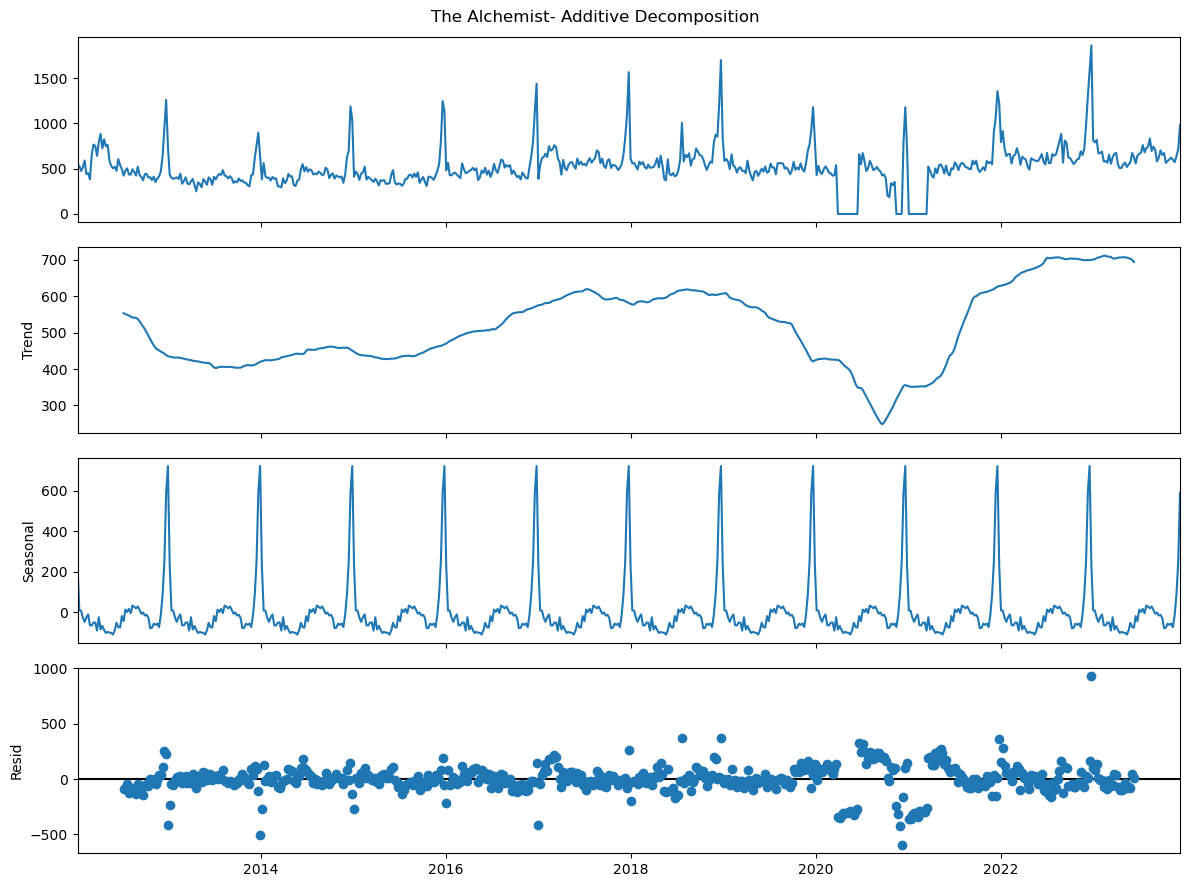

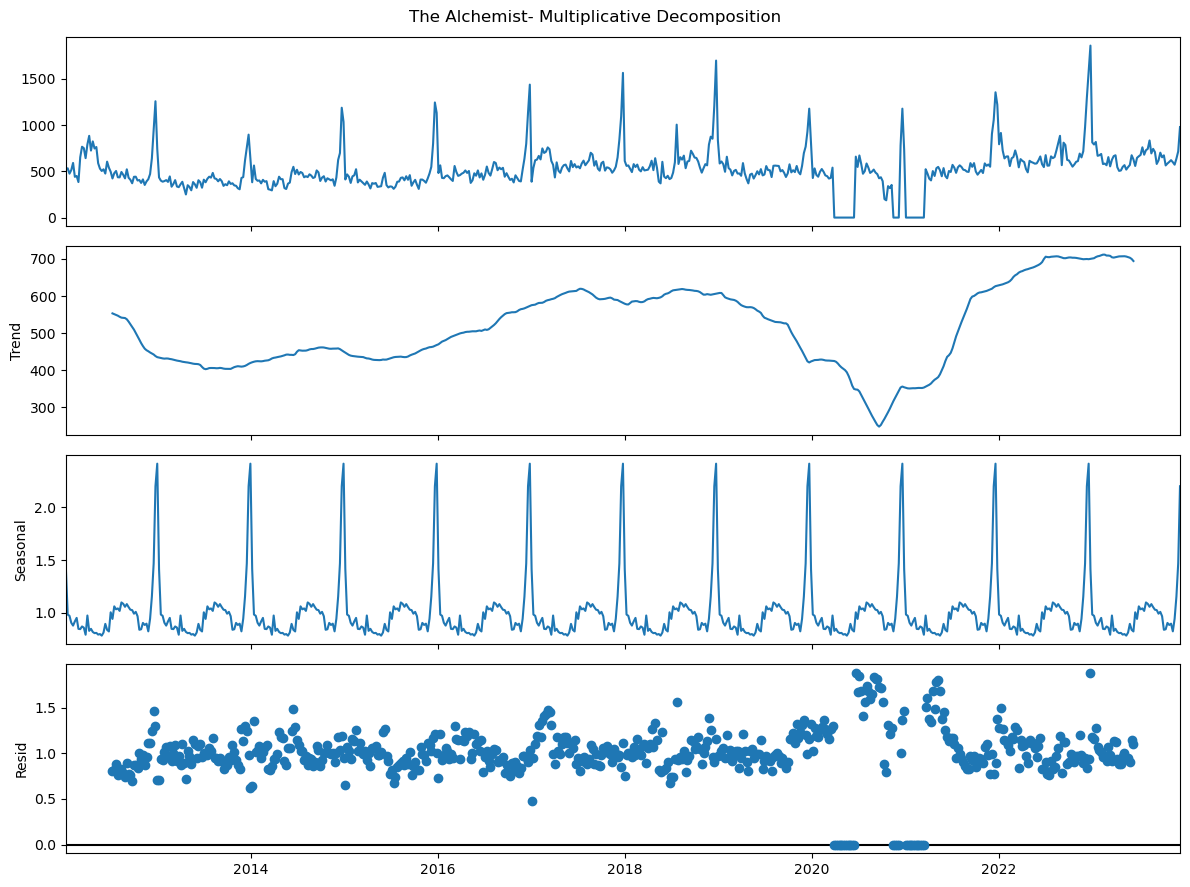

In [ ]:
# Transform alchemist the data for multiplicative model to prevent zero values.
epsilon = 1e-6
y = alchemist_train_arima[['volume']]
alchemist_train_arima_shifted = y + epsilon

# Decomposition for df_alchemist.
models = ['additive', 'multiplicative']

for model in models:
    result = sm.tsa.seasonal_decompose(alchemist_train_arima_shifted, model=model, period=52)
    fig = result.plot()
    fig.set_size_inches(12, 9)
    plt.suptitle(f'The Alchemist- {model.capitalize()} Decomposition')
    plt.tight_layout()
    plt.savefig(f"{model}_alchemist.png", dpi=300)
    plt.show()

The additive decomposition shows that the seasonal component of The Alchemist is highly regular, with annual peaks of relatively consistent magnitude over the 2012-2024 period. The seasonal effect appears to be largely independent of the underlying trend level and the amplitude of the seasonal peaks does not vary dramatically as baseline sales changes. This stability means than an additive seasonality assumption is acceptable. In addition, the residual variance is similar in both the multiplicative and addiitve case suggesting no addition benefit.
**Additive model will be used for The Alchemist**

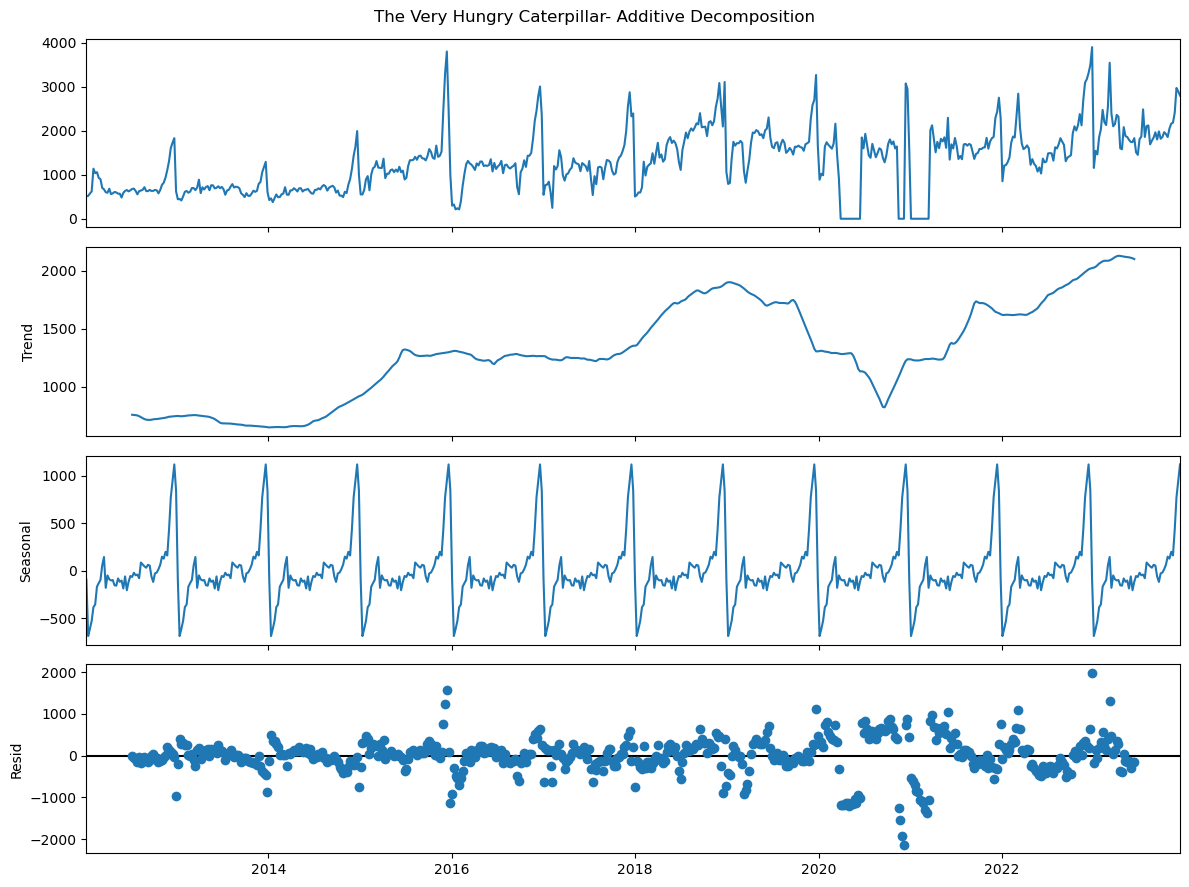

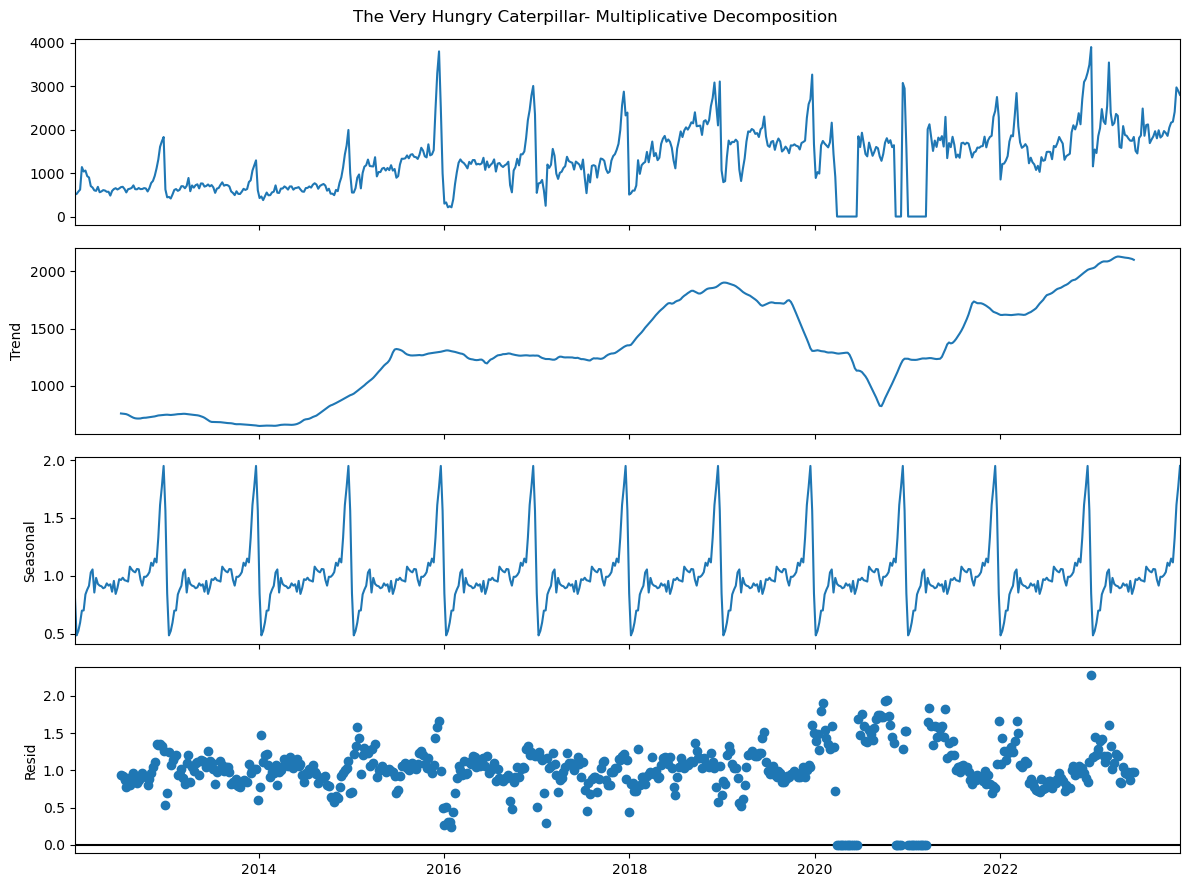

In [ ]:
# Transform caterpillar the data for multiplicative model.
epsilon = 1e-6
y = caterpillar_train_arima[['volume']]
caterpillar_train_arima_shifted = y + epsilon

# Decomposition for The Very Hungry Caterpillar.
models = ['additive', 'multiplicative']

for model in models:
    result = sm.tsa.seasonal_decompose(caterpillar_train_arima_shifted, model=model, period=52)
    fig = result.plot()
    fig.set_size_inches(12, 9)
    plt.suptitle(f'The Very Hungry Caterpillar- {model.capitalize()} Decomposition')
    plt.tight_layout()
    plt.savefig(f"{model}_caterpillar.png", dpi=300)
    plt.show()

Both models capture the strong annual seasonality however the multiplicative approach appears better suited as the amplitude of the seasonal peaks clearly increase as the baseline sales grow. **Multiplicative model will be used for The Very Hungry Caterpillar**. The data will need to be transformed to stabilise the variance before input into auto-arima.

In [ ]:
# Perform Box-Cox transformation for ACF/PACF and ADF test- use boxcox1p due to non-zero values.
y_caterpillar = caterpillar_train_arima.reset_index()
y_caterpillar = pd.Series(y_caterpillar['volume']).astype(float)

lam = stats.boxcox_normmax(y_caterpillar + 1)
y_caterpillar_bc = boxcox1p(y_caterpillar, lam)

## **4.4 ACF & PACF**

<Figure size 2000x1200 with 0 Axes>

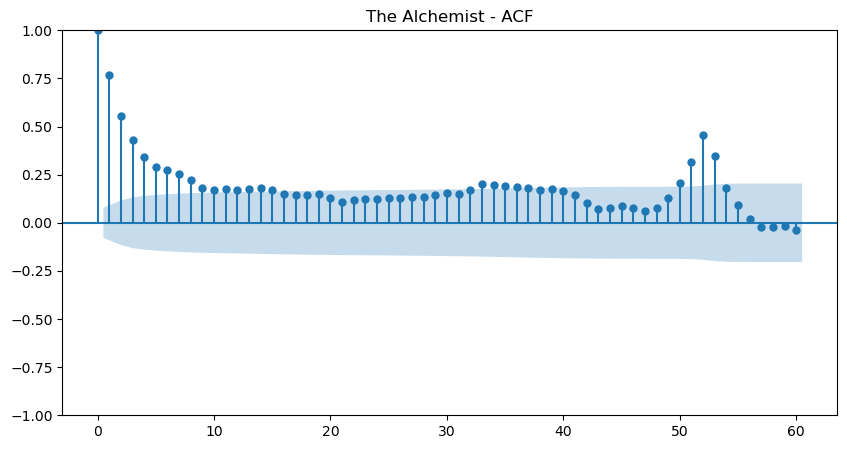

<Figure size 2000x1200 with 0 Axes>

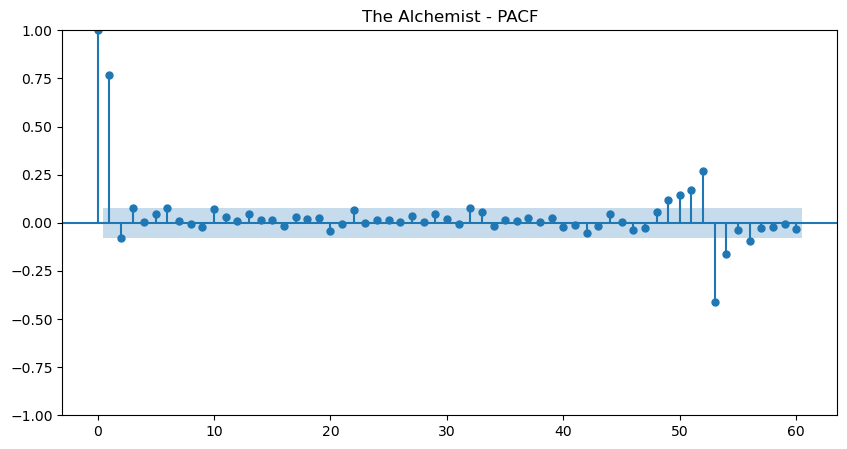

In [ ]:
# Create the ACF and PACF plot for The Alchemist.
plot_funcs = [plot_acf, plot_pacf]
titles = ['ACF', 'PACF']

for func, title in zip(plot_funcs, titles):
    plt.figure(figsize=(20, 12))
    func(alchemist_train_arima, lags=60)
    plt.title(f'The Alchemist - {title}')
    plt.show()

**ACF Observations**
- Lag 1-4 shows a gradual decay in autocorrelation which could indicate non-stationarity and suggests an AR component
- Significant spikes at lag 52 indicate a strong annual seasonality
- No sharp cut-off after a few lags supports the idea of mixed AR and MA terms- MA could be small but set max_q = 3-4 for exploration

**PACF Observations**
- Large spike at lag 1 shows clear evidence for an AR term, followed by a sharp cut-off which supports the idea of setting max_p = 2
- Seasonal lags in PACF suggests a seasonal AR term

**Suggested Parameters**
- max_q = 4
- max_p = 2
- max_P = 1
- max_Q = 1

<Figure size 2000x1200 with 0 Axes>

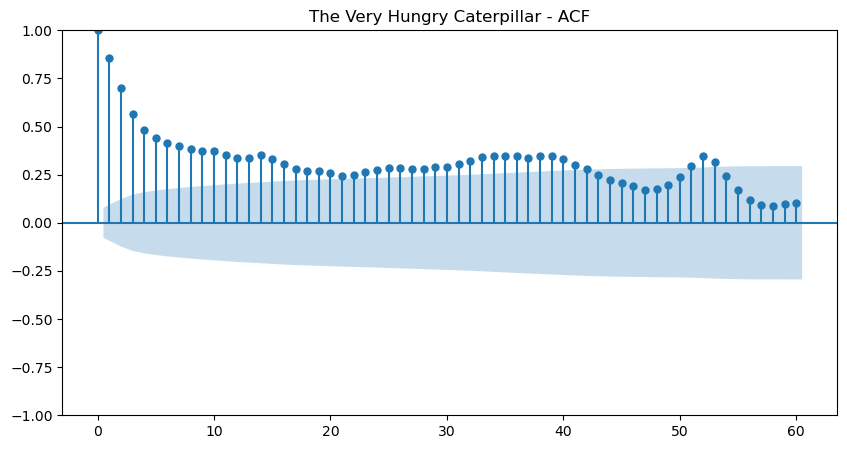

<Figure size 2000x1200 with 0 Axes>

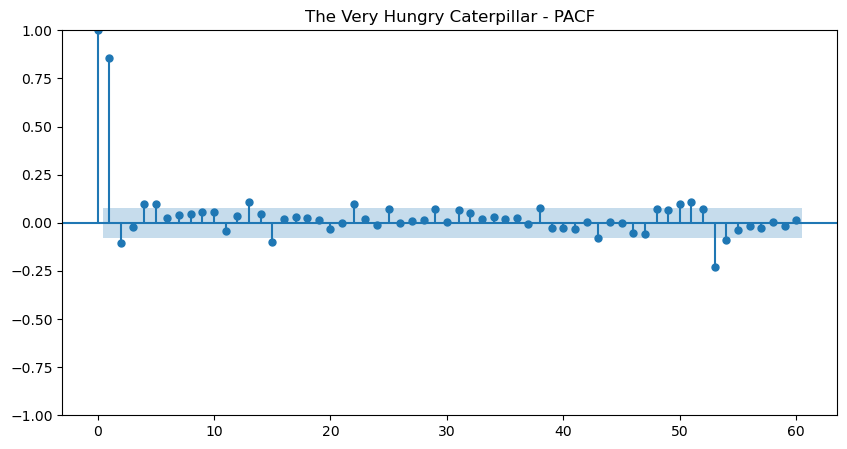

In [ ]:
# Create the ACF and PACF plot for The Very Hungry Caterpillar (using boxcox transformed data).
plot_funcs = [plot_acf, plot_pacf]
titles = ['ACF', 'PACF']

for func, title in zip(plot_funcs, titles):
    plt.figure(figsize=(20, 12))
    func(y_caterpillar_bc, lags=60)
    plt.title(f'The Very Hungry Caterpillar - {title}')
    plt.show()

**ACF Observations**
- Strong positive autocorrelation at lags 1–4 with a gradual decay, suggesting non-stationarity and the need for differencing.
- Clear seasonal spike at lag 52 confirms strong annual seasonality.
- Slow decay rather than a sharp cut-off supports the inclusion of both AR and MA terms; MA order could be modest but worth exploring up to max_q = 3–4.

**PACF Observations**
- Large spike at lag 1 followed by a quick drop indicates at least one AR term, with max_p = 2 as a reasonable exploration limit.
- Seasonal spike at lag 52 suggests a seasonal AR component is needed.

**Suggested Parameters**
- max_q = 4
- max_p = 2
- max_P = 1
- max_Q = 1

## **4.5 Stationarity Testing**

In [ ]:
# Test The Alchemist training data for stationarity.
adf_alchemist = adf(alchemist_train_arima)
print('p-value for Alchemist Data:', adf_alchemist[1])

p-value for Alchemist Data: 6.985515830832326e-12


**ADF Test**
- **Null hypothesis:** Data contains a unit root and so is non-stationary.
- The p-value is < 0.05 so the null hypothesis can be rejected.
- This suggests the data is stationary and so does not require differencing.

**Suggested Parameters**
- d = 0

In [ ]:
# Test The Very Hungry Catepillar training data for stationarity.
adf_caterpillar = adf(y_caterpillar_bc)
print('p-value for Caterpillar Data:', adf_caterpillar[1])

p-value for Caterpillar Data: 0.0137221329422625


**ADF Test**
- **Null hypothesis:** Data contains a unit root and so is non-stationary.
- The p-value is < 0.05 so the null hypothesis can be rejected.
- This suggests the data is stationary and so does not require differencing.

**Suggested Parameters**
- d = 0

## **4.6 Auto-ARIMA Modeling & Forecasting**

In [ ]:
# Default **arima_kwargs
arima_kwargs = dict(
    seasonal=True, m=52,
    enforce_stationary=True, enforce_invertibility=True, with_intercept=False,
    stepwise=True, suppress_warnings=True, trace=True, error_action="ignore",
    max_p=2, max_q=2, max_P=1, max_Q=1, d=0, D=1
)

### **4.6.1 The Alchemist (Model 1)**

- Guided by the decomposition results, SARIMA was fit with additive seasonality.
- The best model will be identified using `auto-arima` with an AIC driven stepwise search over (p, q, P, Q), with seasonal period m=52.

In [ ]:
# Define model path.
alchemist_path = 'models/alchemist_arima_model.pkl'

# Set the model parameters.
alchemist_kwargs = arima_kwargs | {'max_q': 4}

# Train the model (additive with no differencing).
alchemist_arima_model = load_or_fit_arima(alchemist_path, alchemist_train_arima, use_log=False, use_boxcox=False, **alchemist_kwargs)

Model Found. Loading: models/alchemist_arima_model.pkl


In [ ]:
# View the model summary.
alchemist_arima_model.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  623
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 52)   Log Likelihood               -3499.311
Date:                              Mon, 18 Aug 2025   AIC                           7008.622
Time:                                      13:37:14   BIC                           7030.359
Sample:                                  01-08-2012   HQIC                          7017.103
                                       - 12-10-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9353      0.014     66.181      0.000       0.908       0.963
ma.L1         -0.3224      0.031    -10.440      0.000      -0.383      -0.262
ma.L2         -0.1255      0.038     -3.262      0.001      -0.201      -0.050
ma.S.L52      -0.4990      0.022    -22.860      0.000      -0.542      -0.456
sigma2      1.199e+04    380.148     31.549      0.000    1.12e+04    1.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1066.69
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- All coefficients are significant (p < 0.05) which suggest they all contribute meaningfully
- **Ljung-Box test** p-value = 0.94 (p > 0.05) which suggests the residuals show no autocorrelation at lag 1.
- **Jarque-Bera test** p-value = 0.00 (p < 0.001) which suggests the residuals are not normally distributed (confirmed by high kurtosis = 9.51).
- **Heteroskedascity** p-value = 0.00 (p< 0.001) suggests the variance of residuals is not constant and the skew = 0.79 suggests they are skewed positively

**Interpretation**
- The model captures the main structure well (no significant autocorrelation in the residuals), but the non-normal, heteroskedastic residuals suggests there may be extreme seasonal spikes not fully explained by the current structure
- The model could potentially benefit from variance stabilising transformations like Box-cox.


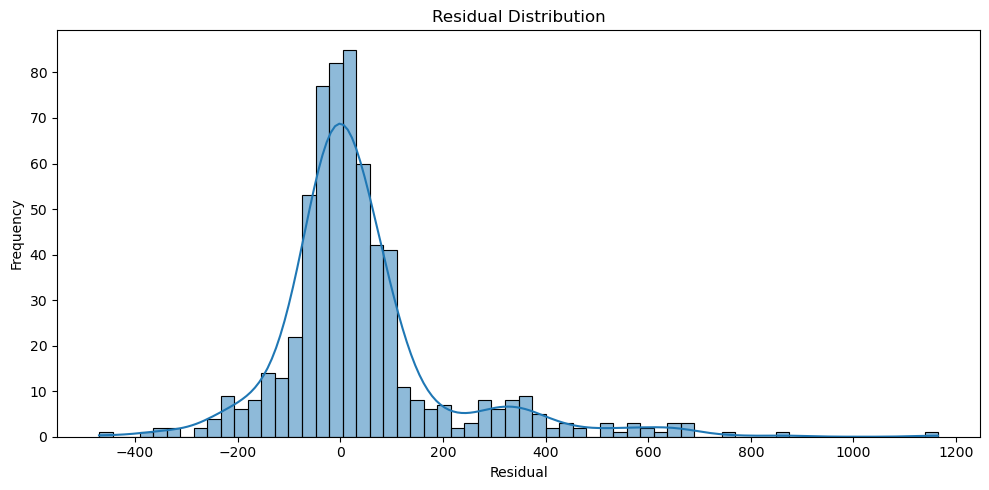

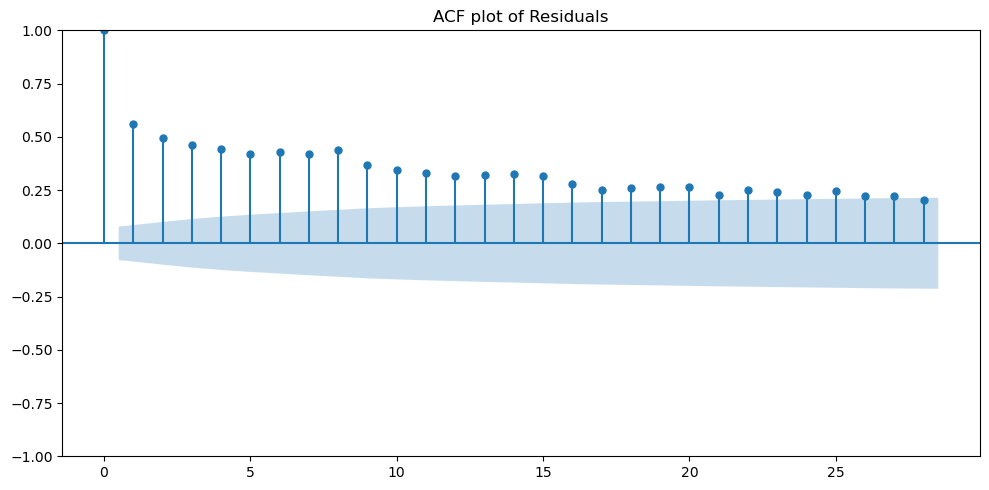

Evidence of auocorrelation at lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
alchemist_arima_model_residuals = residual_diagnostics(alchemist_arima_model, lags=52)

**Residuals Diagnostics**
- A histogram plot of the residuals indicated they do not have a normal distribution, as supported by the JB test.
- An ACF plot of the residuals indicate that autocorrelation in the residuals/ noise from heterskedascity and that potentially there is some structure the model has failed to capture.
- Ljung-box text for lags=60 indicates there is autocorrelation present and so there is some structure the model has failed to capture.
- Further parameter changes are required.

### **4.6.2 The Alchemist (Model 2-4)**

To investigate model improvements, three model variations were trials including forcing a seasonal AR term, differencing and stabilising the variance using boxcox transformation.

In [ ]:
# Test different models to improve the auto_arima results using the best model from auto-arima as the starting point.
y = alchemist_train_arima['volume']

# Model P: Using the results from auto-arima but adding seasonal AR (P=1)
alchemist_arima_model_P = SARIMAX(y, order=(1, 0, 2), seasonal_order=(1, 1, 1, 52))
results_2 = alchemist_arima_model_P.fit(disp=False)

# Model d: Test differencing the data, despite the ADF test suggesting the data was stationary.
alchemist_arima_model_d = SARIMAX(y, order=(1, 1, 2), seasonal_order=(0, 1, 1, 52))
results_3 = alchemist_arima_model_d.fit(disp=False)

# Model bc: Box-cox transform
y_alchemist = alchemist_train_arima.reset_index()
y_alchemist = pd.Series(y_alchemist['volume']).astype(float)
lam = stats.boxcox_normmax(y_alchemist + 1)
y_alchemist_bc = boxcox1p(y_alchemist, lam)

alchemist_arima_model_bc = SARIMAX(y_alchemist_bc, order=(1, 0, 2), seasonal_order=(0, 1, 1, 52))
results_4 = alchemist_arima_model_bc.fit(disp=False)


In [ ]:
# Function for residual diagnostics.
from scipy.stats import jarque_bera

def evaluate_arima_model(results, model_name):
    residuals = results.resid
    print(f'\n{model_name}')

    # Model convergence.
    converged = results.mle_retvals.get('converged', None)
    if converged is not None:
        print(f'Model converged: {converged}')
    else:
        print('Convergence info not available')

    # AIC result.
    print(f'AIC: {results.aic:.2f}')

    # JB test
    jb_stat, jb_p = jarque_bera(residuals)
    print(f'JB p-value: {jb_p:.4f}')

    # Ljung-box test
    lb = acorr_ljungbox(residuals, lags=52, return_df=True)
    n_sig = sum(lb['lb_pvalue'] < 0.05)
    print(f'Ljung-box: {n_sig}/52 lags with p < 0.05')

    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(residuals, lags=52, ax=axes[0])
    axes[0].set_title(f'{model_name} - ACF of Residuals')
    plot_pacf(residuals, lags=52, ax=axes[1])
    axes[1].set_title(f'{model_name} - PACF of Residuals')
    plt.tight_layout()
    plt.show()


Model: Seasonal AR added
Model converged: True
AIC: 7009.09
JB p-value: 0.0000
Ljung-box: 52/52 lags with p < 0.05


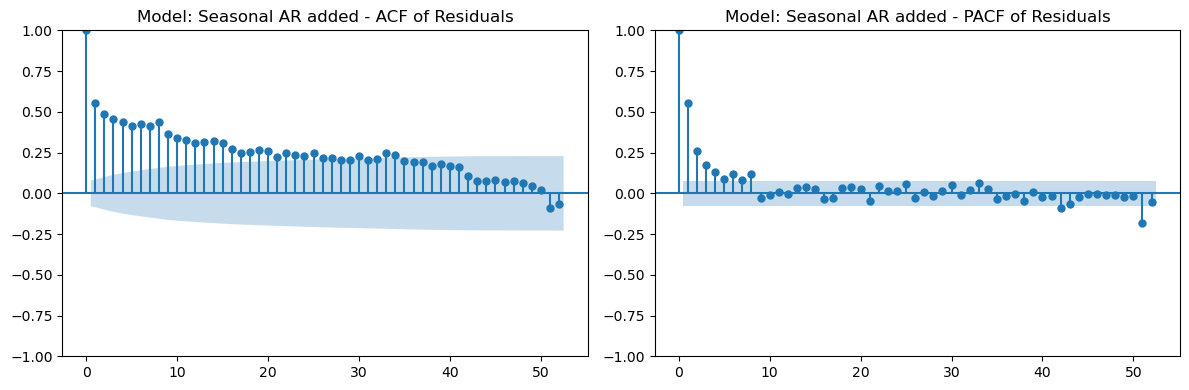


Model: d=1
Model converged: True
AIC: 7011.93
JB p-value: 0.0000
Ljung-box: 1/52 lags with p < 0.05


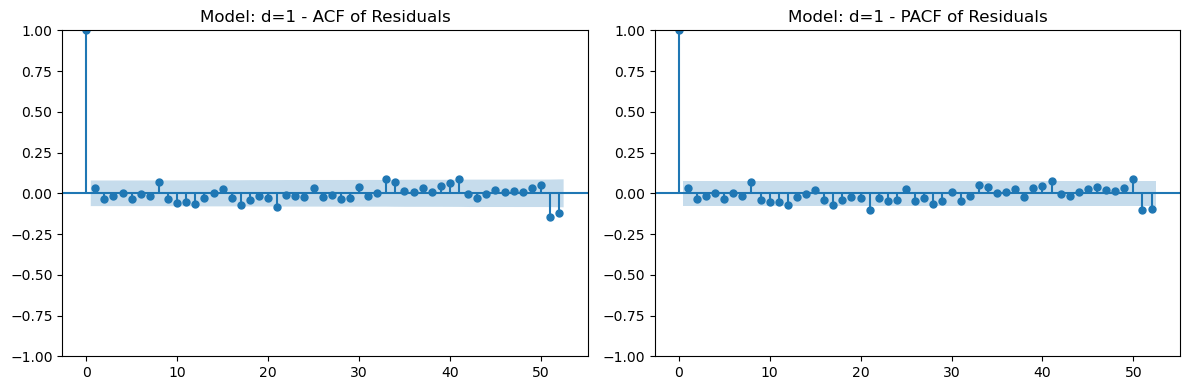


Model: Boxcox-transformed
Model converged: True
AIC: 5967.62
JB p-value: 0.0000
Ljung-box: 52/52 lags with p < 0.05


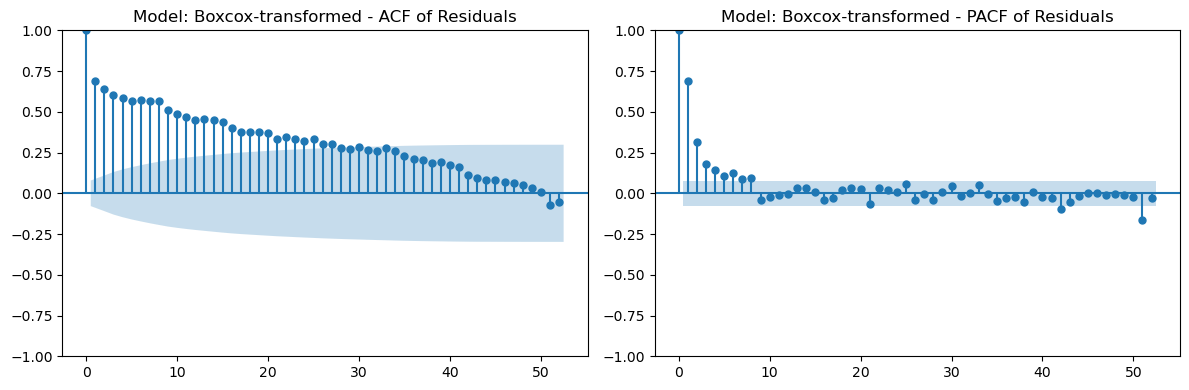

In [ ]:
# Evaluate the models.
evaluate_arima_model(results_2, model_name='Model: Seasonal AR added')
evaluate_arima_model(results_3, model_name='Model: d=1')
evaluate_arima_model(results_4, model_name='Model: Boxcox-transformed')

**Model: Seasonal AR added**
- Residual autocorrelation remains evidenced from both Ljung-box test and ACF plot.

**Model: Box-cox transformation**
- Residual autocorrelation remains evidenced from both Ljung-box test and ACF plot.

**Model: d=1**
- No autocorrelation in the residuals 1-51 suggesting most ofthe structure from the data has been captured, however fit is worse (lower AIC) and there is still autocorrelation at lag 52.
- Use d=1 and max_P = 2 in the next model and re-try auto-arima.

**Note:** increasing max_P / max_Q was tested to address the autocorrelation observed at lag 52, however, this lead to non-convergence of the model. Future work will be to investigate fourier terms.

In [ ]:
# Define new model path.
alchemist_path = 'models/alchemist_arima_model_2.pkl'

# Set the model parameters (d=1 for differencing)
alchemist_kwargs = alchemist_kwargs | {'d': 1,
                                       'enforce_invertibility': False,
                                       'enforce_stationarity': False}

# Train new model (additive with no differencing)- Model 2.
alchemist_arima_model_2 = load_or_fit_arima(alchemist_path, alchemist_train_arima, use_log=False, use_boxcox=False, **alchemist_kwargs)

Model Found. Loading: models/alchemist_arima_model_2.pkl


In [ ]:
# View the model summary.
alchemist_arima_model_2.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  623
Model:             SARIMAX(0, 1, 4)x(1, 1, [1], 52)   Log Likelihood               -3154.975
Date:                              Mon, 18 Aug 2025   AIC                           6323.949
Time:                                      13:37:47   BIC                           6353.631
Sample:                                  01-08-2012   HQIC                          6335.583
                                       - 12-10-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3848      0.028    -13.705      0.000      -0.440      -0.330
ma.L2         -0.1551      0.040     -3.842      0.000      -0.234      -0.076
ma.L3         -0.0027      0.045     -0.059      0.953      -0.091       0.086
ma.L4         -0.0288      0.041     -0.696      0.487      -0.110       0.052
ar.S.L52      -0.1571      0.059     -2.671      0.008      -0.272      -0.042
ma.S.L52      -0.3931      0.050     -7.824      0.000      -0.492      -0.295
sigma2      1.276e+04    395.192     32.279      0.000     1.2e+04    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1142.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- All coefficients are significant (p < 0.05), suggesting they all contribute meaningfully to the model.
- **Ljung–Box test** p-value = 0.98 (p > 0.05) suggests the residuals show no autocorrelation at lag 1.
- **Jarque–Bera test** p-value = 0.00 (p < 0.001) suggests the residuals are not normally distributed (confirmed by high kurtosis = 9.81).
- **Heteroskedasticity** p-value = 0.00 (p < 0.001) suggests the variance of residuals is not constant, and the skew = 0.94 suggests they are positively skewed.
  
**Interpretation**
- The model captures the main structure well (no significant autocorrelation in the residuals at lag 1), but the non-normal, heteroskedastic residuals suggest there may be extreme seasonal spikes not fully explained by the current structure.

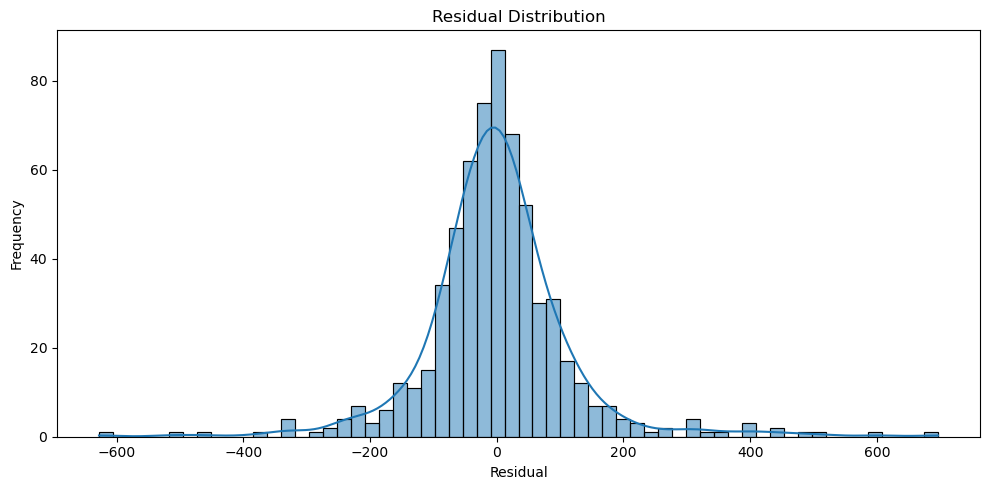

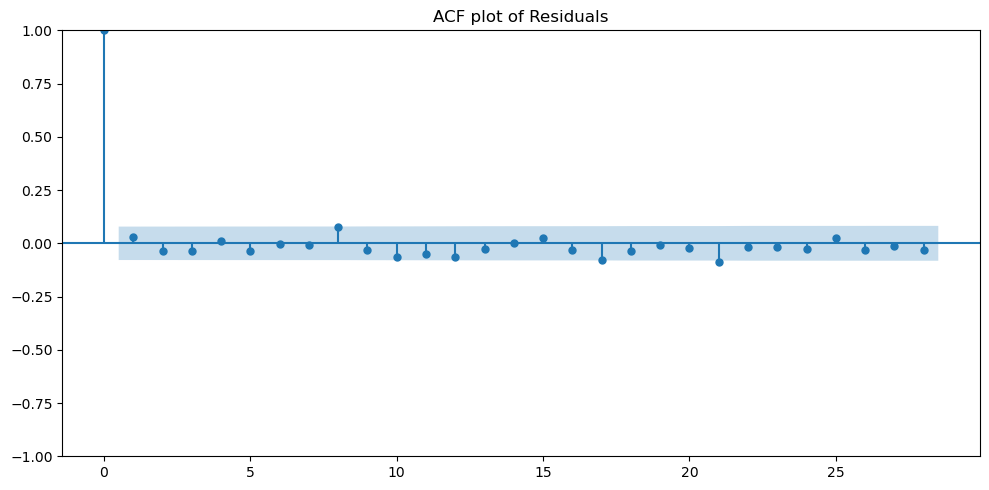

Evidence of auocorrelation at lags: [52] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
alchemist_arima_residuals_2 = residual_diagnostics(alchemist_arima_model_2, lags=52)

**Note:** increasing max_P / max_Q was tested to address the autocorrelation observed at lag 52, however, this lead to non-convergence of the model. Future work will be to investigate fourier terms.

- However, the ACF plot and histogram is significantly improve compared to the initial model and that all short-lag correlation has been removed. While the histogram still has evidence of some tails, it is noticably tighter around zero and more symmetric. The extreme values are less frequent suggesting improved variance control.
- Overall, the current model has greatly improved residuals (i.e more like white noise)

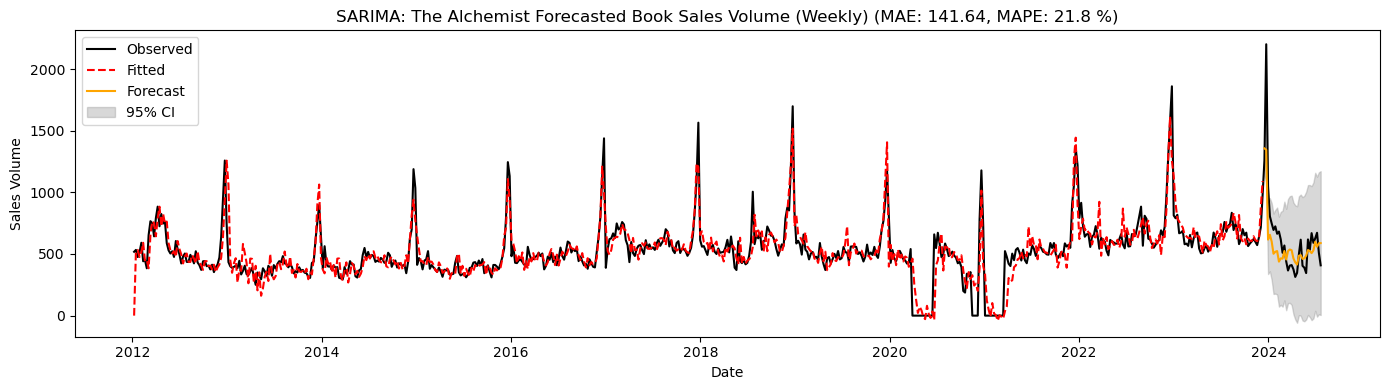

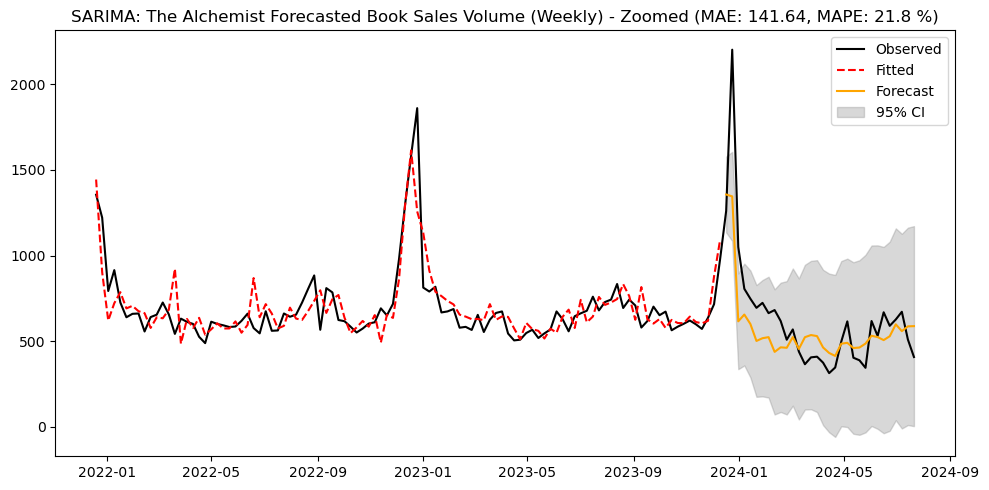

In [ ]:
# Forecast and plot the results.
alchemist_title = 'SARIMA: The Alchemist Forecasted Book Sales Volume (Weekly)'
alchemist_arima_pred, alchemist_arima_mae, alchemist_arima_mape = forecast_and_plot_arima(alchemist_arima_model_2, alchemist_arima, alchemist_train_arima, alchemist_test_arima, alchemist_title)

- The fitted values (red dashed line) closely follow the observed data during the training period, capturing both the seasonal peaks and troughs reasonably well, though some spikes are slightly under estimated.
- The forecast (orange line) maintains the seasonal pattern but sows a gradual decline from the last observed peak before stabilising. The confidence intervals widen over time suggesting growing uncertainty further into the forecast horizon.
- The models MAE (141.64) and MAPE (21.8%) indicate a moderate level of accuracy.

### **4.6.3 The Very Hungry Caterpillar**

- Guided by the decomposition results, multiplicative seasonality was modelled by applying a Box-Cox transformation and fitting SARIMA on the transformed series.
- The best model will be identified using `auto-arima` with an AIC driven stepwise search over (p, q, P, Q), with seasonal period m=52.
- The results are reported on the original scale via the inverse Box-Cox

In [ ]:
# Define model path.
caterpillar_path = 'models/caterpillar_arima_model.pkl'

# Set the model parameters.
caterpillar_kwargs = arima_kwargs | {'max_q': 4}

# Train the model (multiplicative so use_log=True with no differencing).
caterpillar_arima_model = load_or_fit_arima(caterpillar_path, caterpillar_train_arima, use_log=False, use_boxcox=True, **caterpillar_kwargs)

Model Found. Loading: models/caterpillar_arima_model.pkl


In [ ]:
# View the best model summary.
caterpillar_arima_model.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  623
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 52)   Log Likelihood               -2855.955
Date:                            Mon, 18 Aug 2025   AIC                           5719.909
Time:                                    13:37:48   BIC                           5737.299
Sample:                                         0   HQIC                          5726.694
                                            - 623                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3228      1.552      1.496      0.135      -0.719       5.365
ar.L1          0.8522      0.015     58.388      0.000       0.824       0.881
ar.S.L52      -0.4539      0.015    -30.244      0.000      -0.483      -0.425
sigma2      1264.6333     34.447     36.712      0.000    1197.118    1332.149
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):              6701.57
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               9.34   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- All AR and seasonal AR coefficients are significant (p < 0.05), indicating they contribute meaningfully to the model.
- **Ljung–Box** test p-value = 0.40 (p > 0.05) suggests no significant autocorrelation in residuals at lag 1.
- **Jarque–Bera** test p-value = 0.00 (p < 0.001) indicates the residuals are not normally distributed, confirmed by extremely high kurtosis = 19.71.
- **Heteroskedasticity** p-value = 0.00 (p < 0.001) suggests residual variance is not constant, with skew = 0.77 indicating positive skewness.
  
**Interpretation**
- The model effectively captures the main autocorrelation structure, including annual seasonality, but the residuals show heavy-tailed, skewed behavior and heteroskedasticity.

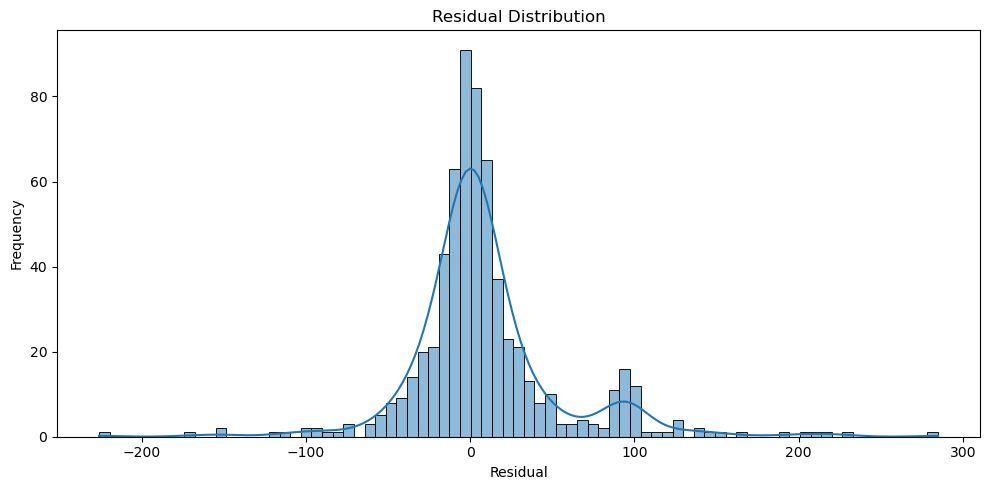

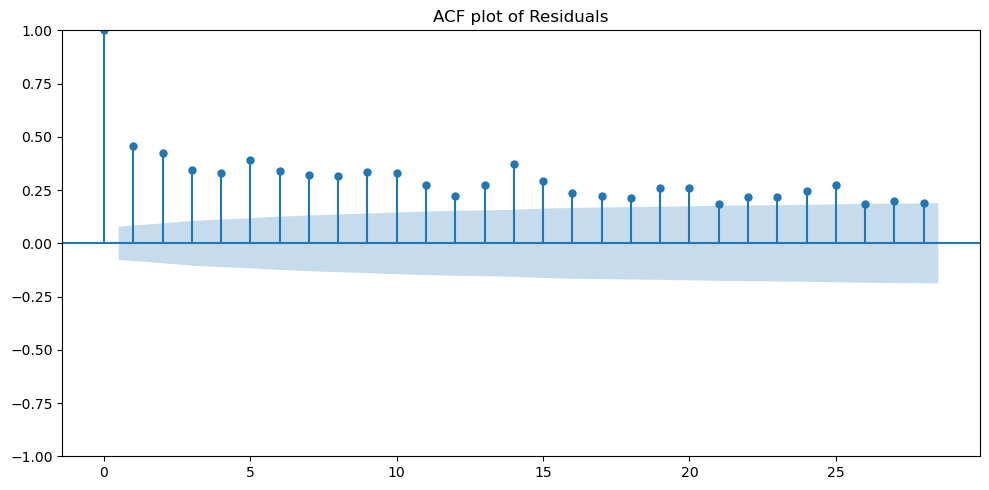

Evidence of auocorrelation at lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
caterpillar_arima_residuals = residual_diagnostics(caterpillar_arima_model, lags=52)

**Residuals Diagnostics**
- A histogram plot of the residuals indicated they do not have a normal distribution, as supported by the JB test.
- An ACF plot of the residuals indicate that autocorrelation in the residuals/ noise from heterskedascity and that potentially there is some structure the model has failed to capture.
- In addition, Ljungbox test of lag=52 indicates there is evidence of autocorrelation in the residuals suggesting the model has not captured all of the underlying structure.
- Further parameter changes are required- test differencing despite the ADF test suggesting the data was stationary.

In [ ]:
# Define model path.
caterpillar_path = 'models/caterpillar_arima_model_2.pkl'

# Set the model parameters.
caterpillar_kwargs = caterpillar_kwargs | {'d': 1}

# Train the model (multiplicative so use_log=True with differencing).
caterpillar_arima_model_2 = load_or_fit_arima(caterpillar_path, caterpillar_train_arima, use_log=False, use_boxcox=True, **caterpillar_kwargs)

Model Found. Loading: models/caterpillar_arima_model_2.pkl


In [ ]:
# View the best model summary.
caterpillar_arima_model_2.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  623
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -2872.494
Date:                            Mon, 18 Aug 2025   AIC                           5748.987
Time:                                    13:37:49   BIC                           5757.678
Sample:                                         0   HQIC                          5752.378
                                            - 623                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.4547      0.013    -34.641      0.000      -0.480      -0.429
sigma2      1366.4816     23.142     59.049      0.000    1321.125    1411.838
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):             12242.97
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               9.67   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- All AR and seasonal AR coefficients are significant (p < 0.05), indicating they contribute meaningfully to the model.
- **Ljung–Box** test p-value = 0.40 (p > 0.05) suggests no significant autocorrelation in residuals at lag 1.
- **Jarque–Bera** test p-value = 0.00 (p < 0.001) indicates the residuals are not normally distributed, confirmed by extremely high kurtosis = 19.71.
- **Heteroskedasticity** p-value = 0.00 (p < 0.001) suggests residual variance is not constant, with skew = 0.77 indicating positive skewness.

**Interpretation**
- The model effectively captures the main autocorrelation structure, including annual seasonality, but the residuals show heavy-tailed, skewed behavior and heteroskedasticity.
- These characteristics point to occasional large seasonal peaks or volatility shifts that the current AR(1) × SAR(1) structure does not fully explain

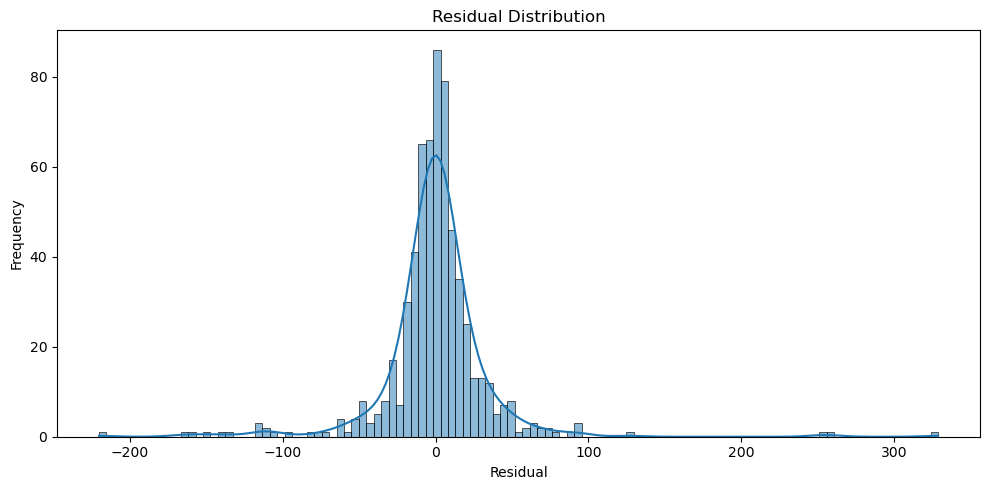

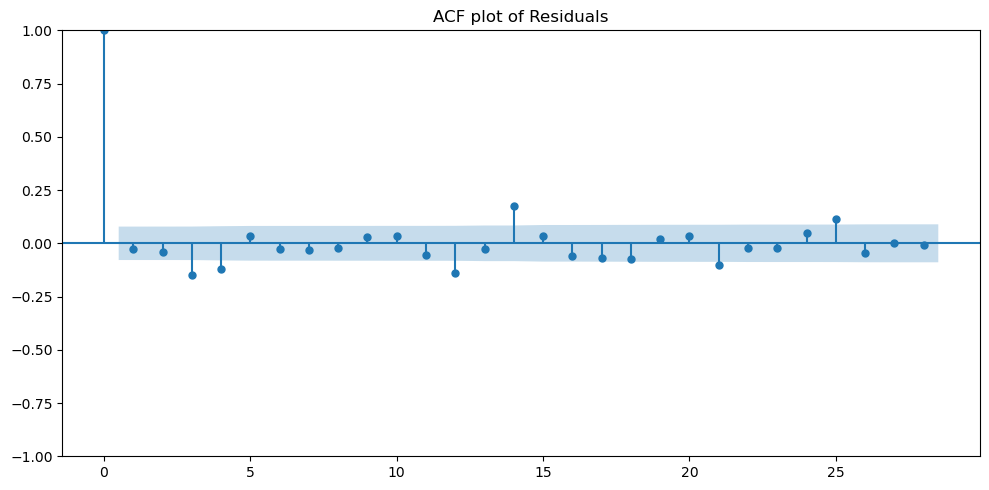

Evidence of auocorrelation at lags: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
caterpillar_arima_residuals_2 = residual_diagnostics(caterpillar_arima_model_2, lags=52)

**Note:** increasing max_P / max_Q was tested to address the autocorrelation observed at lag 52, however, this lead to non-convergence of the model. Future work will be to investigate fourier terms.

- While evidence of autocorrelation remains at lags [3–52] (α = 0.05), the magnitude of these correlations is greatly reduced compared to the initial model, indicating improvement.
- The ACF plot and histogram show that all short-lag autocorrelation has been effectively removed, with only weaker longer-lag seasonal effects persisting.
- The histogram now exhibits a tighter clustering around zero and greater symmetry, although some heavy tails remain. Extreme residual values are less frequent, indicating improved variance control.
- Overall, the residuals are more like white noise than in the initial model, showing that the model captures the underlying structure more effectively despite the remaining seasonal autocorrelation.

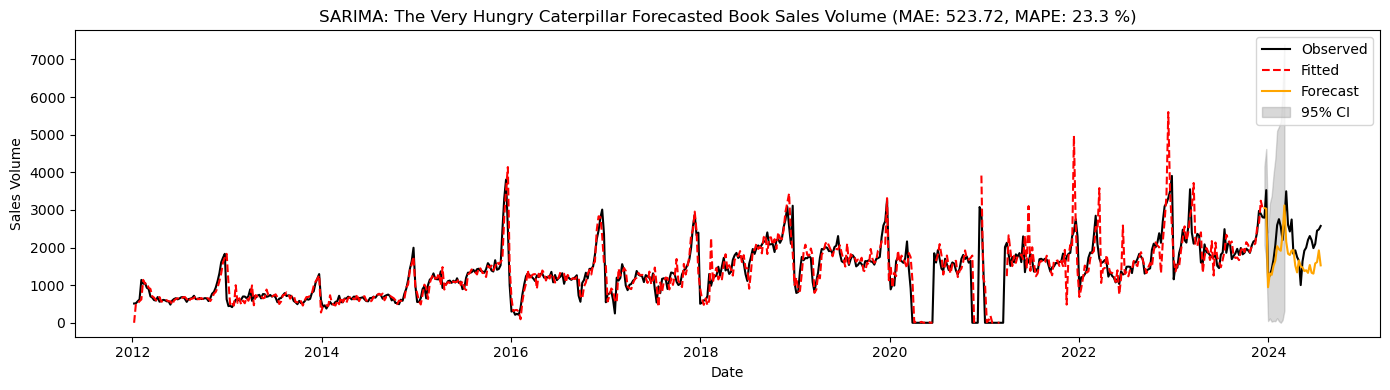

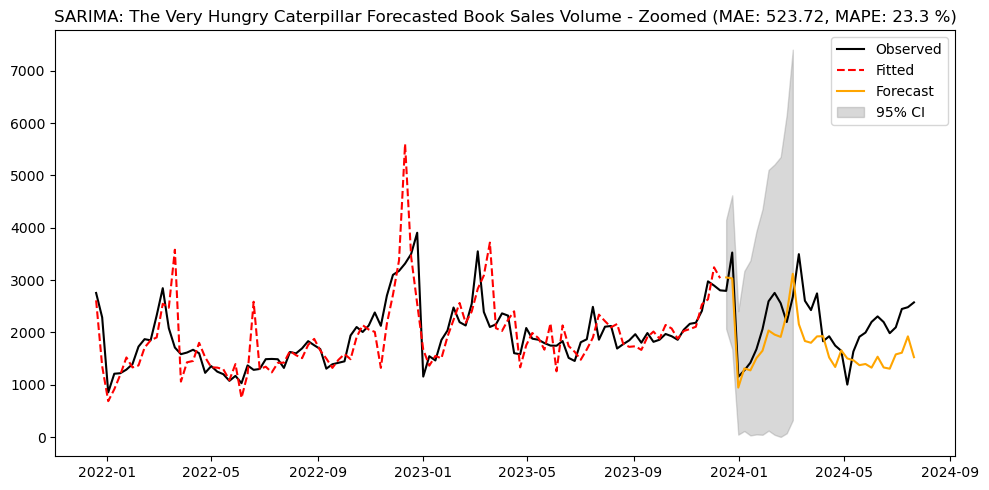

In [ ]:
# Forecast and plot the results.
caterpillar_title = 'SARIMA: The Very Hungry Caterpillar Forecasted Book Sales Volume'
caterpillar_arima_pred, caterpillar_arima_mae, caterpillar_arima_mape = forecast_and_plot_arima(caterpillar_arima_model_2, caterpillar_arima, caterpillar_train_arima, caterpillar_test_arima, caterpillar_title)

- The fitted values (red dashed line) closely follow the observed data during the training period, capturing the general seasonal peaks and troughs, though extreme spikes are often over- or under-estimated.
- The forecast (orange line) maintains the seasonal pattern but shows a slight downward drift from the last observed peak before levelling off.
- The confidence intervals widen substantially over time, indicating increasing uncertainty further into the forecast horizon.
- The model’s MAE (523.72) and MAPE (23.3%) indicate a moderate level of accuracy, with errors likely driven by the model’s difficulty in fully capturing sharp seasonal spikes.

# **5. Machine Learning Model: XGBoost**

## **5.1 Functions**

In [ ]:
# Create a transformer that shifts the data to ensure no zeros.
class PositiveShift(BaseTransformer):
    def __init__(self, min_positive=1e-6):
        self.min_positive = min_positive
        super().__init__()

    def fit(self, y, X=None):
        y_arr = y.to_numpy() if hasattr(y, 'to_numpy') else np.asarray(y)
        y_min = float(np.nanmin(y_arr))
        self.shift_ = 0.0 if y_min > 0 else (self.min_positive - y_min)
        return self

    def transform(self, y, X=None):
        return y + self.shift_

    def inverse_transform(self, y, X=None):
        return y - self.shift_

In [ ]:
# Function to create an XGBoost pipeline.
def xgboost_pipeline(sp, seasonal_model):

    steps = []
    regressor = XGBRegressor(verbosity=0, eval_metric='mae', random_state=seed)

    if seasonal_model == 'multiplicative':
        steps.append(('shift', PositiveShift(1e-6)))

    steps.append(('deseason', Deseasonalizer(model=seasonal_model, sp=sp))),

    steps.append(('detrend', Detrender(PolynomialTrendForecaster(degree=1))))

    steps.append(('xgb', make_reduction(regressor, window_length=12, strategy='recursive')))

    return TransformedTargetForecaster(steps)

In [ ]:
def train_or_load_xgb_model(train, param_grid, model_path, fh, sp, seasonal_model):

    # If the model already exists, load it.
    if os.path.exists(model_path):
        print(f'Loading existing model from {model_path}')
        best_forecaster = joblib.load(model_path)
    else:
        print('No model found. Training new model!')

        predictor = xgboost_pipeline(sp=sp, seasonal_model=seasonal_model)
        cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
        gscv = ForecastingGridSearchCV(
        predictor,
        strategy='refit',
        cv=cv,
        param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True),
        n_jobs=-1,
        error_score='raise'
    )

        gscv.fit(train, fh=fh)
        print(f'Best Parameters {gscv.best_params_}')
        best_forecaster = gscv.best_forecaster_

        # Save best model to file.
        joblib.dump(best_forecaster, model_path)
        print(f'Model Saved to {model_path}')

    return best_forecaster

In [ ]:
def forecast_and_plot_xgb(y_test, model, fh, y_full, title):

    y_pred = model.predict(fh=fh)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    y_pred.index = y_pred.index.to_timestamp()

    plt.figure(figsize=(12, 6))
    plt.plot(y_full, label='Observed', color='black')
    plt.plot(y_pred, label= 'Forecasted', color='orange')
    plt.title(f'{title} (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    X = y_test.copy()
    X.index = X.index.to_timestamp() if isinstance(X.index, pd.PeriodIndex) else X.index
    zoom_start = X.index[0] - pd.Timedelta(weeks=104)
    zoom_end = X.index[-1]
    zoom = y_full[(y_full.index >= zoom_start) & (y_full.index <= zoom_end)]

    plt.plot(zoom, label='Observed', color='black')
    plt.plot(y_pred, label= 'Forecasted', color='orange')
    plt.title(f'{title} - Zoomed (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred, mae, mape

## **5.2 Data Preparation**

In [ ]:
# Full time series.
alchemist_xgb = alchemist_arima.copy()
caterpillar_xgb = caterpillar_arima.copy()

# Split into training and test sets.
print('The Alchemist:')
alchemist_train_xgb, alchemist_test_xgb = train_test(alchemist_xgb, forecast_horizon=fh_weekly)
print()
print('The Very Hungry Caterpillar:')
caterpillar_train_xgb, caterpillar_test_xgb = train_test(caterpillar_xgb, forecast_horizon=fh_weekly)

The Alchemist:
Training Period: 2012-01-08 to 2023-12-10 (623)
Test Period: 2023-12-17 to 2024-07-21 (32)

The Very Hungry Caterpillar:
Training Period: 2012-01-08 to 2023-12-10 (623)
Test Period: 2023-12-17 to 2024-07-21 (32)


In [ ]:
# Set index frequency.
alchemist_train_xgb.index = alchemist_train_xgb.index.to_period('W')
alchemist_test_xgb.index = alchemist_test_xgb.index.to_period('W')

caterpillar_train_xgb.index = caterpillar_train_xgb.index.to_period('W')
caterpillar_test_xgb.index = caterpillar_test_xgb.index.to_period('W')

In [ ]:
# Set the parameter grid for grid search.
param_grid = {
    'xgb__window_length': [6, 12, 24],
    'xgb__estimator__n_estimators': [100, 300],
    'xgb__estimator__max_depth': [3, 5, 7],
    'xgb__estimator__gamma': [0, 0.1, 0.3]
}

## **5.3 Modelling**

### **5.3.1 The Alchemist**

- Guided by the decomposition results, an additive model was adopted for XGBoost.
- The best XGBoost model was identified by performing a grid search over the following hyperparameters: window length, n_estimators, max_depth and gamma.
- Validation method used was expanding window time-series cross validation.

In [ ]:
# Identify the best XGBoost model by performing a grid search.
alchemist_path = 'models/alchemist_xgb_model.pkl'
fh = np.arange(1, len(alchemist_test_xgb) + 1)

alchemist_xgb_model = train_or_load_xgb_model(alchemist_train_xgb, param_grid, alchemist_path, fh, sp=52, seasonal_model='additive')

Loading existing model from models/alchemist_xgb_model.pkl


In [ ]:
# Function to extract the best hyperparameters.
def chosen_params_from_grid(all_params, param_grid):
    keys = set().union(*param_grid) if isinstance(param_grid, list) else set(param_grid)
    return {k: all_params.get(k) for k in keys}

In [ ]:
# View the best hyperparameters if model loaded.
if os.path.exists(alchemist_path):
    all_params = alchemist_xgb_model.get_params(deep=True)
    pprint.pprint(chosen_params_from_grid(all_params, param_grid))

{'xgb__estimator__gamma': 0,
 'xgb__estimator__max_depth': 7,
 'xgb__estimator__n_estimators': 100,
 'xgb__window_length': 12}


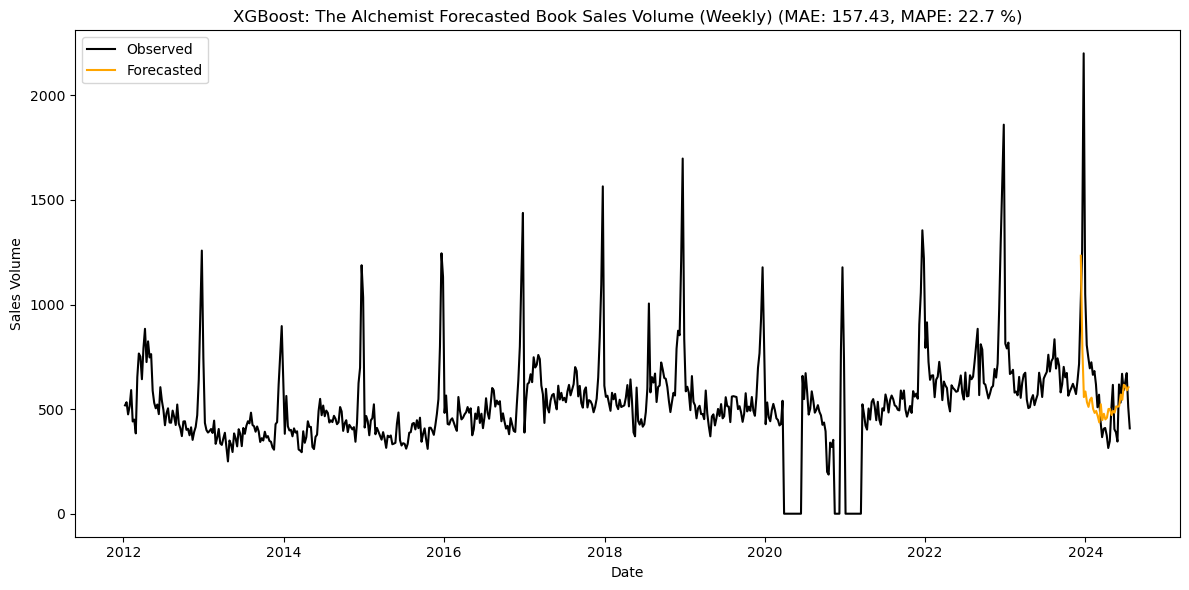

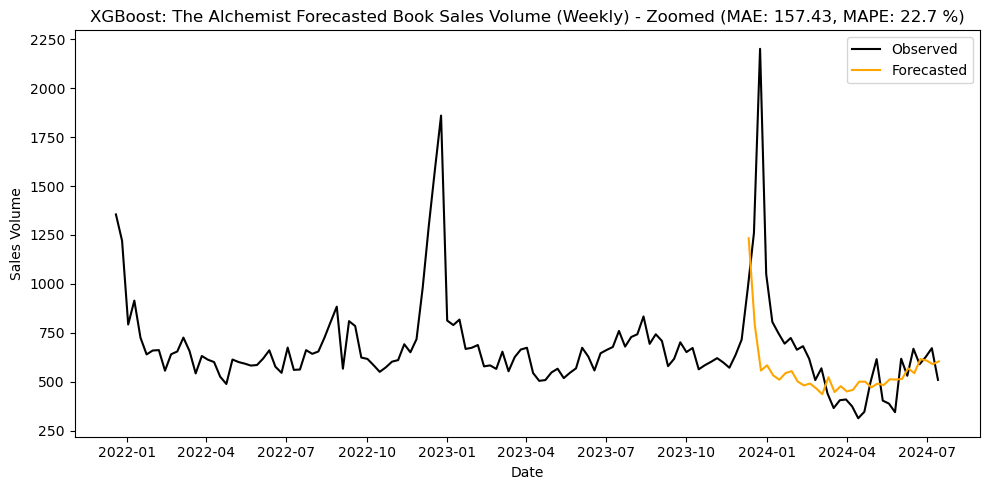

In [ ]:
# Forecast and plot the sales data.
alchemist_title = 'XGBoost: The Alchemist Forecasted Book Sales Volume (Weekly)'
alchemist_xgb_pred, alchemist_xgb_mae, alchemist_xgb_mape = forecast_and_plot_xgb(alchemist_test_xgb, alchemist_xgb_model, fh, alchemist_xgb, alchemist_title)

- The forecast (orange) tracks the broad post-spike decline then gradual recovery but the weekly volatility appears to be smoothed out.
- It misses the extreme January 2024 spike which suggests that the model is capturing level and trend but not seasonal effects.
- The models MAE (157.43) and MAPE (22.7%) indicate a moderate level of accuracy.

### **5.3.2 The Very Hungry Caterpillar**

- Guided by the decomposition results, a multiplicative model was adopted for XGBoost.
- The XGBoost model was identified by performing a grid search over the parameters: window length, n_estimators, max_depth and gamma.
- Validation method used was expanding window time-series cross validation.

In [ ]:
# Identify the best XGBoost model by performing a grid search.
caterpillar_path = 'models/caterpillar_xgb_model.pkl'
fh = np.arange(1, len(caterpillar_test_xgb) + 1)

caterpillar_xgb_model = train_or_load_xgb_model(caterpillar_train_xgb, param_grid, caterpillar_path, fh, sp=52, seasonal_model='multiplicative')

Loading existing model from models/caterpillar_xgb_model.pkl


In [ ]:
# View the best hyperparameters if model loaded.
if os.path.exists(caterpillar_path):
    all_params = caterpillar_xgb_model.get_params(deep=True)
    pprint.pprint(chosen_params_from_grid(all_params, param_grid))

{'xgb__estimator__gamma': 0,
 'xgb__estimator__max_depth': 3,
 'xgb__estimator__n_estimators': 100,
 'xgb__window_length': 6}


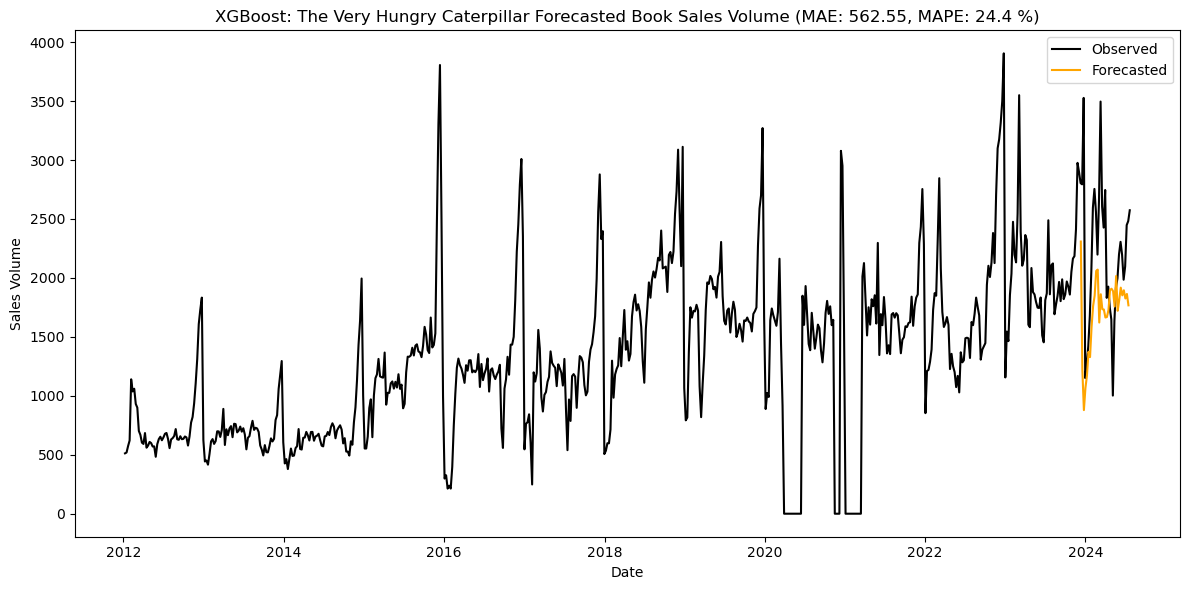

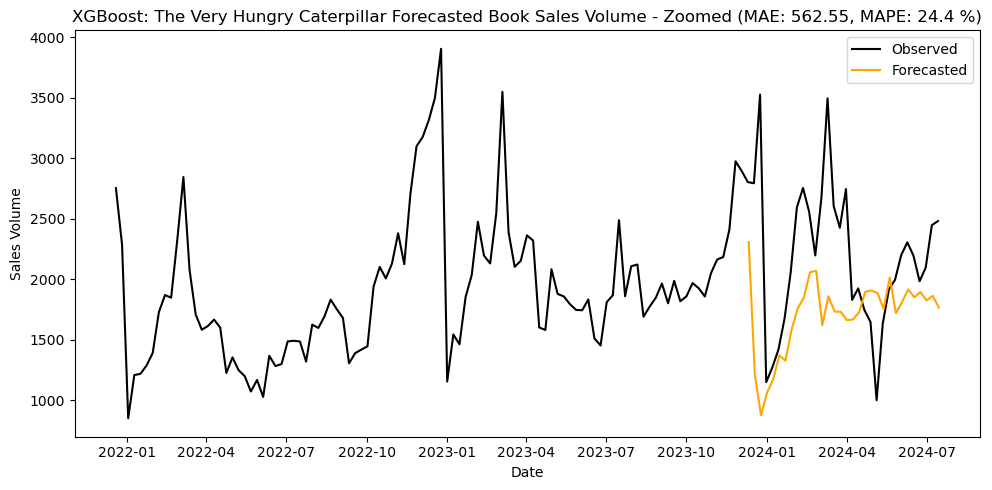

In [ ]:
# Forecast the sales data.
caterpillar_title = 'XGBoost: The Very Hungry Caterpillar Forecasted Book Sales Volume'
caterpillar_xgb_pred, caterpillar_xgb_mae, caterpillar_xgb_mape = forecast_and_plot_xgb(caterpillar_test_xgb, caterpillar_xgb_model, fh, caterpillar_xgb, caterpillar_title)

- The forecast (orange) follows the post-holiday recovery and broad upward rise in sales but smoooths out the sharp week-to week differences
- Through Feb-May the forecats are systematically low-biased and they misse the big sales surges in this time period.
- This suggests the model captures the level and trend but not event driven or seasonal spikes.
- The models MAE (562.55) and MAPE (24.4%) indicate a moderate level of accuracy but error likely driven by low-bias.

# **6. Deep Learning Model: LSTM**

## **6.1 Functions**

In [ ]:
# Function to split the data chronologically into training, test and validation set.
def split_lstm(data, forecast_horizon, periods=True):
    all_train_lstm = data.iloc[:-forecast_horizon]
    test_lstm = data.iloc[-forecast_horizon:]

    val_size = int(len(all_train_lstm) * 0.2)
    train_lstm = all_train_lstm[:-val_size]
    val_lstm = all_train_lstm[-val_size:]

    if periods:
        print(f'Training Period: {train_lstm.index.min().date()} to {train_lstm.index.max().date()} ({train_lstm.shape[0]})')
        print(f'Validation Period: {val_lstm.index.min().date()} to {val_lstm.index.max().date()} ({val_lstm.shape[0]})')
        print(f'Test Period: {test_lstm.index.min().date()} to {test_lstm.index.max().date()} ({test_lstm.shape[0]})')

    return train_lstm, test_lstm, val_lstm

In [ ]:
# Function to reshape and normalise the data.
def reshape_normalise_transform(train, val, target_col='volume', multiplicative=False):

   train = np.asarray(train[target_col], dtype=float)
   val = np.asarray(val[target_col], dtype=float)

   scaler = StandardScaler()

   if multiplicative:
      lam = stats.boxcox_normmax(train + 1.0, method='mle')
      train_transformed = boxcox1p(train, lam)
      val_transformed = boxcox1p(val, lam)

      train_scaled = scaler.fit_transform(train_transformed.reshape(-1, 1))
      val_scaled = scaler.transform(val_transformed.reshape(-1, 1))

      return train_scaled, val_scaled, scaler, lam

   else:
      train_scaled = scaler.fit_transform(train.reshape(-1, 1))
      val_scaled = scaler.transform(val.reshape(-1, 1))

      return train_scaled, val_scaled, scaler, None

In [ ]:
# Function to create input and output sequences for train, validation and test set.
def create_sequences_lstm(lookback, forecast, sequence_data):
    input_sequences = []
    output_sequences = []

    for i in range(lookback, len(sequence_data) - forecast + 1):
        input_sequences.append(sequence_data[i - lookback : i])
        output_sequences.append(sequence_data[i: i + forecast])

    return {'input_sequences': input_sequences, 'output_sequences': output_sequences}

In [ ]:
# Define the keras tuner model framework.
tf.keras.backend.clear_session()
multi_step_lookback = 52
multi_step_forecast = 32

def lstm_tuned_model(hp):
    model = Sequential()

    model.add(LSTM(hp.Int('input_unit', min_value=4, max_value=128, step=8), return_sequences=True, input_shape=(52, 1))) # input layer

    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=4, max_value=128, step=8), return_sequences=True)) # tune the number of extra LSTM layers

    model.add(LSTM(hp.Int('final_layer_units', min_value=4, max_value=128, step=8))) # final LSTM layer
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1))) # tune the dropout rate
    model.add(Dense(multi_step_forecast)) # output layer

    model.compile(loss=Huber(delta=1.0), optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 5e-4, 1e-4])), metrics=['mae'])

    return model

In [ ]:
# Define function to train or load lstm model.
def train_or_load_lstm_model(model_path, lstm_framework, train_input, train_output, val_input, val_output):

    # If the model already exists, load it.
    if os.path.exists(model_path):
        print(f'Loading existing model from {model_path}')
        best_lstm_model = load_model(model_path, compile=False)
        json_path = os.path.splitext(model_path)[0] + "_best_hp.json"
        with open(json_path, 'r') as f:
            best_hyperparameters = json.load(f)
    else:
        print('No model found. Training new model!')

        # Set seed.
        tf.random.set_seed(42)
        np.random.seed(42)
        random.seed(42)

        # Define the tuner.
        tuner = RandomSearch(
            lstm_framework,
            objective='val_mae',
            max_trials=20,
            executions_per_trial=3,
            directory='kt_runs',
            project_name=f'run_{int(time.time())}',
            overwrite=True
            )

        # Define early stopping callback.
        early_stop = EarlyStopping(
            monitor='val_mae',
            patience=25,
            restore_best_weights=True
            )

        # Hyperparameter search.
        tuner.search(
            x=train_input,
            y=train_output,
            epochs=500,
            batch_size=32,
            callbacks=[early_stop],
            validation_data=(val_input, val_output),
            shuffle=False,
            verbose=0
        )

        # Obtain the best parameters.
        best_hyperparameters = tuner.get_best_hyperparameters()[0].values
        json_path = os.path.splitext(model_path)[0] + "_best_hp.json"
        with open(json_path, 'w') as f:
            json.dump(best_hyperparameters, f, indent=4)

        # Obtain the best model.
        best_lstm_model = tuner.get_best_models(num_models=1)[0]

        # Save the best model.
        print(f'Saving the best model to {model_path}')
        best_lstm_model.save(model_path, include_optimizer=False)

    return best_hyperparameters, best_lstm_model

In [ ]:
# Function to make predictions.
def lstm_forecast_and_plot(model, last_available_input_sequence, scaler, test, title, y_full, multiplicative=False, boxcox_lam=None):

    # Predict and inverse scale
    y_pred = model.predict(last_available_input_sequence, verbose=0)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    y_pred = scaler.inverse_transform(y_pred).ravel()

    # Inverse boxcox if used.
    if multiplicative:
        if boxcox_lam is not None:
            y_pred = inv_boxcox1p(y_pred, boxcox_lam)

    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred) * 100

    # Plot the results.
    y_pred = np.asarray(y_pred).reshape(-1)
    y_pred = pd.Series(y_pred, index=test.index, name='Forecast')

    plt.figure(figsize=(12, 6))
    plt.title(f'{title} (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.plot(y_full, label='Observed Data', color='black')
    plt.plot(y_pred, label='Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Zoomed in plot.
    zoom_start = test.index[0] - pd.Timedelta(weeks=104)
    zoom_end = test.index[-1]
    zoom = y_full[(y_full.index >= zoom_start) & (y_full.index <= zoom_end)]

    plt.title(f'{title} - Zoomed (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.plot(zoom, label='Observed', color='black')
    plt.plot(y_pred, label='Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred, mae, mape

## **6.2 Data Preparation**

In [ ]:
# Set the seed.
tf.random.set_seed(seed)

In [ ]:
# Create a copy of the data.
alchemist_lstm = alchemist_xgb.copy()
caterpillar_lstm = caterpillar_xgb.copy()

# Create the alchemist training, test and validation set.
alchemist_train_lstm, alchemist_test_lstm, alchemist_val_lstm = split_lstm(alchemist_lstm, forecast_horizon=fh_weekly)

Training Period: 2012-01-08 to 2021-07-25 (499)
Validation Period: 2021-08-01 to 2023-12-10 (124)
Test Period: 2023-12-17 to 2024-07-21 (32)


In [ ]:
# Create caterpillar training test and validation set.
caterpillar_train_lstm, caterpillar_test_lstm, caterpillar_val_lstm = split_lstm(caterpillar_lstm, forecast_horizon=fh_weekly)

Training Period: 2012-01-08 to 2021-07-25 (499)
Validation Period: 2021-08-01 to 2023-12-10 (124)
Test Period: 2023-12-17 to 2024-07-21 (32)


In [ ]:
# Reshape and normalise the data.
alchemist_train_scaled, alchemist_val_scaled, alchemist_scaler, _ = reshape_normalise_transform(alchemist_train_lstm, alchemist_val_lstm, target_col='volume', multiplicative=False)

caterpillar_train_scaled, caterpillar_val_scaled, caterpillar_scaler, caterpillar_lam = reshape_normalise_transform(caterpillar_train_lstm, caterpillar_val_lstm, target_col='volume', multiplicative=True)

In [ ]:
# Set forecast and lookback.
multi_step_lookback = 52
multi_step_forecast = 32

# Alchemist training sequences.
alchemist_train_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, alchemist_train_scaled)
X_alchemist_train = np.array(alchemist_train_sequences['input_sequences'])
y_alchemist_train = np.array(alchemist_train_sequences['output_sequences'])

# Alchemist validation sequences.
alchemist_val_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, alchemist_val_scaled)
X_alchemist_val = np.array(alchemist_val_sequences['input_sequences'])
y_alchemist_val = np.array(alchemist_val_sequences['output_sequences'])

# Reshape outputs.
y_alchemist_train_vec = y_alchemist_train.squeeze(-1)
y_alchemist_val_vec = y_alchemist_val.squeeze(-1)

# Alchemist last available input sequence.
alchemist_train_val_scaled = np.concatenate([alchemist_train_scaled, alchemist_val_scaled])
alchemist_la_input_sequence = alchemist_train_val_scaled[-multi_step_lookback:] # last available input sequence
alchemist_la_input_sequence = alchemist_la_input_sequence.reshape(1, multi_step_lookback, 1)

# View the training sequence shape.
print('Input sequence shape:', X_alchemist_train.shape)
print('Output sequence shape:', y_alchemist_train_vec.shape)


Input sequence shape: (416, 52, 1)
Output sequence shape: (416, 32)


In [ ]:
# Caterpillar training sequences.
caterpillar_train_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, caterpillar_train_scaled)
X_caterpillar_train = np.array(caterpillar_train_sequences['input_sequences'])
y_caterpillar_train = np.array(caterpillar_train_sequences['output_sequences'])

# Caterpillar validation sequences.
caterpillar_val_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, caterpillar_val_scaled)
X_caterpillar_val = np.array(caterpillar_val_sequences['input_sequences'])
y_caterpillar_val = np.array(caterpillar_val_sequences['output_sequences'])

# Reshape outputs.
y_caterpillar_train_vec = y_caterpillar_train.squeeze(-1)
y_caterpillar_val_vec = y_caterpillar_val.squeeze(-1)

# Caterpillar last available input sequence.
caterpillar_train_val_scaled = np.concatenate([caterpillar_train_scaled, caterpillar_val_scaled])
caterpillar_la_input_sequence = caterpillar_train_val_scaled[-multi_step_lookback:] # last available input sequence
caterpillar_la_input_sequence = caterpillar_la_input_sequence.reshape(1, multi_step_lookback, 1)

# View the training sequence shape.
print('Input sequence shape:', X_caterpillar_train.shape)
print('Output sequence shape:', y_caterpillar_train_vec.shape)

Input sequence shape: (416, 52, 1)
Output sequence shape: (416, 32)


## **6.3 Modelling**

### **6.3.1 The Alchemist**

- The best LSTM model was identified using KerasTuner RandomSearch to optimise validation MAE, with early stopping up to 500 epochs.
- Validation used a single hold-out validation set (test set).

In [ ]:
# Train the LSTM model using KerasTuner.
alchemist_path = 'models/alchemist_lstm_model.h5'

alchemist_lstm_hp, alchemist_lstm_model =  train_or_load_lstm_model(
    alchemist_path,
    lstm_tuned_model,
    X_alchemist_train,
    y_alchemist_train_vec,
    X_alchemist_val,
    y_alchemist_val_vec
    )

Loading existing model from models/alchemist_lstm_model.h5


2025-08-18 13:37:51.335286: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-18 13:37:51.335471: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-18 13:37:51.335628: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-18 13:37:51.335820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-18 13:37:51.336015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# View the best hyperparameters.
print(alchemist_lstm_hp)

{'input_unit': 108, 'n_layers': 4, 'lstm_0_units': 36, 'final_layer_units': 84, 'Dropout_rate': 0.1, 'lr': 0.0005, 'lstm_1_units': 4, 'lstm_2_units': 4, 'lstm_3_units': 4}


In [ ]:
# Obtain the layers of the best model.
for layer in alchemist_lstm_model.layers:
    print(layer.name, layer.output.shape)

lstm (None, 52, 108)
lstm_1 (None, 52, 36)
lstm_2 (None, 52, 4)
lstm_3 (None, 52, 4)
lstm_4 (None, 52, 4)
lstm_5 (None, 84)
dropout (None, 84)
dense (None, 32)


In [ ]:
# View the model summary.
alchemist_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 108)           47520     
                                                                 
 lstm_1 (LSTM)               (None, 52, 36)            20880     
                                                                 
 lstm_2 (LSTM)               (None, 52, 4)             656       
                                                                 
 lstm_3 (LSTM)               (None, 52, 4)             144       
                                                                 
 lstm_4 (LSTM)               (None, 52, 4)             144       
                                                                 
 lstm_5 (LSTM)               (None, 84)                29904     
                                                                 
 dropout (Dropout)           (None, 84)                0

2025-08-18 13:37:52.580333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


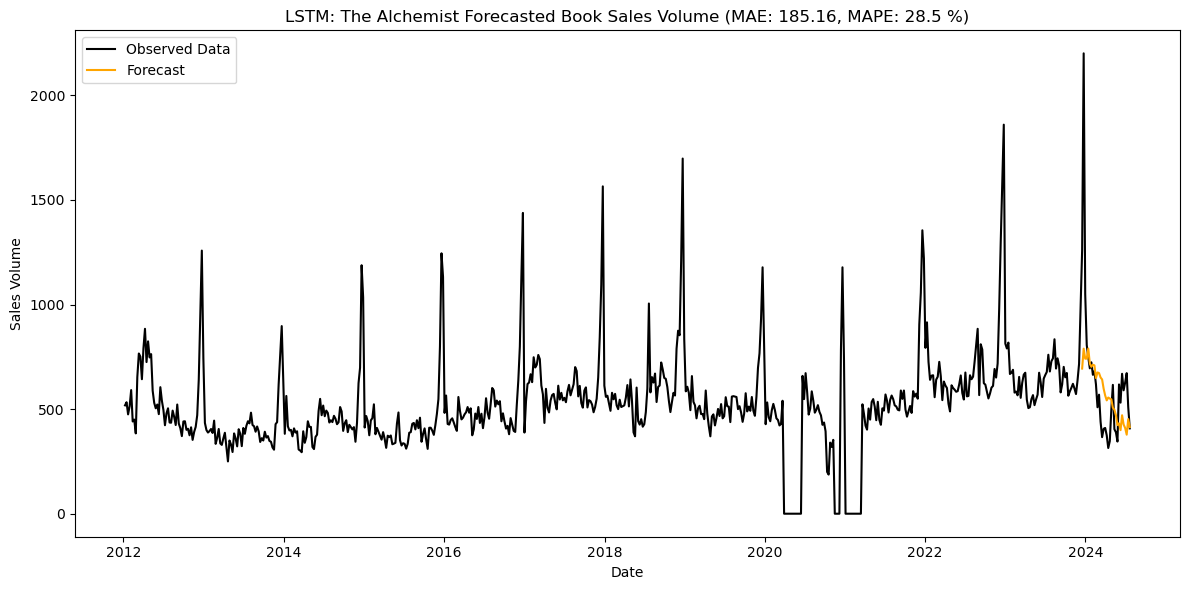

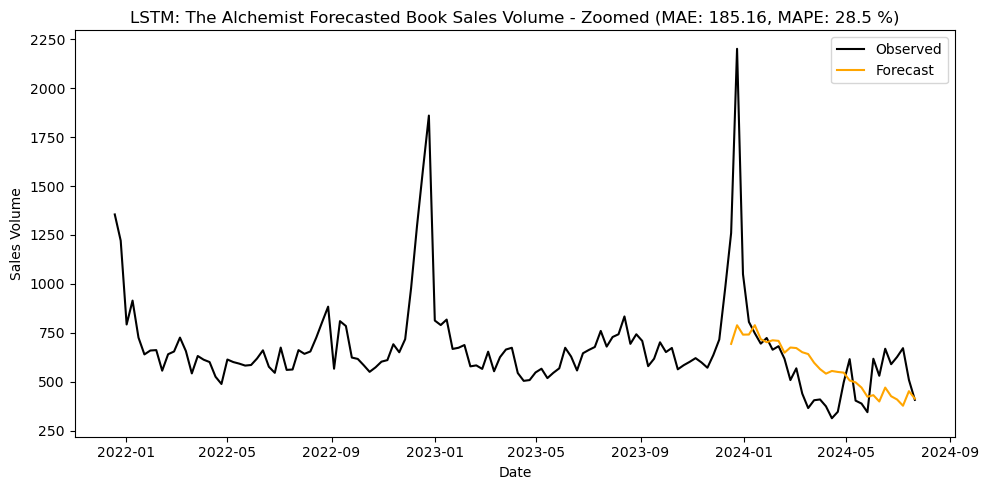

In [ ]:
# Make predictions.
alchemist_title = 'LSTM: The Alchemist Forecasted Book Sales Volume'
alchemist_lstm_pred, alchemist_lstm_mae, alchemist_lstm_mape = lstm_forecast_and_plot(
    alchemist_lstm_model,
    alchemist_la_input_sequence,
    alchemist_scaler,
    alchemist_test_lstm,
    alchemist_title,
    alchemist_lstm,
    multiplicative=False
    )

- The forecast (orange) is over-smoothed and it misses the extreme Jan 2024 spike.
- Bias shifts to over prediction immediately after the spike (Feb-Mar) and then under prediciton as the sales recover in late spring/summer.
- This pattern sugests the LSTM is capturing level but not event driven/ seasonal spikes indicated by the poorer model accuracy (MAE: 185.16, MAPE: 28.5%)

### **6.3.2 The Very Hungry Caterpillar**

- Guided by the decomposition results, the model was trained on variance stabilised data via the Box-Cox transformation to address multiplicative seasonality.
- The best LSTM model was identified using KerasTuner RandomSearch to optimisation validation MAE, with early stopping up to 500 epochs.
- Validation used a single hold-out validation set (test set).

In [ ]:
# Train the LSTM model.
caterpillar_path = 'models/caterpillar_lstm_model.h5'

caterpillar_lstm_hp, caterpillar_lstm_model =  train_or_load_lstm_model(
    caterpillar_path,
    lstm_tuned_model,
    X_caterpillar_train,
    y_caterpillar_train_vec,
    X_caterpillar_val,
    y_caterpillar_val_vec
    )

Loading existing model from models/caterpillar_lstm_model.h5


In [ ]:
# View the best hyperparameters.
print(caterpillar_lstm_hp)

{'input_unit': 76, 'n_layers': 3, 'lstm_0_units': 100, 'final_layer_units': 44, 'Dropout_rate': 0.2, 'lr': 0.001, 'lstm_1_units': 100, 'lstm_2_units': 76, 'lstm_3_units': 28}


In [ ]:
# Obtain the layers of the best model.
for layer in caterpillar_lstm_model.layers:
    print(layer.name, layer.output.shape)

lstm (None, 52, 76)
lstm_1 (None, 52, 100)
lstm_2 (None, 52, 100)
lstm_3 (None, 52, 76)
lstm_4 (None, 44)
dropout (None, 44)
dense (None, 32)


In [ ]:
# View the model summary.
caterpillar_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 76)            23712     
                                                                 
 lstm_1 (LSTM)               (None, 52, 100)           70800     
                                                                 
 lstm_2 (LSTM)               (None, 52, 100)           80400     
                                                                 
 lstm_3 (LSTM)               (None, 52, 76)            53808     
                                                                 
 lstm_4 (LSTM)               (None, 44)                21296     
                                                                 
 dropout (Dropout)           (None, 44)                0         
                                                                 
 dense (Dense)               (None, 32)                1

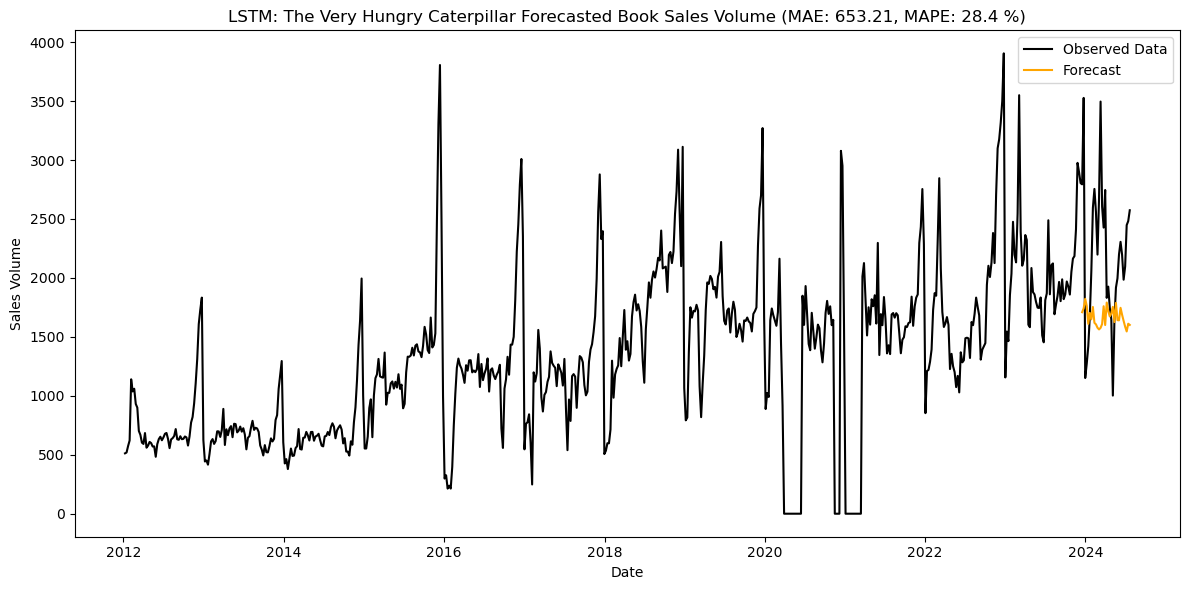

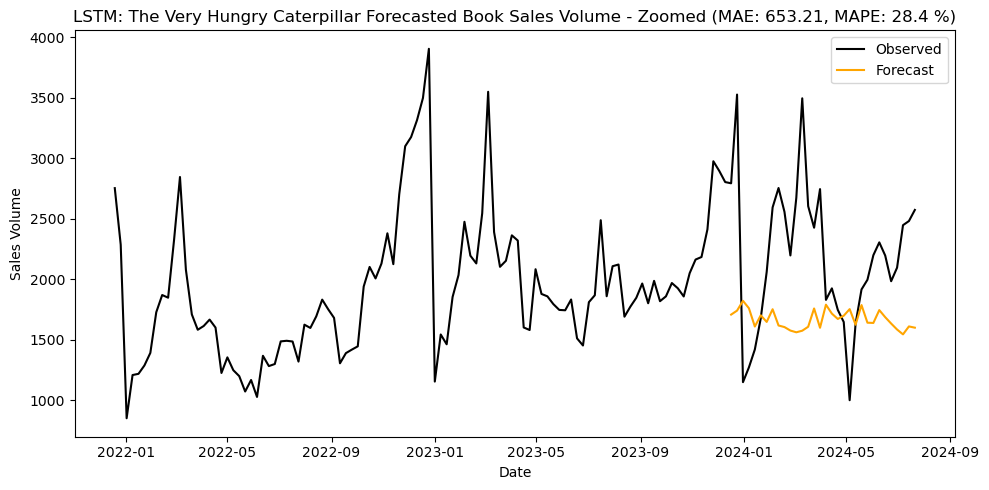

In [ ]:
# Make predictions.
caterpillar_title = 'LSTM: The Very Hungry Caterpillar Forecasted Book Sales Volume'
caterpillar_lstm_pred, caterpillar_lstm_mae, caterpillar_lstm_mape = lstm_forecast_and_plot(
    caterpillar_lstm_model,
    caterpillar_la_input_sequence,
    caterpillar_scaler,
    caterpillar_test_lstm,
    caterpillar_title,
    caterpillar_lstm,
    multiplicative=True,
    boxcox_lam=caterpillar_lam)

- The forecast (orange) smooths out the large week to week swings and misses major spikes and deep dips which is reflected in the larger error (MAE = 653.21, MAPE = 28.4% )
- Pattern suggests it captued level post holidays but not event driven or seasonal spikes

# **7. Hybrid Models: Sequential SARIMA + LSTM**

## **7.1 Functions**

In [ ]:
# Function to make hybrid predictions.
def sequential_forecast_plot(model, last_available_input_sequence, scaler, forecast, ts_test, title, y_full):

    # Make residual predictions (with inverse transformations)
    res_pred_scaled = model.predict(last_available_input_sequence)
    res_pred_scaled = res_pred_scaled.reshape(-1, 1)
    res_pred = scaler.inverse_transform(res_pred_scaled).ravel()

    # Combine forecast with residual predictions.
    sequential_pred = forecast + res_pred

    # Calculate mae and mape.
    mae = mean_absolute_error(ts_test, sequential_pred)
    mape = mean_absolute_percentage_error(ts_test, sequential_pred) * 100

    # Plot the predictions.
    idx = ts_test.index
    y_pred = pd.Series(np.asarray(sequential_pred).reshape(-1), index=idx, name='Forecast')

    plt.figure(figsize=(12, 6))
    plt.title(f'{title} (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.plot(y_full, label='Observed Data', color='black')
    plt.plot(y_pred, label='Forecasted Values', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Zoomed plot.
    zoom_start = ts_test.index[0] - pd.Timedelta(weeks=104)
    zoom_end = ts_test.index[-1]
    zoom = y_full[(y_full.index >= zoom_start) & (y_full.index <= zoom_end)]

    plt.title(f'{title} - Zoomed (MAE: {mae:.2f}, MAPE: {mape:.1f} %)')
    plt.plot(zoom, label='Observed', color='black')
    plt.plot(y_pred, label='Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mae, mape

## **7.2 Data Preparation**

### **7.2.1 The Alchemist**

The residuals from the trained SARIMA model are stored in alchemist_arima_residuals_2. These residuals will be forecated using LSTM and the final prediction will be the sum of the predictions from the SARIMA and LSTM (residual predictions).

In [ ]:
# Format the alchemist residuals as a dataframe.
alchemist_arima_residuals = pd.DataFrame(alchemist_arima_residuals_2)
alchemist_arima_residuals = alchemist_arima_residuals.rename(columns={0: 'volume'})

In [ ]:
# Split into training, test and validation data.
alchemist_train_res, alchemist_test_res, alchemist_val_res = split_lstm(alchemist_arima_residuals, 32)

# Scale the residuals.
alchemist_train_res_scaled, alchemist_val_res_scaled, alchemist_res_scaler, _ = reshape_normalise_transform(alchemist_train_res, alchemist_val_res, target_col='volume', multiplicative=False)

Training Period: 2012-01-08 to 2021-01-24 (473)
Validation Period: 2021-01-31 to 2023-04-30 (118)
Test Period: 2023-05-07 to 2023-12-10 (32)


In [ ]:
# Set forecast and lookback.
multi_step_lookback = 52
multi_step_forecast = 32

# Alchemist residuals training sequences.
alchemist_train_res_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, alchemist_train_res_scaled)
X_alchemist_train_res = np.array(alchemist_train_res_sequences['input_sequences'])
y_alchemist_train_res = np.array(alchemist_train_res_sequences['output_sequences'])

# Alchemist residuals validation sequences.
alchemist_val_res_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, alchemist_val_res_scaled)
X_alchemist_val_res = np.array(alchemist_val_res_sequences['input_sequences'])
y_alchemist_val_res = np.array(alchemist_val_res_sequences['output_sequences'])

# Reshape outputs.
y_alchemist_train_res_vec = y_alchemist_train_res.squeeze(-1)
y_alchemist_val_res_vec = y_alchemist_val_res.squeeze(-1)

# Alchemist residuals last available input sequence.
alchemist_train_val_res_scaled = np.concatenate([alchemist_train_res_scaled, alchemist_val_res_scaled])
alchemist_res_la_input_sequence = alchemist_train_val_res_scaled[-multi_step_lookback:] # last available input sequence
alchemist_res_la_input_sequence = alchemist_res_la_input_sequence.reshape(1, multi_step_lookback, 1)

# View the training sequence shape.
print('Input sequence shape:', X_alchemist_train_res.shape)
print('Output sequence shape:', y_alchemist_train_res_vec.shape)

Input sequence shape: (390, 52, 1)
Output sequence shape: (390, 32)


### **7.2.2 The Very Hungry Caterpillar**

The residuals from the trained SARIMA model are stored in caterpillar_arima_residuals_2. These residuals will be forecated using LSTM and the final prediction will be the sum of the predictions from the SARIMA and LSTM (residual predictions).

In [ ]:
# Format the residuals as a dataframe.
caterpillar_arima_residuals = pd.DataFrame(caterpillar_arima_residuals_2)
caterpillar_arima_residuals = caterpillar_arima_residuals.rename(columns={0: 'volume'})

In [ ]:
# Split into training, test and validation data.
caterpillar_train_res, caterpillar_test_res, caterpillar_val_res = split_lstm(caterpillar_arima_residuals, 32, periods=False)

# Scale the residuals.
caterpillar_train_res_scaled, caterpillar_val_res_scaled, caterpillar_res_scaler, _ = reshape_normalise_transform(caterpillar_train_res, caterpillar_val_res, target_col='volume', multiplicative=False)

In [ ]:
# Set forecast and lookback.
multi_step_lookback = 52
multi_step_forecast = 32

# Alchemist residuals training sequences.
caterpillar_train_res_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, caterpillar_train_res_scaled)
X_caterpillar_train_res = np.array(caterpillar_train_res_sequences['input_sequences'])
y_caterpillar_train_res = np.array(caterpillar_train_res_sequences['output_sequences'])

# Alchemist residuals validation sequences.
caterpillar_val_res_sequences = create_sequences_lstm(multi_step_lookback, multi_step_forecast, caterpillar_val_res_scaled)
X_caterpillar_val_res = np.array(caterpillar_val_res_sequences['input_sequences'])
y_caterpillar_val_res = np.array(caterpillar_val_res_sequences['output_sequences'])

# Reshape outputs.
y_caterpillar_train_res_vec = y_caterpillar_train_res.squeeze(-1)
y_caterpillar_val_res_vec = y_caterpillar_val_res.squeeze(-1)

# Alchemist residualslast available input sequence.
caterpillar_train_val_res_scaled = np.concatenate([caterpillar_train_res_scaled, caterpillar_train_val_scaled])
caterpillar_res_la_input_sequence = caterpillar_train_val_res_scaled[-multi_step_lookback:] # last available input sequence
caterpillar_res_la_input_sequence = caterpillar_res_la_input_sequence.reshape(1, multi_step_lookback, 1)

# View the training sequence shape.
print('Input sequence shape:', X_caterpillar_train_res.shape)
print('Output sequence shape:', y_caterpillar_train_res_vec.shape)

Input sequence shape: (390, 52, 1)
Output sequence shape: (390, 32)


## **7.3 Modelling**

### **7.3.1 The Alchemist**

In [ ]:
# Train the LSTM model.
alchemist_path = 'models/alchemist_lstm_model_sequential.h5'

alchemist_lstm_hp_sequential, alchemist_lstm_model_sequential =  train_or_load_lstm_model(
    alchemist_path,
    lstm_tuned_model,
    X_alchemist_train_res,
    y_alchemist_train_res_vec,
    X_alchemist_val_res,
    y_alchemist_val_res_vec
    )

Loading existing model from models/alchemist_lstm_model_sequential.h5


In [ ]:
# View the best hyperparameters.
print(alchemist_lstm_hp_sequential)

{'input_unit': 4, 'n_layers': 3, 'lstm_0_units': 4, 'final_layer_units': 68, 'Dropout_rate': 0.0, 'lr': 0.01, 'lstm_1_units': 12, 'lstm_2_units': 44, 'lstm_3_units': 60}


In [ ]:
# View the model summary.
alchemist_lstm_model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 4)             96        
                                                                 
 lstm_1 (LSTM)               (None, 52, 4)             144       
                                                                 
 lstm_2 (LSTM)               (None, 52, 12)            816       
                                                                 
 lstm_3 (LSTM)               (None, 52, 44)            10032     
                                                                 
 lstm_4 (LSTM)               (None, 68)                30736     
                                                                 
 dropout (Dropout)           (None, 68)                0         
                                                                 
 dense (Dense)               (None, 32)                2

1/1 [==============================] - 1s 600ms/step


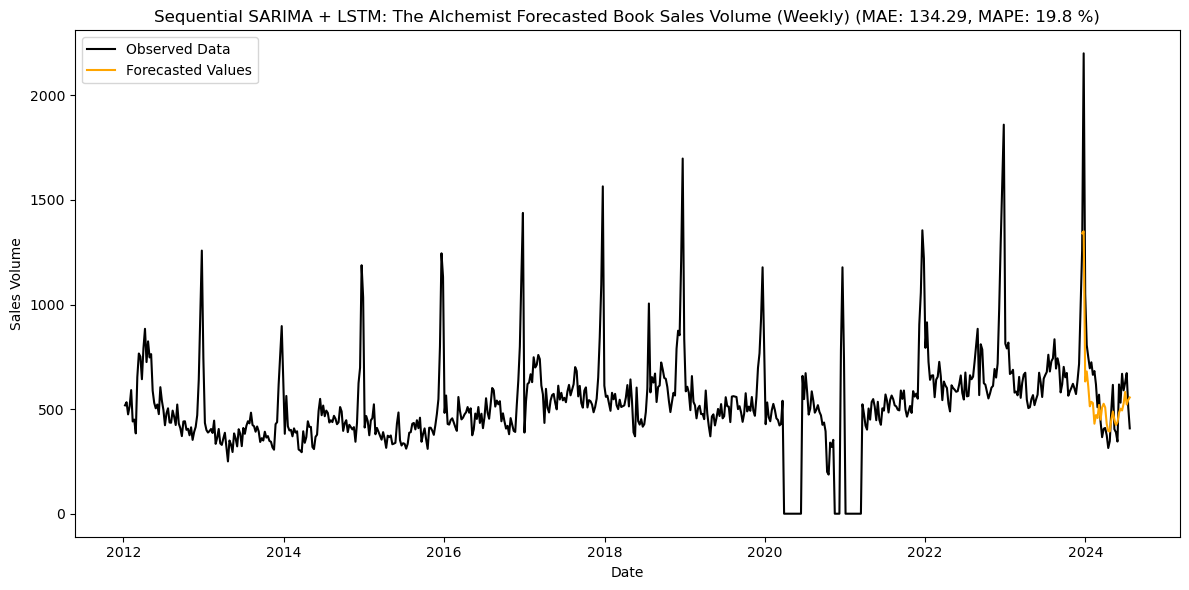

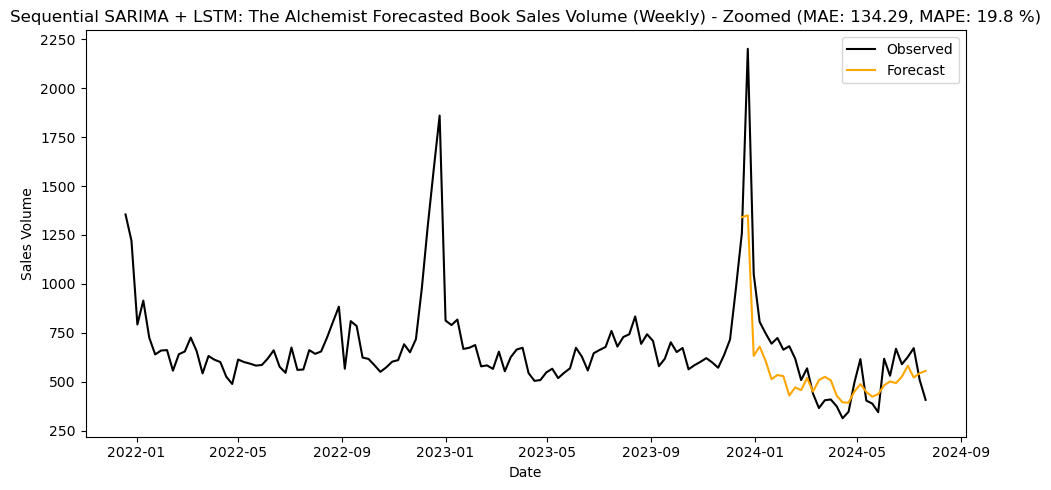

In [ ]:
# Get residual predictions, combine with original forecast and plot the results.
alchemist_title = 'Sequential SARIMA + LSTM: The Alchemist Forecasted Book Sales Volume (Weekly)'

alchemist_sequential_mae, alchemist_sequential_mape = sequential_forecast_plot(
    alchemist_lstm_model_sequential,
    alchemist_res_la_input_sequence,
    alchemist_res_scaler,
    alchemist_arima_pred,
    alchemist_test_arima,
    alchemist_title,
    alchemist_arima
)

- The hybrid forecast (orange) tracks the post-spike decay much better than the standalone models
- However it still over-smooths weekly volatility, leading to mild-under prediction through Feb-Mar
- Accuracy is the strongest so far (MAPE=19.8%), improving on SARIMA (21.5%) and XGBoost (22.7%)
- Pattern suggests that SARIMA captures the seasonal components while the LSTM corrects the residual structure.

### **7.3.2 The Very Hungry Caterpillar**

In [ ]:
# Train the LSTM model.
caterpillar_path = 'models/caterpillar_lstm_model_sequential.h5'

caterpillar_lstm_hp_sequential, caterpillar_lstm_model_sequential =  train_or_load_lstm_model(
    caterpillar_path,
    lstm_tuned_model,
    X_caterpillar_train_res,
    y_caterpillar_train_res_vec,
    X_caterpillar_val_res,
    y_caterpillar_val_res_vec
    )

Loading existing model from models/caterpillar_lstm_model_sequential.h5


In [ ]:
# View the best hyperparameters.
print(caterpillar_lstm_hp_sequential)

{'input_unit': 76, 'n_layers': 3, 'lstm_0_units': 60, 'final_layer_units': 108, 'Dropout_rate': 0.30000000000000004, 'lr': 0.01, 'lstm_1_units': 52, 'lstm_2_units': 116, 'lstm_3_units': 92}


In [ ]:
# View the model summary.
caterpillar_lstm_model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 76)            23712     
                                                                 
 lstm_1 (LSTM)               (None, 52, 60)            32880     
                                                                 
 lstm_2 (LSTM)               (None, 52, 52)            23504     
                                                                 
 lstm_3 (LSTM)               (None, 52, 116)           78416     
                                                                 
 lstm_4 (LSTM)               (None, 108)               97200     
                                                                 
 dropout (Dropout)           (None, 108)               0         
                                                                 
 dense (Dense)               (None, 32)                3

1/1 [==============================] - 1s 603ms/step


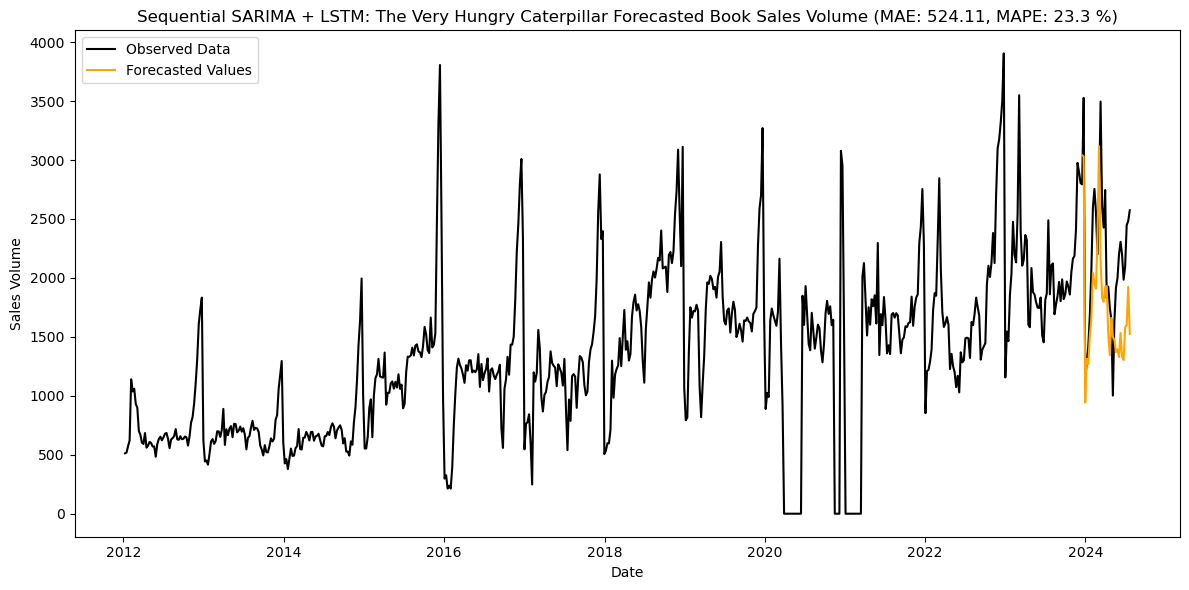

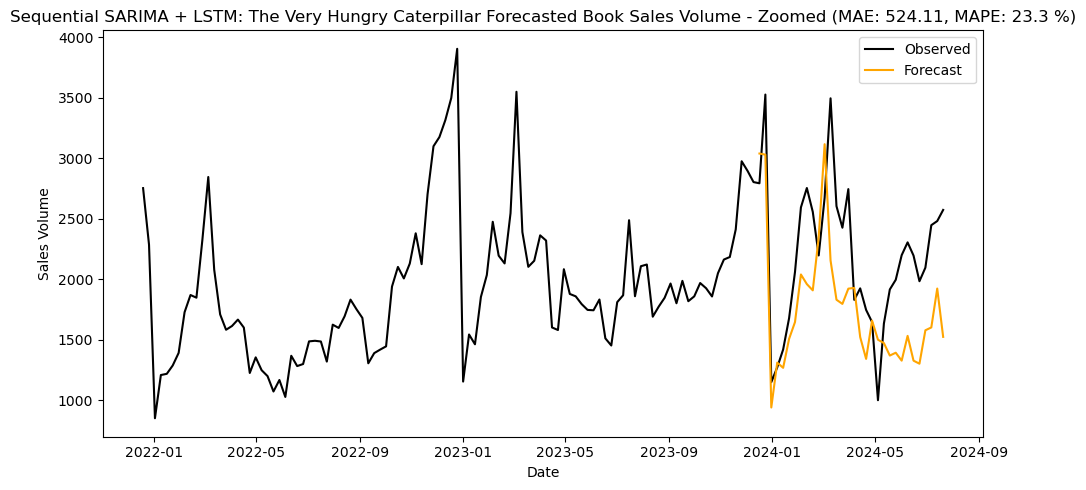

In [ ]:
# Get residual predicitons, combine with original forecast and plot the results.
caterpillar_title = 'Sequential SARIMA + LSTM: The Very Hungry Caterpillar Forecasted Book Sales Volume'

caterpillar_sequential_mae, caterpillar_sequential_mape = sequential_forecast_plot(
    caterpillar_lstm_model_sequential,
    caterpillar_res_la_input_sequence,
    caterpillar_res_scaler,
    caterpillar_arima_pred,
    caterpillar_test_arima,
    caterpillar_title,
    caterpillar_arima
)

- The hybrid forecast (orange) tracks the early 2024 increase and captures several medium spikes, however the amplitudes are off (some are overshot while others are under predicted)
- Overall accuracy (MAPE=23.3%) is comparable to SARIMA and better than standalone ML/DL

# **8. Hybrid Models: Parallel SARIMA + LSTM**

## **8.1 Functions**

In [ ]:
# Function to optimise the LSTM weight.
def weight_optimisation(test, sarima_pred, lstm_pred):
    results = []
    weights = np.linspace(0.0, 1.0, num=101)

    sarima_pred = sarima_pred.reindex(test.index)
    lstm_pred = lstm_pred.reindex(test.index)

    for w in weights:
        hybrid = (w * lstm_pred) + ((1-w) * sarima_pred)
        mae = mean_absolute_error(test, hybrid)
        mape = mean_absolute_percentage_error(test, hybrid) * 100
        results.append((w, mae, mape, hybrid))

    weights_grid = pd.DataFrame(results, columns=['weight_LSTM', 'MAE', 'MAPE', 'predictions'])

    best_row = weights_grid.sort_values(['MAPE', 'MAE'], ascending=[True, True]).iloc[0]
    best_results = pd.DataFrame([{
        'weight': float(best_row['weight_LSTM']),
        'MAE': float(best_row['MAE']),
        'MAPE': float(best_row['MAPE'])
    }])

    best_pred = best_row['predictions']
    weights_grid_clean = weights_grid.drop(columns='predictions')

    return weights_grid_clean, best_results, best_pred

## **8.2 Weight Optimisation**

### **8.2.1 The Alchemist**

The predictions from the best SARIMA model are stored as: alchemist_arima_predictions and the predictions from the best LSTM model are stored as: alchemist_lstm_predictions.

In [ ]:
# Combine the predictions from the best SARIMA and LSTM model (trained separately) to get the weighted average.
alchemist_50_weight_pred = (0.5 * alchemist_arima_pred) + (0.5 * alchemist_lstm_pred)

# Compute the mae and mape.
alchemist_50_weight_mae = mean_absolute_error(alchemist_test_arima, alchemist_50_weight_pred)
alchemist_50_weight_mape = mean_absolute_percentage_error(alchemist_test_arima, alchemist_50_weight_pred) * 100

print('Weight LSTM: 50 %')
print(f'MAE: {alchemist_50_weight_mae:.2f}')
print(f'MAPE: {alchemist_50_weight_mape:.1f} %')

Weight LSTM: 50 %
MAE: 150.02
MAPE: 23.1 %


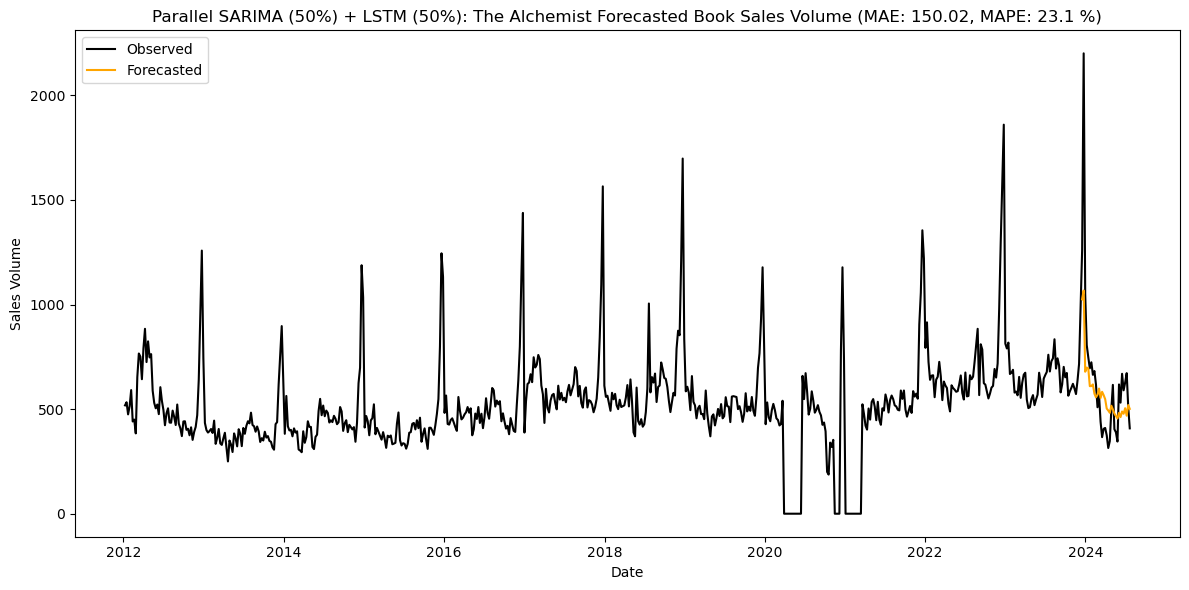

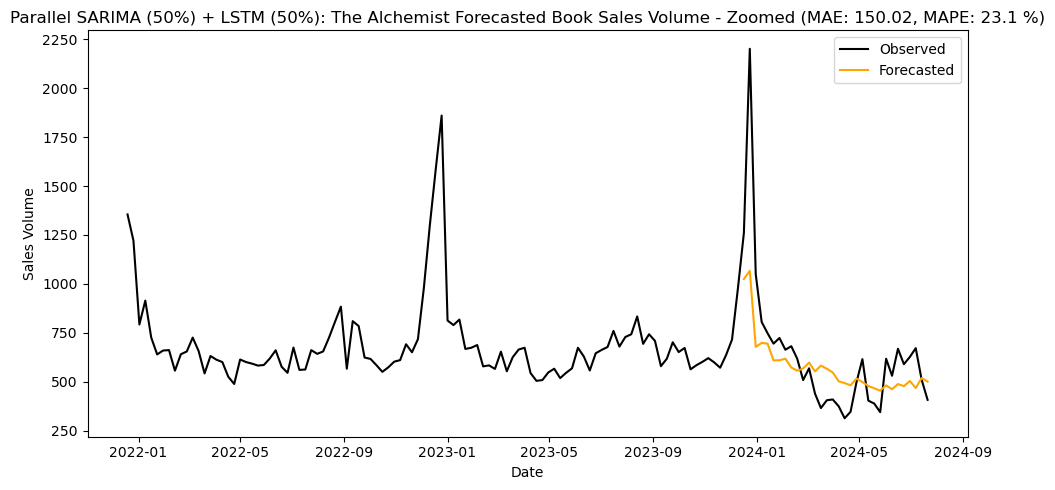

In [ ]:
# Plot the new forecast.
y_pred = np.asarray(alchemist_50_weight_pred).reshape(-1)
y_pred = pd.Series(y_pred, index=alchemist_test_arima.index, name='Forecast')

plt.figure(figsize=(12, 6))
plt.title(f'Parallel SARIMA (50%) + LSTM (50%): The Alchemist Forecasted Book Sales Volume (MAE: {alchemist_50_weight_mae:.2f}, MAPE: {alchemist_50_weight_mape:.1f} %)')
plt.plot(alchemist_arima, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed in plot.
x_alchemist = alchemist_test_arima.copy()

zoom_start = x_alchemist.index[0] - pd.Timedelta(weeks=104)
zoom_end = x_alchemist.index[-1]
alchemist_zoom = alchemist_arima[(alchemist_arima.index >= zoom_start) & (alchemist_arima.index <= zoom_end)]

plt.title(f'Parallel SARIMA (50%) + LSTM (50%): The Alchemist Forecasted Book Sales Volume - Zoomed (MAE: {alchemist_50_weight_mae:.2f}, MAPE: {alchemist_50_weight_mape:.1f} %)')
plt.plot(alchemist_zoom, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

- The parallel hybrid forecast (orange) tracks the broad post-peak decline but smooths the series where peaks and troughs are over and under shot.
- Seasonal pattern is partially captured but amplitude is underestimated reflected by the error (MAPE=23.1%, MAE= 150.02).
- The weight of LSTM and SARIMA needs to be optimised to reduce the error.

In [ ]:
# Evaluate different weights to find the optimal result.
alchemist_weights_grid, alchemist_best_results, alchemist_parallel_pred = weight_optimisation(alchemist_test_arima, alchemist_arima_pred, alchemist_lstm_pred)

# View the best results
alchemist_parallel_mae = alchemist_best_results['MAE'].iat[0]
alchemist_parallel_mape = alchemist_best_results['MAPE'].iat[0]
alchemist_best_weight = alchemist_best_results['weight'].iat[0]

print('Best LSTM Weight:', alchemist_best_weight)
print(f'MAE: {alchemist_parallel_mae:.2f}')
print(f'MAPE: {alchemist_parallel_mape:.1f} %')

Best LSTM Weight: 0.15
MAE: 137.93
MAPE: 21.5 %


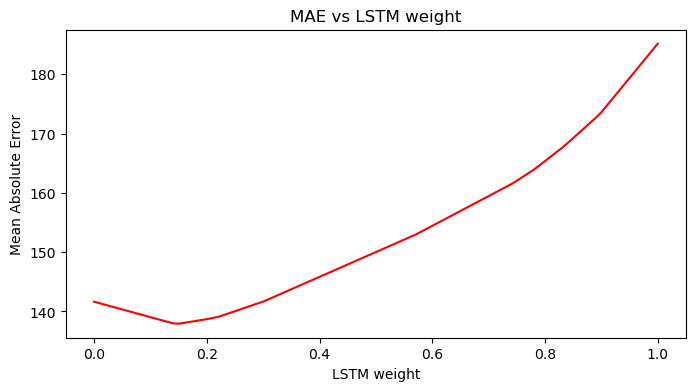

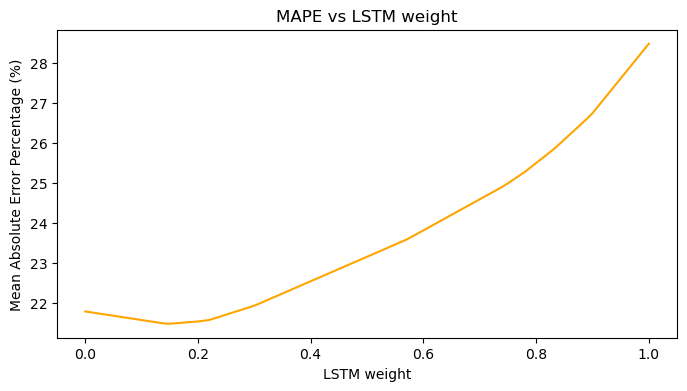

In [ ]:
# Plot MAPE and MAE vs weight.
plt.figure(figsize=(8, 4))
plt.plot(alchemist_weights_grid['weight_LSTM'], alchemist_weights_grid['MAE'], color='red')
plt.xlabel('LSTM weight')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs LSTM weight')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(alchemist_weights_grid['weight_LSTM'], alchemist_weights_grid['MAPE'], color='orange')
plt.xlabel('LSTM weight')
plt.ylabel('Mean Absolute Error Percentage (%)')
plt.title('MAPE vs LSTM weight')
plt.show()

- The best LSTM weight is 15% followed by a significant worsening of accuracy as the weight increases.
- This suggests the LSTM residuals add a small signal but mostly noise.

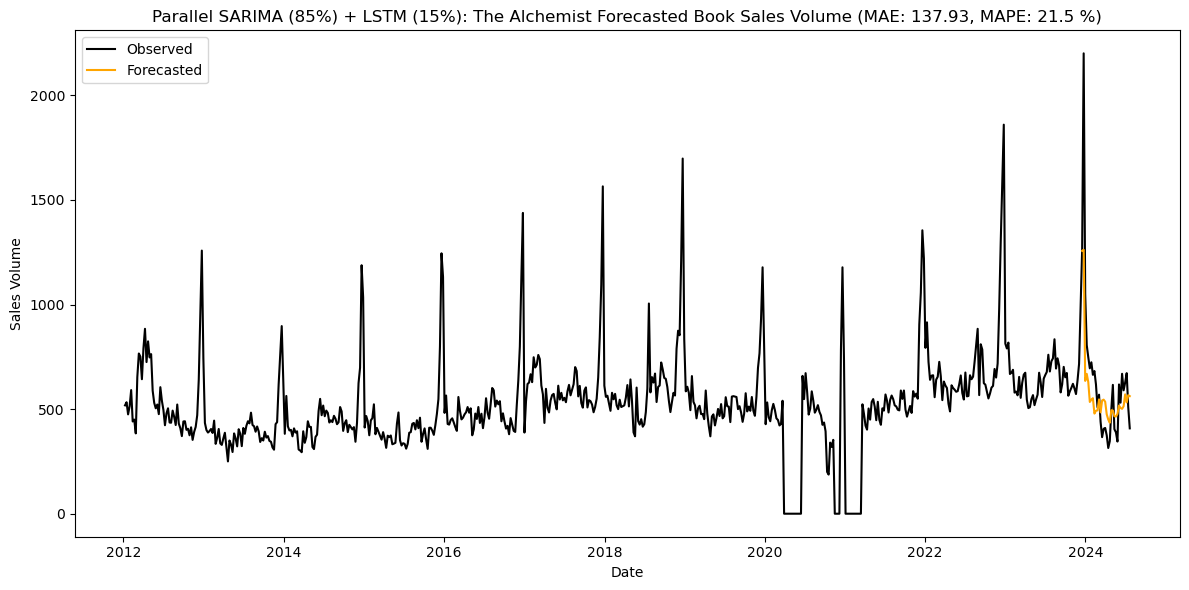

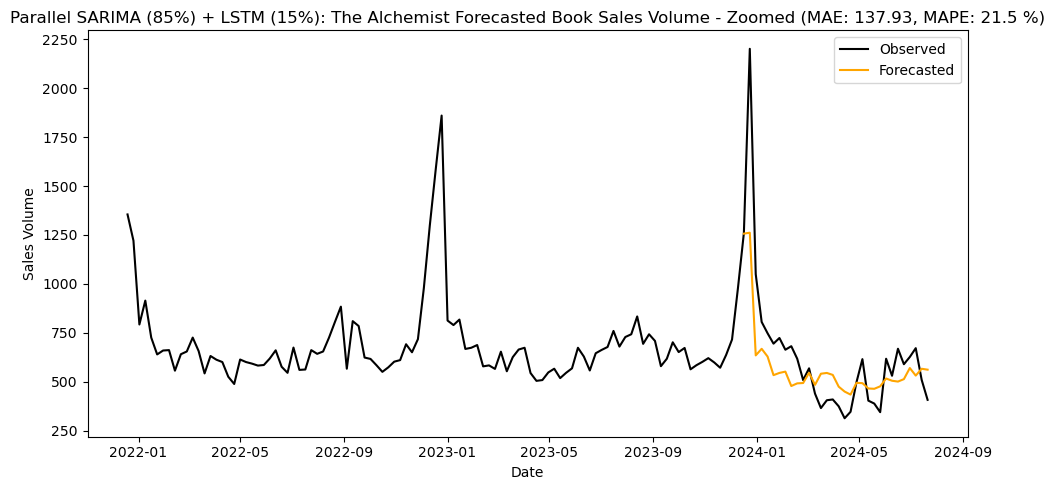

In [ ]:
# Plot the new forecast.
y_pred = np.asarray(alchemist_parallel_pred).reshape(-1)
y_pred = pd.Series(y_pred, index=alchemist_test_arima.index, name='Forecast')

plt.figure(figsize=(12, 6))
plt.title(f'Parallel SARIMA (85%) + LSTM (15%): The Alchemist Forecasted Book Sales Volume (MAE: {alchemist_parallel_mae:.2f}, MAPE: {alchemist_parallel_mape:.1f} %)')
plt.plot(alchemist_arima, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed in plot.
x_alchemist = alchemist_test_arima.copy()

zoom_start = x_alchemist.index[0] - pd.Timedelta(weeks=104)
zoom_end = x_alchemist.index[-1]
alchemist_zoom = alchemist_arima[(alchemist_arima.index >= zoom_start) & (alchemist_arima.index <= zoom_end)]

plt.title(f'Parallel SARIMA (85%) + LSTM (15%): The Alchemist Forecasted Book Sales Volume - Zoomed (MAE: {alchemist_parallel_mae:.2f}, MAPE: {alchemist_parallel_mape:.1f} %)')
plt.plot(alchemist_zoom, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

- The parallel hybrid forecast (orange) tracks the post-spike decay and overall level but smooths shorter spikes
- It underestimates the Jan 2024 spike and over estimates in spring, indcating damped amplitude.
- Performance-wise it is roughly on par with SARIMA for MAPE (21.5% vs 21.8%) but is weaker than the sequential hybrid.

### **8.2.2 The Very Hungry Caterpillar**

The predictions from the best SARIMA model are stored as: caterpillar_arima_predictions and the predictions from the best LSTM model are stored as: caterpillar_lstm_predictions.

In [ ]:
# Combine the predictions from the best SARIMA and LSTM model (trained separately) to get the weighted average.
caterpillar_50_weight_pred = (0.5 * caterpillar_arima_pred) + (0.5 * caterpillar_lstm_pred)

# Compute the mae and mape.
caterpillar_50_weight_mae = mean_absolute_error(caterpillar_test_arima, caterpillar_50_weight_pred)
caterpillar_50_weight_mape = mean_absolute_percentage_error(caterpillar_test_arima, caterpillar_50_weight_pred) * 100

print('Weight LSTM: 50 %')
print(f'MAE: {caterpillar_50_weight_mae:.2f}')
print(f'MAPE: {caterpillar_50_weight_mape:.1f} %')

Weight LSTM: 50 %
MAE: 548.69
MAPE: 23.8 %


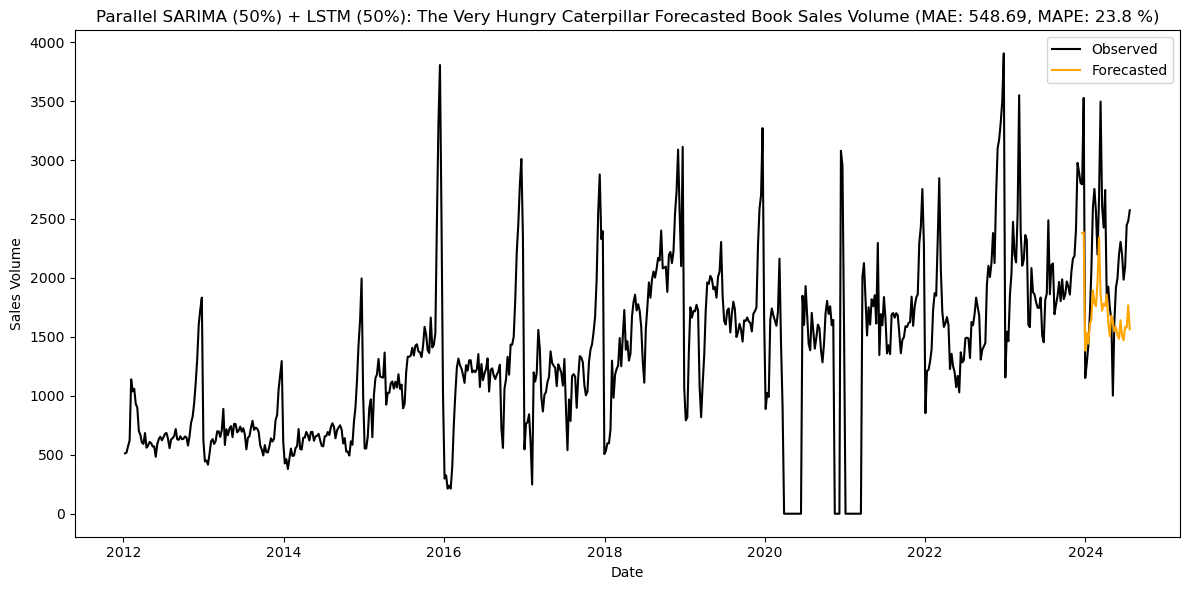

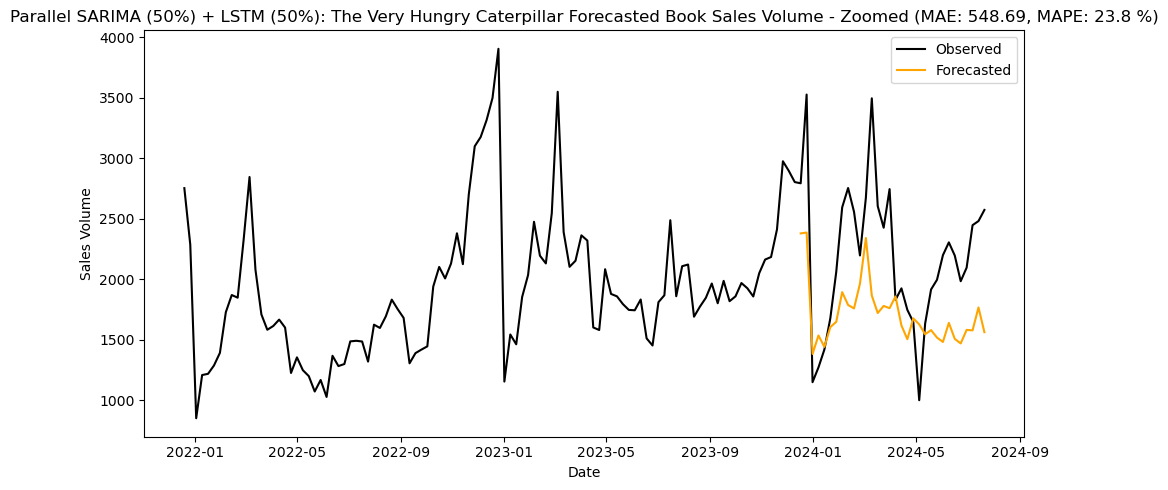

In [ ]:
# Plot the new forecast.
y_pred = np.asarray(caterpillar_50_weight_pred).reshape(-1)
y_pred = pd.Series(y_pred, index=caterpillar_test_arima.index, name='Forecast')

plt.figure(figsize=(12, 6))
plt.title(f'Parallel SARIMA (50%) + LSTM (50%): The Very Hungry Caterpillar Forecasted Book Sales Volume (MAE: {caterpillar_50_weight_mae:.2f}, MAPE: {caterpillar_50_weight_mape:.1f} %)')
plt.plot(caterpillar_arima, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed in plot.
x_caterpillar = caterpillar_test_arima.copy()

zoom_start = x_caterpillar.index[0] - pd.Timedelta(weeks=104)
zoom_end = x_caterpillar.index[-1]
caterpillar_zoom = caterpillar_arima[(caterpillar_arima.index >= zoom_start) & (caterpillar_arima.index <= zoom_end)]

plt.title(f'Parallel SARIMA (50%) + LSTM (50%): The Very Hungry Caterpillar Forecasted Book Sales Volume - Zoomed (MAE: {caterpillar_50_weight_mae:.2f}, MAPE: {caterpillar_50_weight_mape:.1f} %)')
plt.plot(caterpillar_zoom, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

- The parallel hybrid forecast (orange) tracks the direction but has a negative bias where it underpredicts.
- Seasonal pattern is partially captured but amplitude is underestimated reflected by the higher error (MAE: 548.69, MAPE: 23.8%).
- The weight of LSTM and SARIMA needs to be optimised to reduce the error.

In [ ]:
# Evaluate different weights to find the optimal result.
caterpillar_weights_grid, caterpillar_best_results, caterpillar_parallel_pred = weight_optimisation(caterpillar_test_arima, caterpillar_arima_pred, caterpillar_lstm_pred)

# View the best results
caterpillar_parallel_mae = caterpillar_best_results['MAE'].iat[0]
caterpillar_parallel_mape = caterpillar_best_results['MAPE'].iat[0]
caterpillar_best_weight = caterpillar_best_results['weight'].iat[0]

print('Best LSTM Weight:', caterpillar_best_weight)
print(f'MAE: {caterpillar_parallel_mae:.2f}')
print(f'MAPE: {caterpillar_parallel_mape:.1f} %')

Best LSTM Weight: 0.23
MAE: 504.46
MAPE: 22.0 %


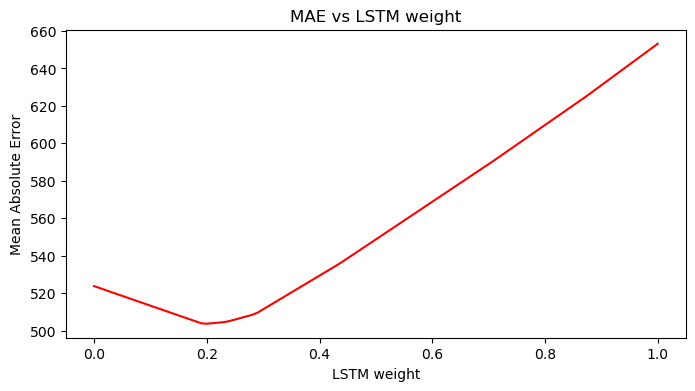

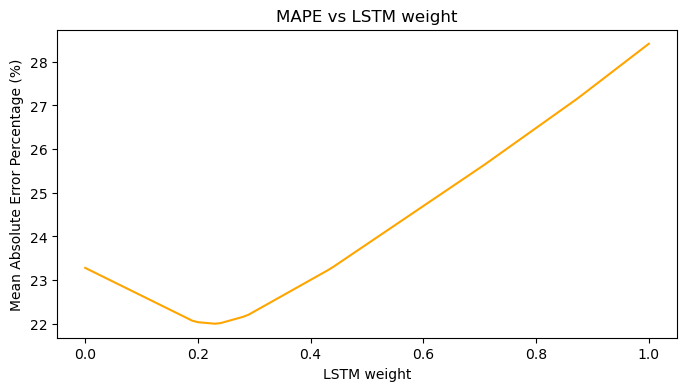

In [ ]:
# Plot MAPE and MAE vs weight.
plt.figure(figsize=(8, 4))
plt.plot(caterpillar_weights_grid['weight_LSTM'], caterpillar_weights_grid['MAE'], color='red')
plt.xlabel('LSTM weight')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs LSTM weight')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(caterpillar_weights_grid['weight_LSTM'], caterpillar_weights_grid['MAPE'], color='orange')
plt.xlabel('LSTM weight')
plt.ylabel('Mean Absolute Error Percentage (%)')
plt.title('MAPE vs LSTM weight')
plt.show()

- The best LSTM weight is 22% followed by a significant worsening of accuracy as the weight increases.
- This suggests the LSTM residuals add some signal but mostly noise.

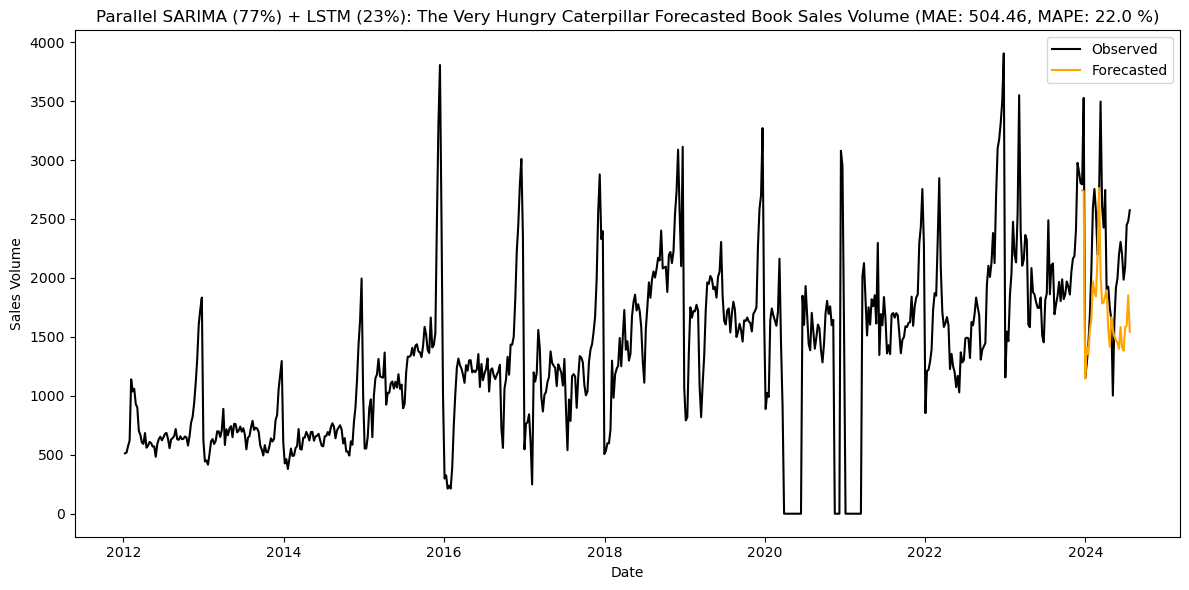

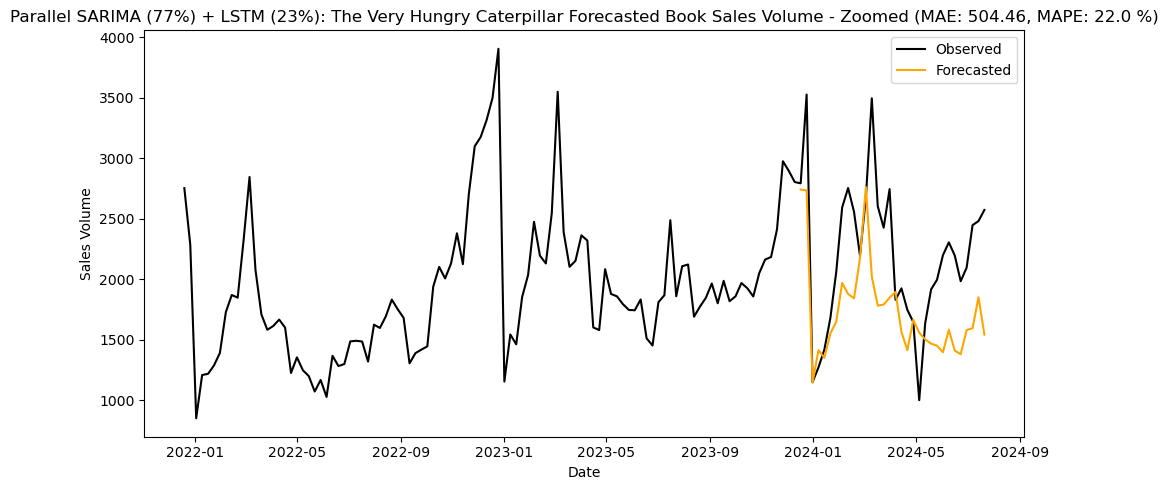

In [ ]:
# Plot the new forecast.
y_pred = np.asarray(caterpillar_parallel_pred).reshape(-1)
y_pred = pd.Series(y_pred, index=caterpillar_test_arima.index, name='Forecast')

plt.figure(figsize=(12, 6))
plt.title(f'Parallel SARIMA (77%) + LSTM (23%): The Very Hungry Caterpillar Forecasted Book Sales Volume (MAE: {caterpillar_parallel_mae:.2f}, MAPE: {caterpillar_parallel_mape:.1f} %)')
plt.plot(caterpillar_arima, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed in plot.
x_caterpillar = caterpillar_test_arima.copy()

zoom_start = x_caterpillar.index[0] - pd.Timedelta(weeks=104)
zoom_end = x_caterpillar.index[-1]
caterpillar_zoom = caterpillar_arima[(caterpillar_arima.index >= zoom_start) & (caterpillar_arima.index <= zoom_end)]

plt.title(f'Parallel SARIMA (77%) + LSTM (23%): The Very Hungry Caterpillar Forecasted Book Sales Volume - Zoomed (MAE: {caterpillar_parallel_mae:.2f}, MAPE: {caterpillar_parallel_mape:.1f} %)')
plt.plot(caterpillar_zoom, label='Observed', color='black')
plt.plot(y_pred, label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

- The parallel hybrid forecast (orange) tracks the early 2024 peak and several medium spikes but some peaks are muted and deep troughs in Apr-May are over-predicted
- This model is the best performance-wise (MAPE= 22.0%) improving on SARIMA and sequential hybrid.

# **9. Monthly Forecasting**

## **9.1 Data Preparation**

In [ ]:
# Drop any irrelelvent columns.
df_alchemist_monthly = df_alchemist.drop(['title', 'ISBN'], axis=1)
df_caterpillar_monthly = df_caterpillar.drop(['title', 'ISBN'], axis=1)

# Set end_date to datetime format.
df_alchemist_monthly.index = pd.to_datetime(df_alchemist_monthly.index)
df_caterpillar_monthly.index = pd.to_datetime(df_caterpillar_monthly.index)

# Aggregate weekly sales to monthly sales (sum)
df_alchemist_monthly = df_alchemist_monthly.resample('M').sum()
df_caterpillar_monthly = df_caterpillar_monthly.resample('M').sum()

# View the dataframes.
print('The Alchemist:')
display(df_alchemist_monthly.head())

print('The Very Hungry Caterpillar:')
display(df_caterpillar_monthly.head())


The Alchemist:


volume
end_date          
2012-01-31    2040
2012-02-29    1866
2012-03-31    2813
2012-04-30    3971
2012-05-31    2385

The Very Hungry Caterpillar:


volume
end_date          
2012-01-31    2226
2012-02-29    4168
2012-03-31    2874
2012-04-30    3023
2012-05-31    2223

## **9.2 Initial Data Exploration**

### **9.2.1 The Alchemist**

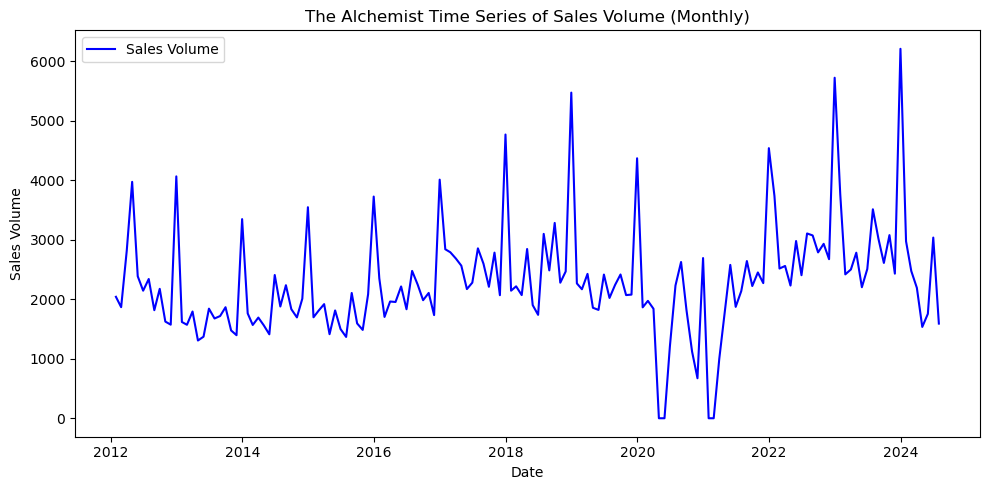

In [ ]:
# Plot the full time series.
plt.plot(df_alchemist_monthly, label='Sales Volume', color='blue')
plt.title('The Alchemist Time Series of Sales Volume (Monthly)')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()

- Time series shows clear seasonality and it appears that the spikes grow with level (indicates multiplicative seasonality).

In [ ]:
# Split the data into training and test set.
fh_monthly = 8
alchemist_train_arima_monthly, alchemist_test_arima_monthly = train_test(df_alchemist_monthly, forecast_horizon=fh_monthly)

Training Period: 2012-01-31 to 2023-11-30 (143)
Test Period: 2023-12-31 to 2024-07-31 (8)


In [ ]:
# Confirm if there are any zero volume values.
alchemist_monthly_zero = alchemist_train_arima_monthly[alchemist_train_arima_monthly['volume'] == 0].shape[0]
print('The Alchemist Zero Values:', alchemist_monthly_zero)

The Alchemist Zero Values: 4


In [ ]:
# Transform data to allow multiplicative decomposition.
epsilon = 1e-6
alchemist_train_arima_monthly_shifted = alchemist_train_arima_monthly + epsilon

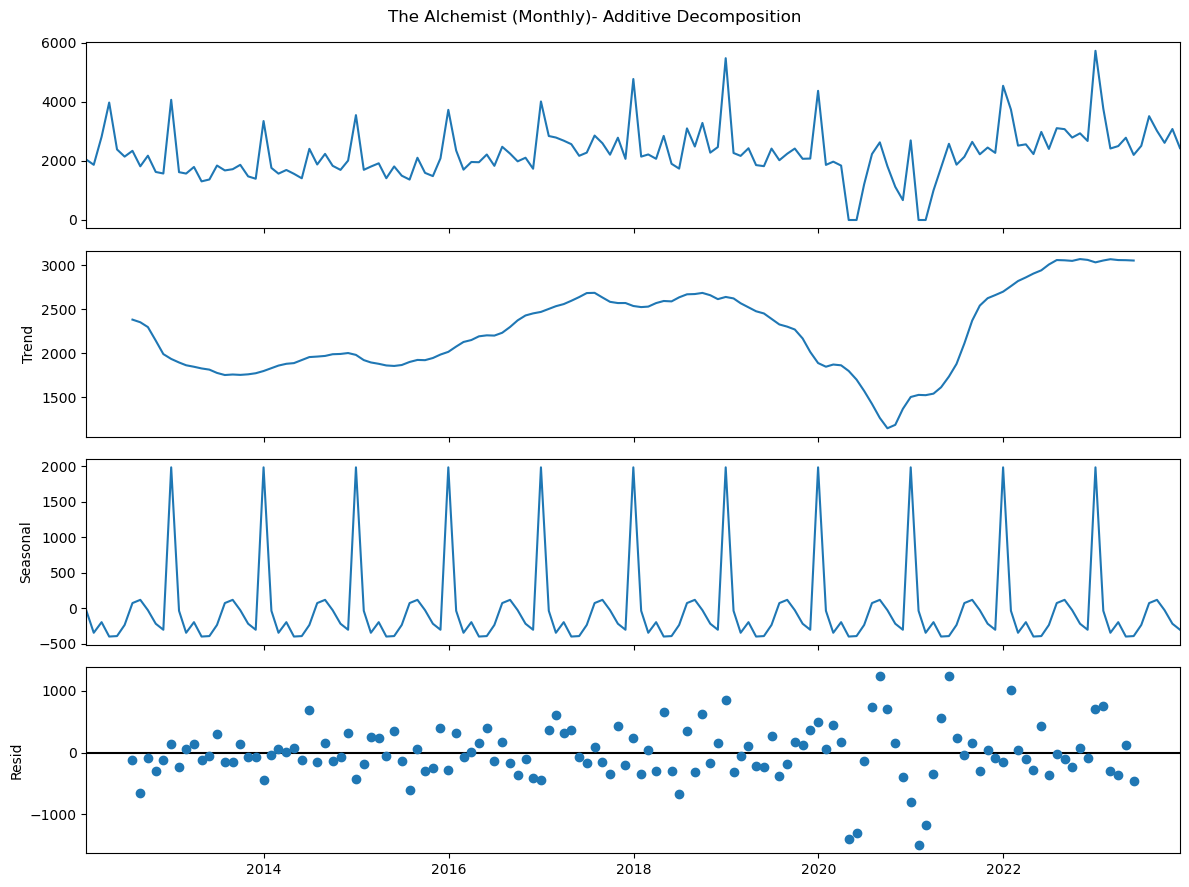

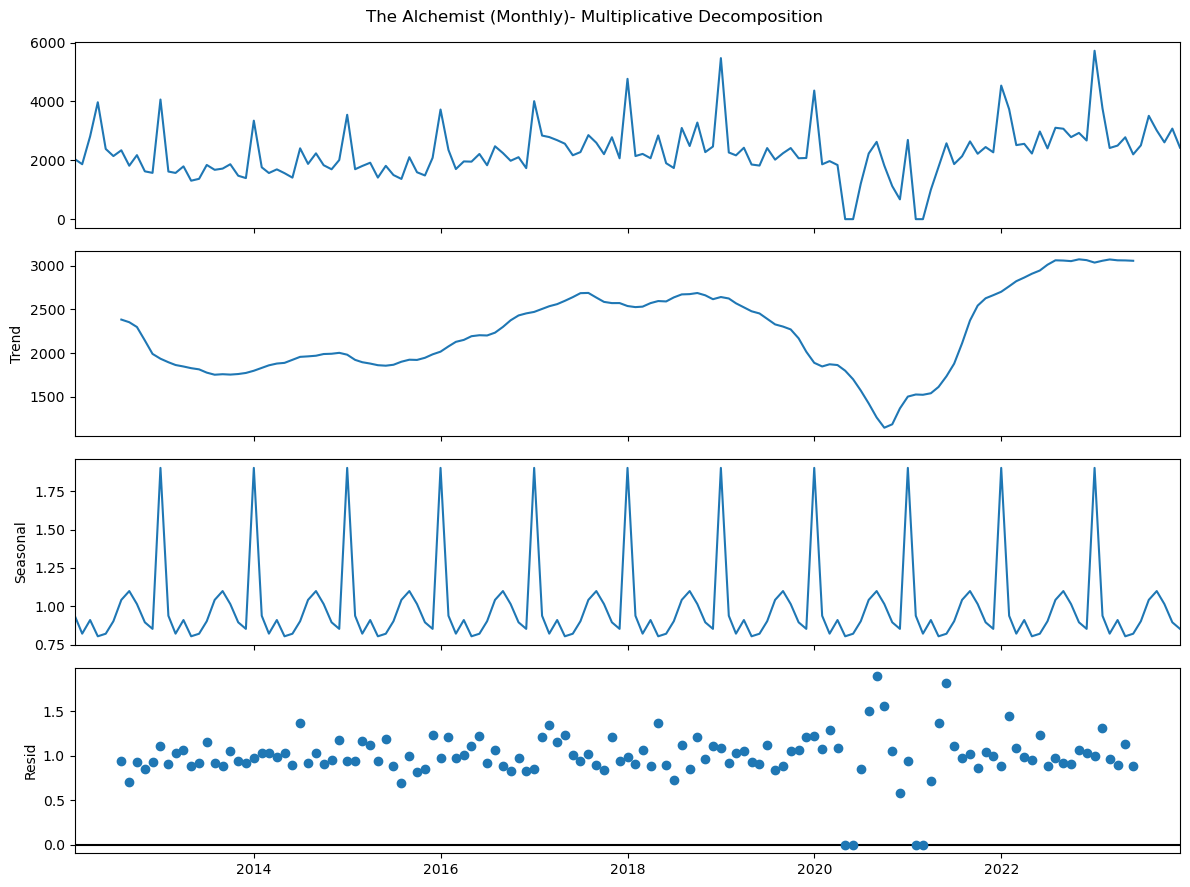

In [ ]:
# Decomposition.
models = ['additive', 'multiplicative']

for model in models:
    result = sm.tsa.seasonal_decompose(alchemist_train_arima_monthly_shifted, model=model, period=12) # set period to 12 for monthly
    fig = result.plot()
    fig.set_size_inches(12, 9)
    plt.suptitle(f'The Alchemist (Monthly)- {model.capitalize()} Decomposition')
    plt.tight_layout()
    plt.savefig(f"{model}_alchemist.png", dpi=300)
    plt.show()

- The seasonal spikes scale with the level—holiday peaks are much bigger in high-level years (2018–2023) than in low-level years indicating multiplicative seasonality.
- The multiplicative residuals are tighter around 1.0 whereas the additive residuals fan out meaning additive is over/under-correcting.
- Multiplicative seasonality will be used for The Alchemist monthly models.

### **9.2.2 The Very Hungry Caterpillar**

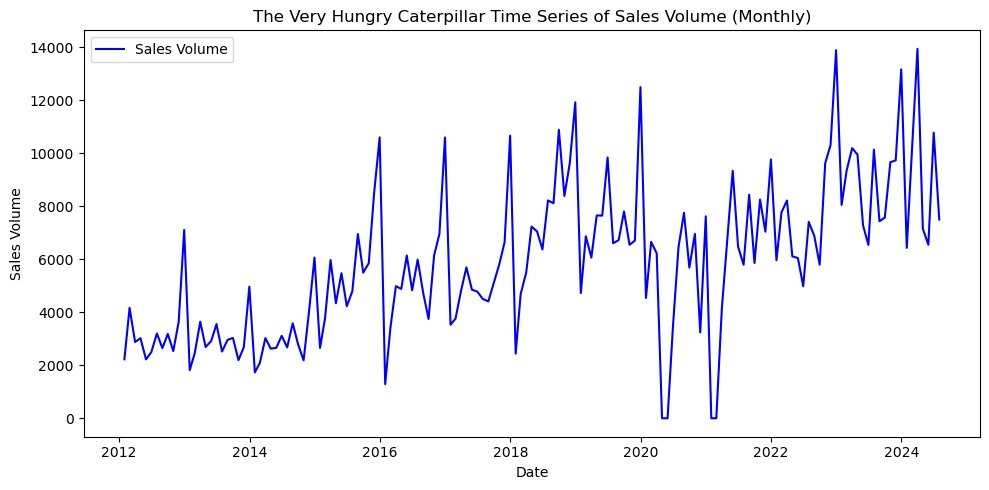

In [ ]:
# Plot the full time series.
plt.plot(df_caterpillar_monthly, label='Sales Volume', color='blue')
plt.title('The Very Hungry Caterpillar Time Series of Sales Volume (Monthly)')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()

- Time series shows clear up-wards trend with large, growing spikes suggesting multiplicative seasonality.

In [ ]:
# Split the data into training and test set.
fh_monthly = 8
caterpillar_train_arima_monthly, caterpillar_test_arima_monthly = train_test(df_caterpillar_monthly, forecast_horizon=fh_monthly)

Training Period: 2012-01-31 to 2023-11-30 (143)
Test Period: 2023-12-31 to 2024-07-31 (8)


In [ ]:
# Confirm if there are any zero volume values.
caterpillar_monthly_zero = caterpillar_train_arima_monthly[caterpillar_train_arima_monthly['volume'] == 0].shape[0]
print('The Very Hungry Caterpillar Zero Values:', caterpillar_monthly_zero)

The Very Hungry Caterpillar Zero Values: 4


In [ ]:
# Transform data to allow multiplicative decomposition.
epsilon = 1e-6
caterpillar_train_arima_monthly_shifted = caterpillar_train_arima_monthly + epsilon

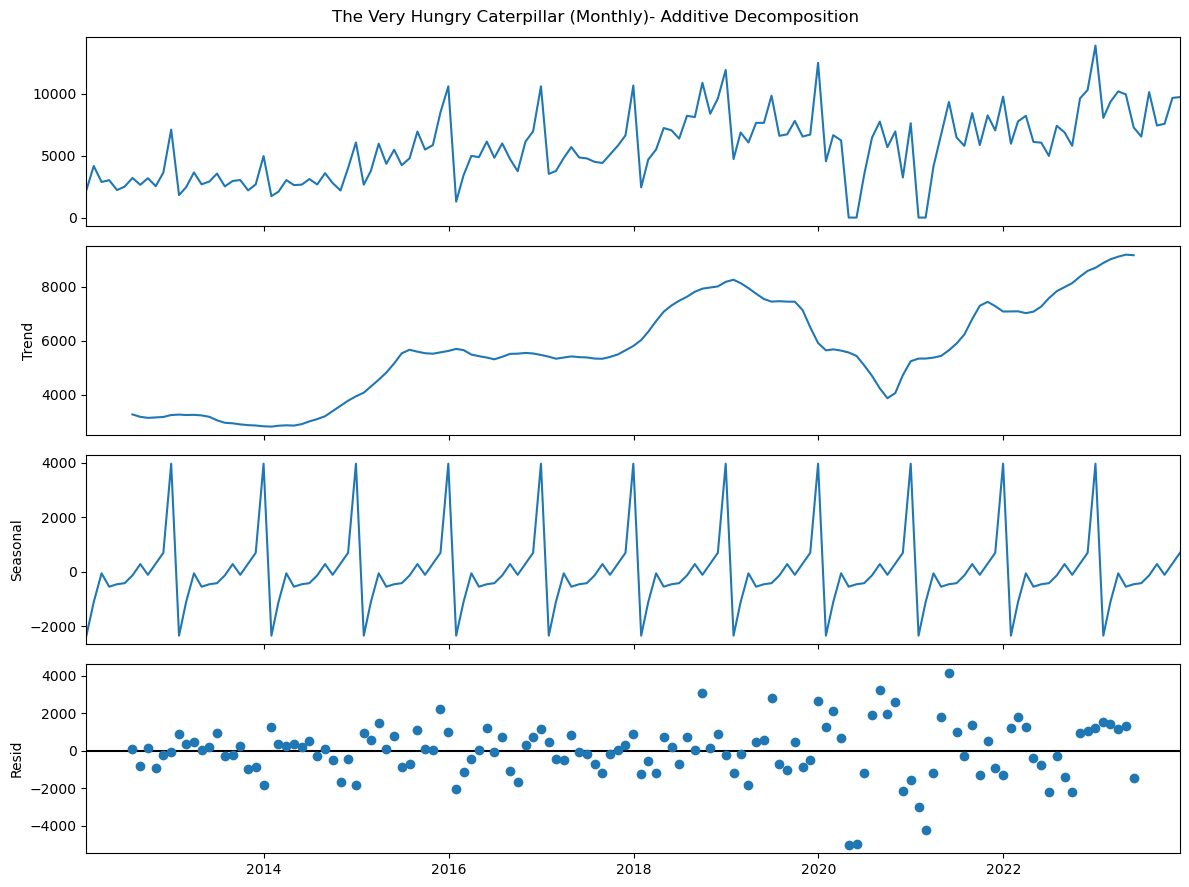

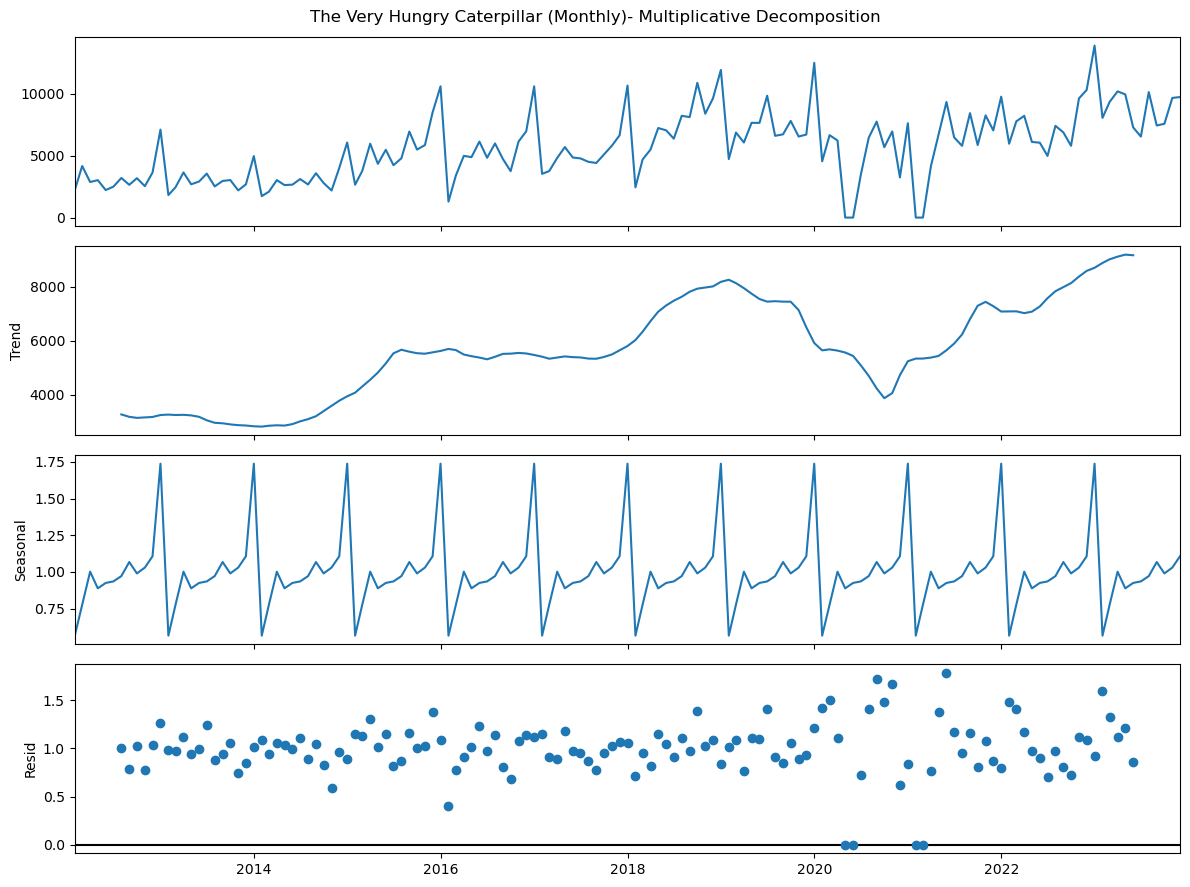

In [ ]:
# Decomposition for monthly alchemist data.
models = ['additive', 'multiplicative']

for model in models:
    result = sm.tsa.seasonal_decompose(caterpillar_train_arima_monthly_shifted, model=model, period=12)
    fig = result.plot()
    fig.set_size_inches(12, 9)
    plt.suptitle(f'The Very Hungry Caterpillar (Monthly)- {model.capitalize()} Decomposition')
    plt.tight_layout()
    plt.savefig(f"{model}_caterpillar_monthly.png", dpi=300)
    plt.show()

- Seasonal swing scales with the level—peaks in high-sales years are proportionally larger suggesting multiplicative seasonality.
- The multiplicative residuals sit roughly around 1 with steadier spread whereas the additive residuals fan out
- Multiplicative seasonality will be used for The Very Hungry Caterpillar monthly models.

## **9.3 Classical Model: SARIMA**

### **9.3.1 The Alchemist**

To handle multiplicative seasonality, box-cox transformation was implemented.

In [ ]:
# Perform Box-Cox transformation for ACF/PACF and ADF test.
y_alchemist = alchemist_train_arima_monthly.reset_index()
y_alchemist = pd.Series(y_alchemist['volume']).astype(float)

lam = stats.boxcox_normmax(y_alchemist + 1)
y_alchemist_bc = boxcox1p(y_alchemist, lam)

<Figure size 2000x1200 with 0 Axes>

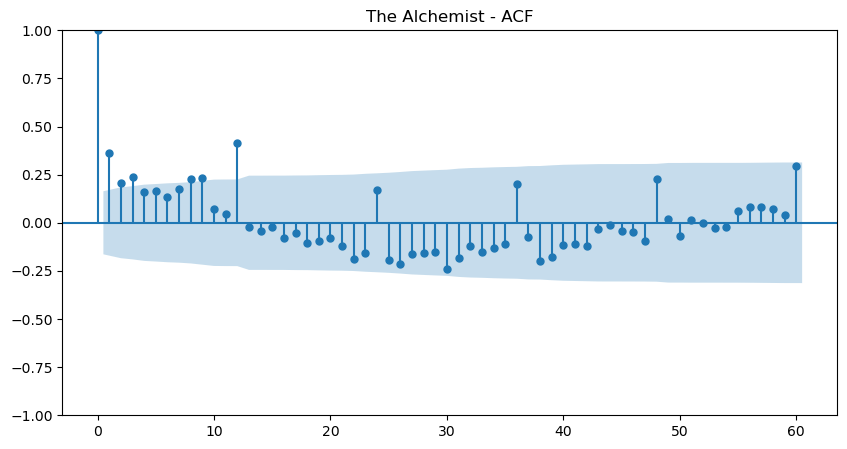

<Figure size 2000x1200 with 0 Axes>

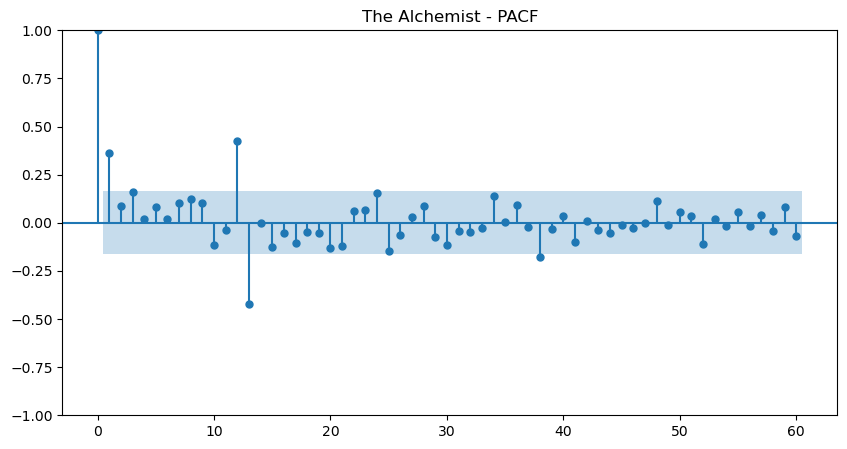

In [ ]:
# Create the ACF and PACF plot for The Alchemist.
plot_funcs = [plot_acf, plot_pacf]
titles = ['ACF', 'PACF']

for func, title in zip(plot_funcs, titles):
    plt.figure(figsize=(20, 12))
    func(y_alchemist_bc, lags=60)
    plt.title(f'The Alchemist - {title}')
    plt.show()

**ACF Observations**
- Lags 1-4 show gradual decay suggesting non-stationarity even after boxcox transformation
- Clear seasoal peaks at 12, 24, 48 and 60 suggesting strong seasonality (D=1)
- No sharp cut-off so set max_q = 4

**PACF Observations**
- Large spike at lag 1 with quick drop off so set max_p = 2

In [ ]:
# Test The Alchemist training data for stationarity.
adf_alchemist = adf(y_alchemist_bc)
print('p-value for Alchemist Data:', adf_alchemist[1])

p-value for Alchemist Data: 0.26748497364803325


**ADF Test**
- **Null hypothesis:** Data contains a unit root and so is non-stationary.
- The p-value is > 0.05 so the null hypothesis cannot be rejected.
- This suggests the data is non-stationary and requires differencing.

**Suggested Parameters**
- d = 1

In [ ]:
# Define model path.
alchemist_path = 'models/alchemist_arima_model_monthly.pkl'

# Set the model parameters.
alchemist_kwargs = arima_kwargs | {'m': 12, 'max_p': 2, 'max_q': 4, 'd': 1}

# Train the model (multiplicative- boxcox with differencing).
alchemist_arima_model_monthly = load_or_fit_arima(alchemist_path, alchemist_train_arima_monthly, use_log=False, use_boxcox=True, **alchemist_kwargs)

Model Found. Loading: models/alchemist_arima_model_monthly.pkl


In [ ]:
# View the model summary.
alchemist_arima_model_monthly.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                -807.397
Date:                             Mon, 18 Aug 2025   AIC                           1624.795
Time:                                     13:38:02   BIC                           1639.133
Sample:                                          0   HQIC                          1630.621
                                             - 143                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4931      0.098      5.027      0.000       0.301       0.685
ar.L2         -0.1152      0.126     -0.912      0.362      -0.363       0.132
ma.L1         -0.7916      0.112     -7.083      0.000      -1.011      -0.573
ar.S.L12      -0.3976      0.070     -5.641      0.000      -0.536      -0.259
sigma2      1.427e+04   1365.949     10.446      0.000    1.16e+04    1.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                53.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- AR(1), MA(1) and SAR(12) are significant but AR(2) is not so can likely be dropped
- **Ljung-box** test p-value = 0.95 (p > 0.05) suggests the residuals show no autocorrelation at lag 1
- **Jarque–Bera test** p-value = 0.00 (p < 0.001) suggests the residuals are not normally distributed (confirmed by high kurtosis = 6.11 and skew=0.26).
- **Heteroskedasticity** p-value = 0.00 (p < 0.001) suggests the variance of residuals is not constant

**Interpretation**
- The seasonal differenced structure captures the main dependence well (residuals roughly white at short-lags)

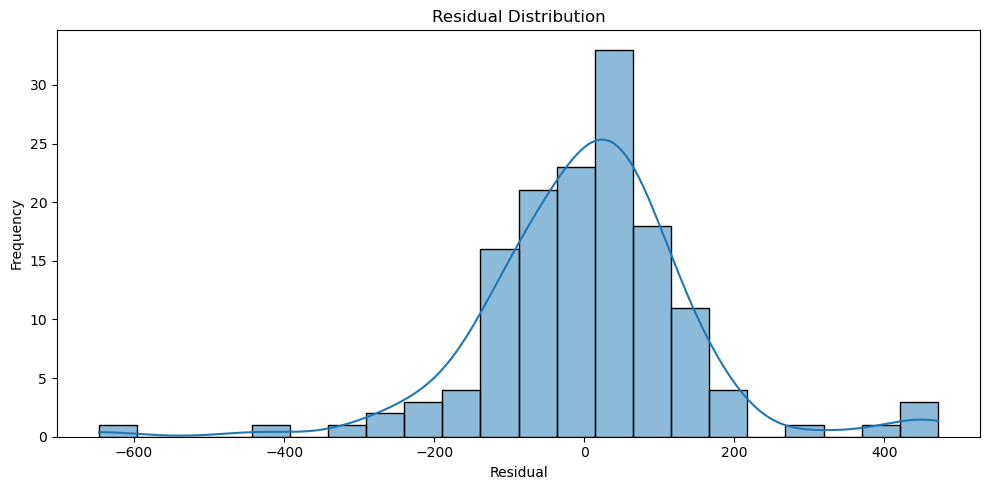

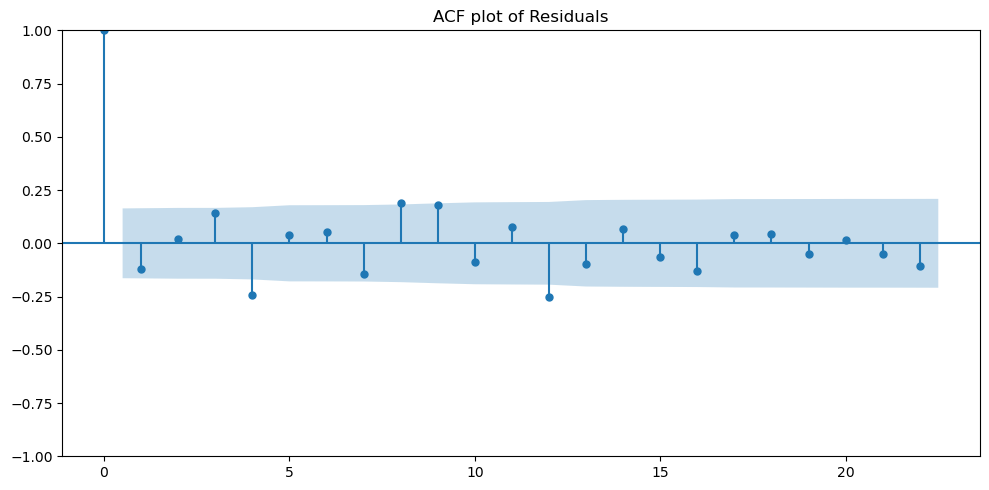

Evidence of auocorrelation at lags: [4, 5, 6, 7, 8, 9, 10, 11, 12] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
alchemist_arima_model_monthly_residuals = residual_diagnostics(alchemist_arima_model_monthly, lags=12)

- ACF of residuals and Ljung-box test and lags 1-12 show autocorrelation at lags 4-12 and a seasonal spike (increase max_Q)
- Histogram confirms the non-normal distribution.

In [ ]:
# Define model path.
alchemist_path = 'models/alchemist_arima_model_monthly_2.pkl'

# Change auto-arima parameters.
alchemist_kwargs = alchemist_kwargs | {'start_p': 0,
                                       'start_q': 1,
                                       'start_Q': 1,
                                       'max_p': 1,
                                       'max_q': 3,
                                       'max_Q': 2,
                                       'max_P': 1,
                                       'd': 1,
                                       'enforce_stationary': False,
                                       'enforce_invertibility': False,
                                       'max_order': None
                                       }

# Train new model.
alchemist_arima_model_monthly_2 = load_or_fit_arima(alchemist_path, alchemist_train_arima_monthly, use_log=False, use_boxcox=True, **alchemist_kwargs)

Model Found. Loading: models/alchemist_arima_model_monthly_2.pkl


In [ ]:
# View the model summary.
alchemist_arima_model_monthly_2.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -807.814
Date:                             Mon, 18 Aug 2025   AIC                           1623.629
Time:                                     13:38:02   BIC                           1635.099
Sample:                                          0   HQIC                          1628.289
                                             - 143                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3159      0.085     -3.713      0.000      -0.483      -0.149
ma.L2         -0.3204      0.086     -3.745      0.000      -0.488      -0.153
ar.S.L12      -0.4149      0.069     -5.976      0.000      -0.551      -0.279
sigma2      1.434e+04   1321.079     10.855      0.000    1.18e+04    1.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                59.86
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- MA(1), MA(2) and seasonal AR(12) are all significant and so these terms are needed.
- **Ljung-box** test p-value = 0.84 (p > 0.05) suggests the residuals show no autocorrelation at lag 1
- **Jarque–Bera test** p-value = 0.00 (p < 0.001) suggests the residuals are not normally distributed (confirmed by high kurtosis = 6.27 and skew=0.30).
- **Heteroskedasticity** p-value = 0.00 (p < 0.001) suggests the variance of residuals is not constant

**Interpretation**
- Moving from AR(2) to MA(2) marginally improved the fit but the residuals are still non-normal.

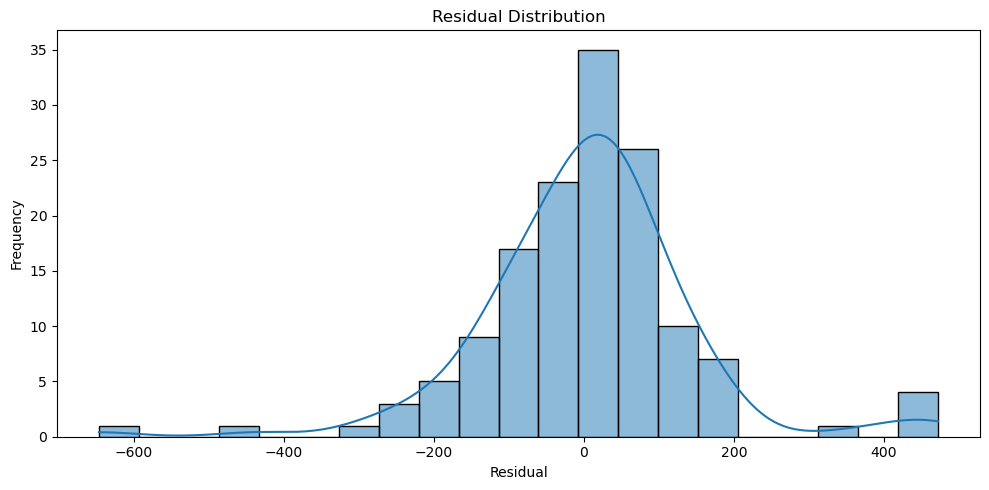

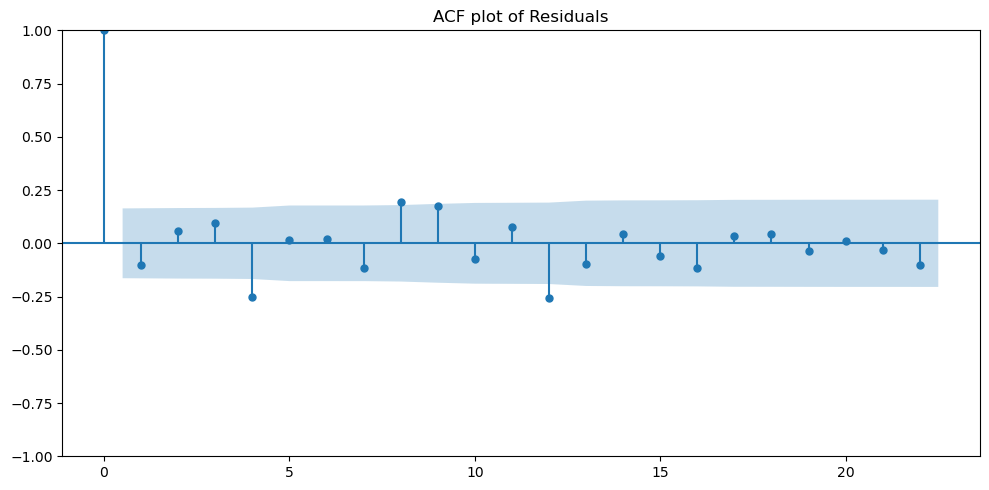

Evidence of auocorrelation at lags: [4, 5, 6, 7, 8, 9, 10, 11, 12] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
alchemist_arima_residuals_2 = residual_diagnostics(alchemist_arima_model_monthly_2, lags=12)

- Increasing max_Q (to let the model use a stronger seasonal MA term) to improve the lag 12 autocorrelation did not improve the results, likely because the remaining structure is event driven.
- Future work would include using exogenous variables to improve.

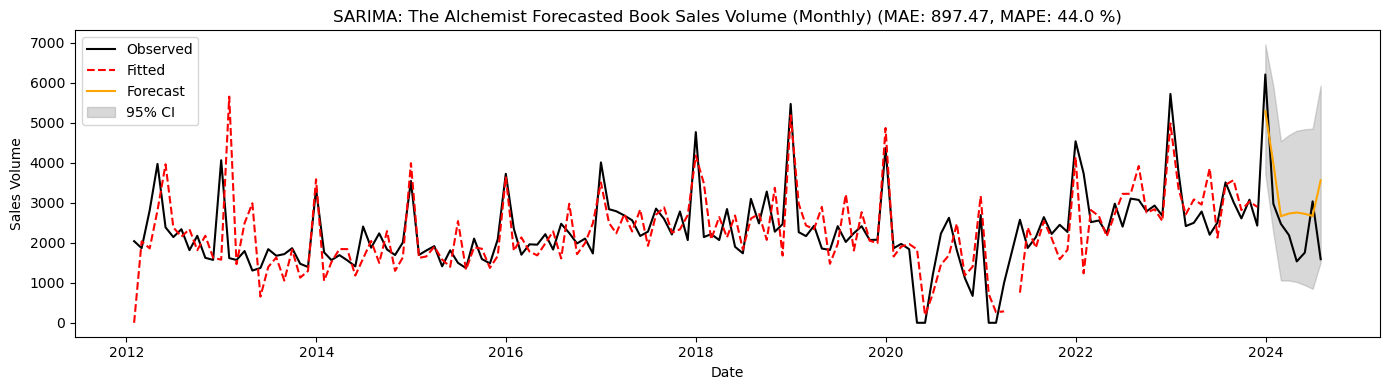

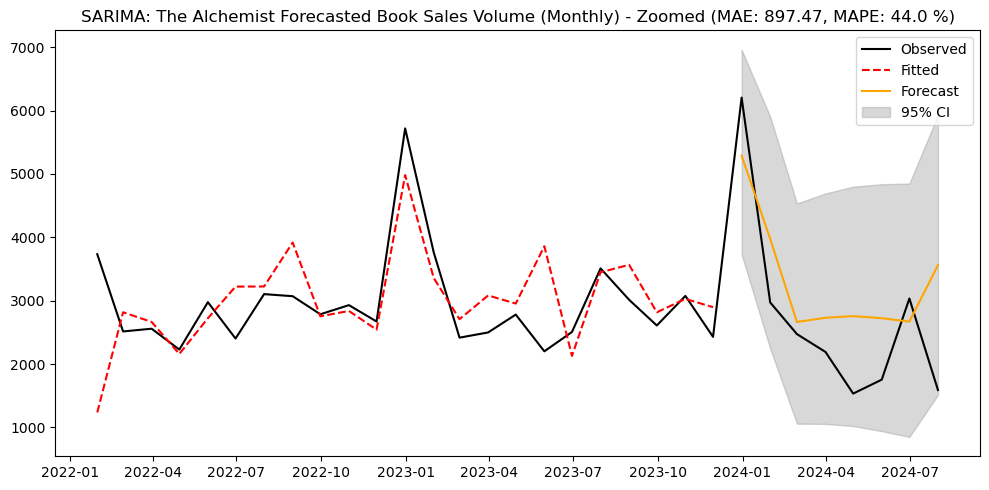

In [ ]:
# Forecast and plot the results.
alchemist_title = 'SARIMA: The Alchemist Forecasted Book Sales Volume (Monthly)'
alchemist_arima_monthly_pred, alchemist_arima_monthly_mae, alchemist_arima_monthly_mape = forecast_and_plot_arima(
    alchemist_arima_model_monthly_2,
    df_alchemist_monthly,
    alchemist_train_arima_monthly,
    alchemist_test_arima_monthly,
    alchemist_title)

- The forecast (orange) overpredicts the spring and then overpredicts the late summer months with very large confidence intervals.
- This is reflect by the extremely poor model error (MAE: 897.47, MAPE= 44.0%), giving the worse performance accuracy-wise.
- The fitted models values also under/overshoot big months.

### **9.3.2 The Very Hungry Caterpillar**

In [ ]:
# Perform Box-Cox transformation for ACF/PACF and ADF test.
y_caterpillar = caterpillar_train_arima_monthly.reset_index()
y_caterpillar = pd.Series(y_caterpillar['volume']).astype(float)

lam = stats.boxcox_normmax(y_caterpillar + 1)
y_caterpillar_bc = boxcox1p(y_caterpillar, lam)

<Figure size 2000x1200 with 0 Axes>

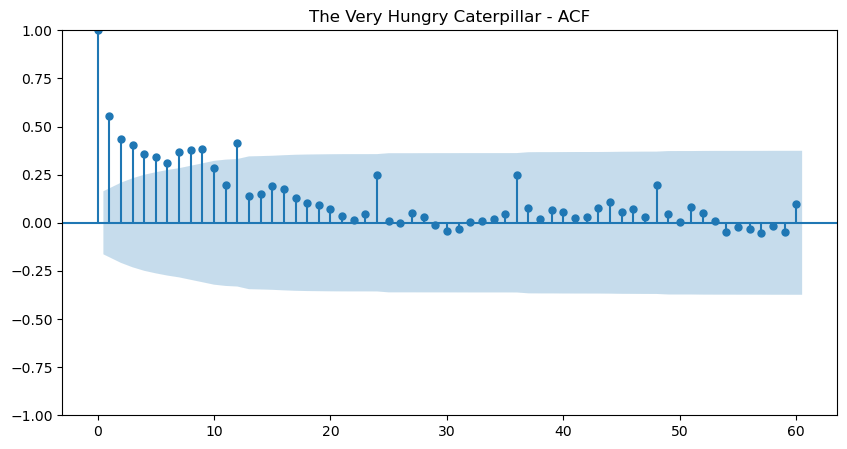

<Figure size 2000x1200 with 0 Axes>

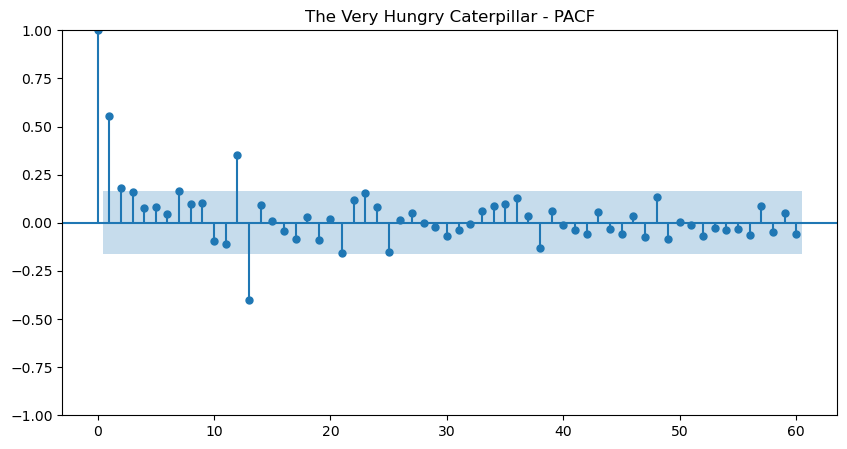

In [ ]:
# Create the ACF and PACF plot for The Alchemist.
plot_funcs = [plot_acf, plot_pacf]
titles = ['ACF', 'PACF']

for func, title in zip(plot_funcs, titles):
    plt.figure(figsize=(20, 12))
    func(y_caterpillar_bc, lags=60)
    plt.title(f'The Very Hungry Caterpillar - {title}')
    plt.show()

**ACF Observations**
- Lags 1-10 show positive decay suggesting the data is non-stationary
- Clear seasonal spikes at 12, 24, 36, 48 and 60 showing strong seasonality (D=1)
- No sharp cut-off after a few lags which suggests mixed AR/MA dependance, set max_q = 4

**PACF Observations**
- Large spike at lag 1 followed by sharp cut-off, set max_p=2
- Seasonal activity near lag 12, include a seasonal AR component max_P=1

**Suggested Parameters**
- max_q = 4
- max_p = 2
- max_P = 1
- max_Q = 1

In [ ]:
# Test The Very Hungry Caterpillar training data for stationarity.
adf_caterpillar= adf(y_caterpillar_bc)
print('p-value for The Very Hungry Caterpillar Data:', adf_caterpillar[1])

p-value for The Very Hungry Caterpillar Data: 0.637121841870969


**ADF Test**
- **Null hypothesis:** Data contains a unit root and so is non-stationary.
- The p-value is > 0.05 so the null hypothesis cannot be rejected.
- This suggests the data is non-stationary and requires differencing.

**Suggested Parameters**
- d = 1

In [ ]:
# Define model path.
caterpillar_path = 'models/caterpillar_arima_model_monthly.pkl'

# Set the model parameters.
caterpillar_kwargs = arima_kwargs | {'m': 12,
                                     'max_p': 2,
                                     'max_q': 4,
                                     'd': 1}

# Train the model (multiplicative- boxcox with differencing).
caterpillar_arima_model_monthly = load_or_fit_arima(caterpillar_path, caterpillar_train_arima_monthly, use_log=False, use_boxcox=True, **caterpillar_kwargs)

Model Found. Loading: models/caterpillar_arima_model_monthly.pkl


In [ ]:
# View the model summary.
caterpillar_arima_model_monthly.named_steps['auto_arima'].model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -816.850
Date:                             Mon, 18 Aug 2025   AIC                           1641.699
Time:                                     13:38:03   BIC                           1653.169
Sample:                                          0   HQIC                          1646.360
                                             - 143                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2741      0.075     -3.652      0.000      -0.421      -0.127
ma.L2         -0.4113      0.082     -4.998      0.000      -0.573      -0.250
ar.S.L12      -0.4375      0.059     -7.358      0.000      -0.554      -0.321
sigma2      1.643e+04   1178.004     13.945      0.000    1.41e+04    1.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               130.97
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Diagnostics**
- MA(1), MA(2) and seasonal AR(12) are all significant and so these terms are needed.
- **Ljung-box** test p-value = 0.71 (p > 0.05) suggests the residuals show no autocorrelation at lag 1
- **Jarque–Bera test** p-value = 0.00 (p < 0.001) suggests the residuals are not normally distributed (confirmed by high kurtosis = 7.75 and skew=-0.64).
- **Heteroskedasticity** p-value = 0.00 (p < 0.001) suggests the variance of residuals is not constant

**Interpretation**
- The short-lag dependance is captured by MA(2) and there is a strong AR(12) component but the residual diagnostics are poor with a higher AIC. Likely due to event/holiday effects the model cannot explain, likely need exogenous regressors.

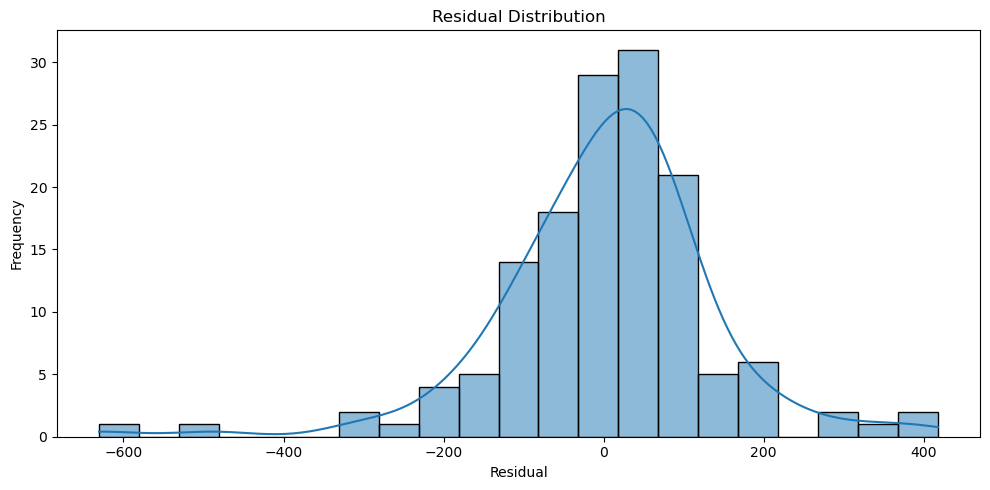

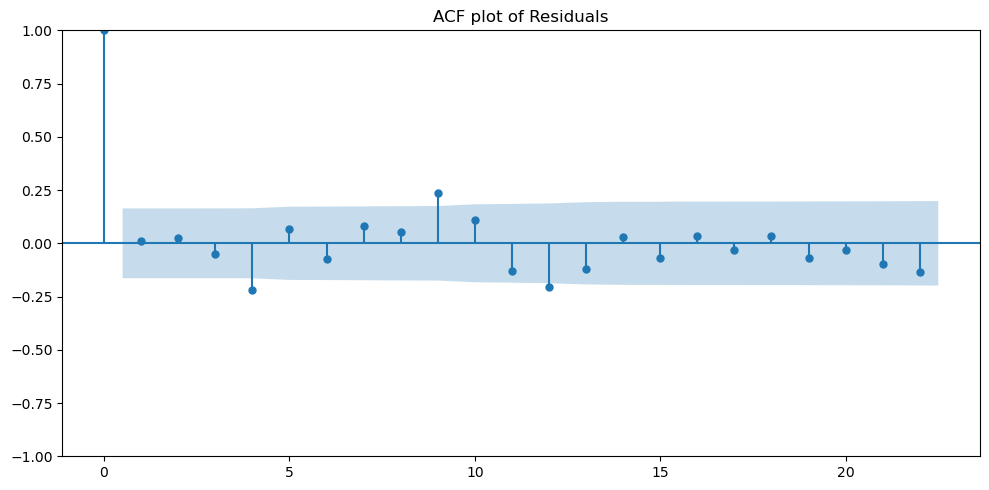

Evidence of auocorrelation at lags: [9, 10] (alpha = 0.05)


In [ ]:
# Perform residual diagnostics.
caterpillar_arima_model_monthly_residuals = residual_diagnostics(caterpillar_arima_model_monthly, lags=10)

- Residual diagnostics confirm non-normal residuals and ljung-box show that short-term lag autocorrelation has been removed.

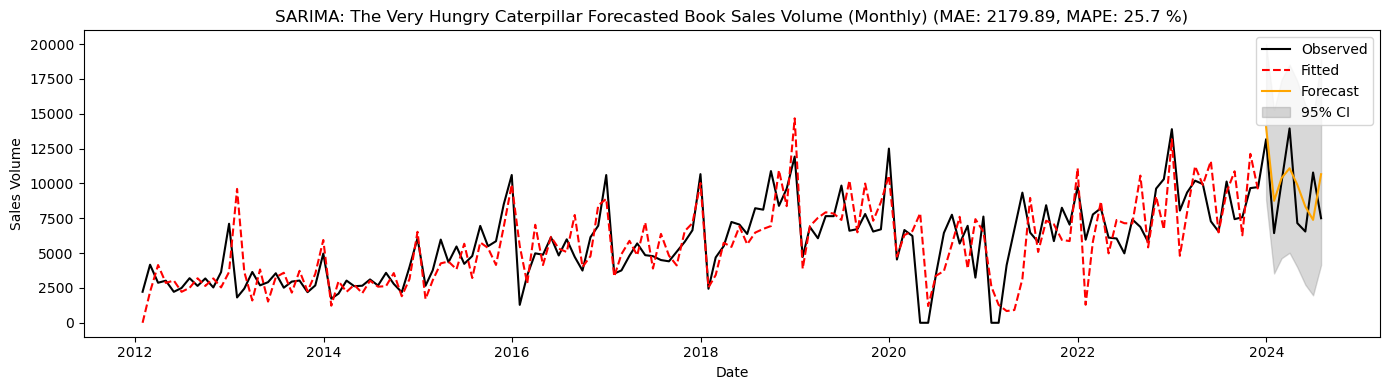

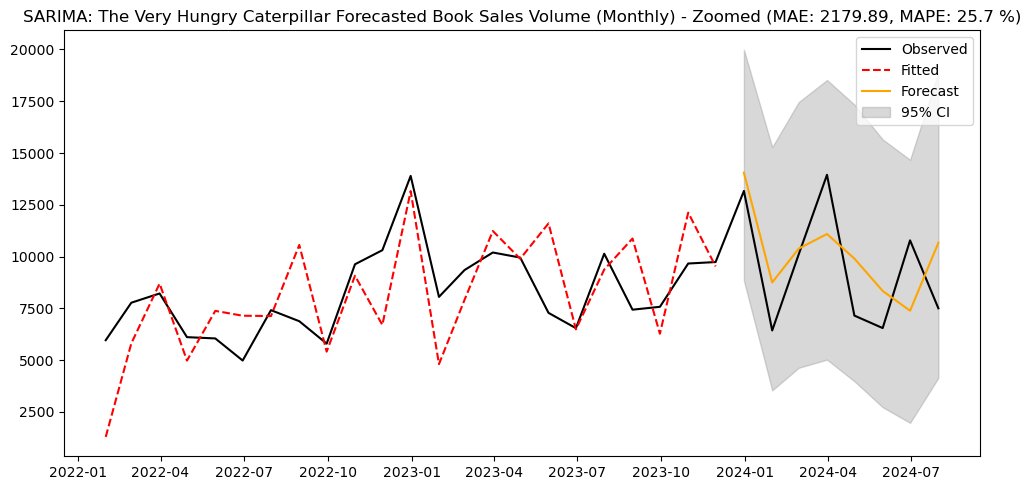

In [ ]:
# Forecast and plot the results.
caterpillar_title = 'SARIMA: The Very Hungry Caterpillar Forecasted Book Sales Volume (Monthly)'
caterpillar_arima_monthly_pred, caterpillar_arima_monthly_mae, caterpillar_arima_monthly_mape = forecast_and_plot_arima(
    caterpillar_arima_model_monthly,
    df_caterpillar_monthly,
    caterpillar_train_arima_monthly,
    caterpillar_test_arima_monthly,
    caterpillar_title)

- Forecast (orange) loosely tracks the sales but over predicts the troughs and underpredicts the peaks with a large error (MAE: 2179.89, MAPE: 25.7%).
- Similarly the fitted valyes under/overshoot the big months showing amplitude is damped and timing is off.
- Additionally the confidence intervals are very wide

## **9.5 Machine Learning Model: XGBoost**

### **9.5.1 Data Preparation**

In [ ]:
# Set the forecast horizon.
fh_monthly = 8

# Split the data into training and test set.
print('The Alchemist:')
alchemist_train_xgb_monthly, alchemist_test_xgb_monthly = train_test(df_alchemist_monthly, forecast_horizon=fh_monthly)
print()
print('The Very Hungry Caterpillar:')
caterpillar_train_xgb_monthly, caterpillar_test_xgb_monthly = train_test(df_caterpillar_monthly, forecast_horizon=fh_monthly)

# Set the index frequency.
alchemist_train_xgb_monthly.index = alchemist_train_xgb_monthly.index.to_period('M')
alchemist_test_xgb_monthly.index = alchemist_test_xgb_monthly.index.to_period('M')

caterpillar_train_xgb_monthly.index = caterpillar_train_xgb_monthly.index.to_period('M')
caterpillar_test_xgb_monthly.index = caterpillar_test_xgb_monthly.index.to_period('M')

The Alchemist:
Training Period: 2012-01-31 to 2023-11-30 (143)
Test Period: 2023-12-31 to 2024-07-31 (8)

The Very Hungry Caterpillar:
Training Period: 2012-01-31 to 2023-11-30 (143)
Test Period: 2023-12-31 to 2024-07-31 (8)


In [ ]:
# Set the parameter grid.
param_grid = {
    'xgb__window_length': [6, 12, 24],
    'xgb__estimator__n_estimators': [100, 300],
    'xgb__estimator__max_depth': [3, 5, 7],
    'xgb__estimator__gamma': [0, 0.1, 0.3]
}

### **9.5.2 Modelling**

#### **9.5.2.1 The Alchemist**

In [ ]:
# Identify the best XGBoost model.
alchemist_path = 'models/alchemist_xgb_model_monthly.pkl'
fh = np.arange(1, len(alchemist_test_xgb_monthly) + 1)

# Train the model.
alchemist_xgb_model_monthly = train_or_load_xgb_model(alchemist_train_xgb_monthly, param_grid, alchemist_path, fh, sp=12, seasonal_model='multiplicative')

Loading existing model from models/alchemist_xgb_model_monthly.pkl


In [ ]:
# View the best hyperparameters if model loaded.
if os.path.exists(alchemist_path):
    all_params = alchemist_xgb_model_monthly.get_params(deep=True)
    pprint.pprint(chosen_params_from_grid(all_params, param_grid))

{'xgb__estimator__gamma': 0,
 'xgb__estimator__max_depth': 3,
 'xgb__estimator__n_estimators': 300,
 'xgb__window_length': 24}


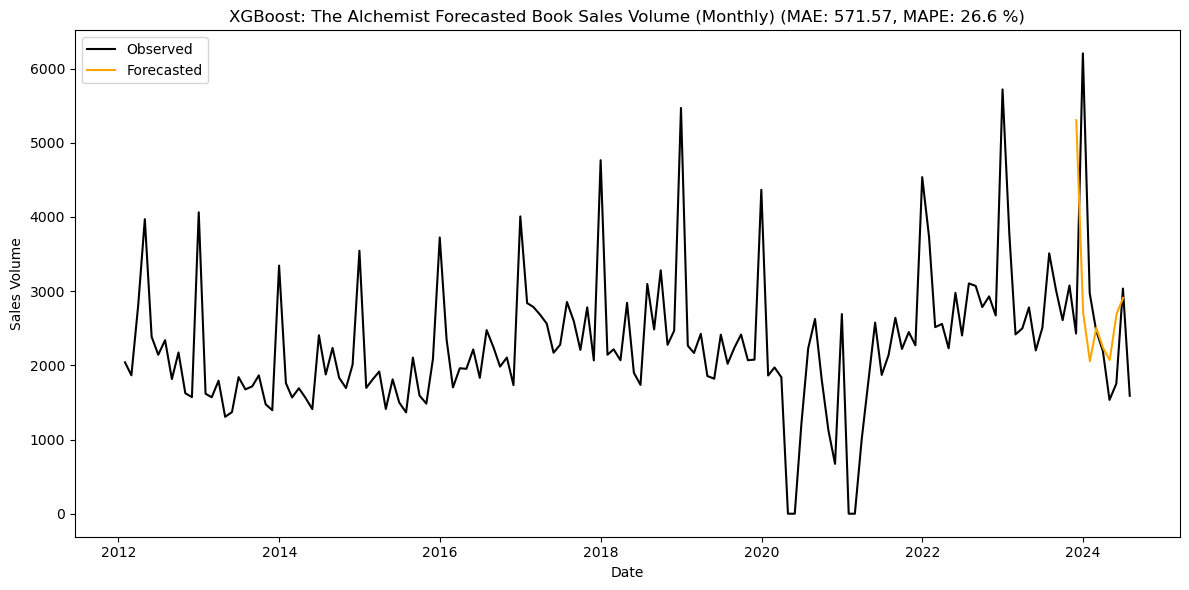

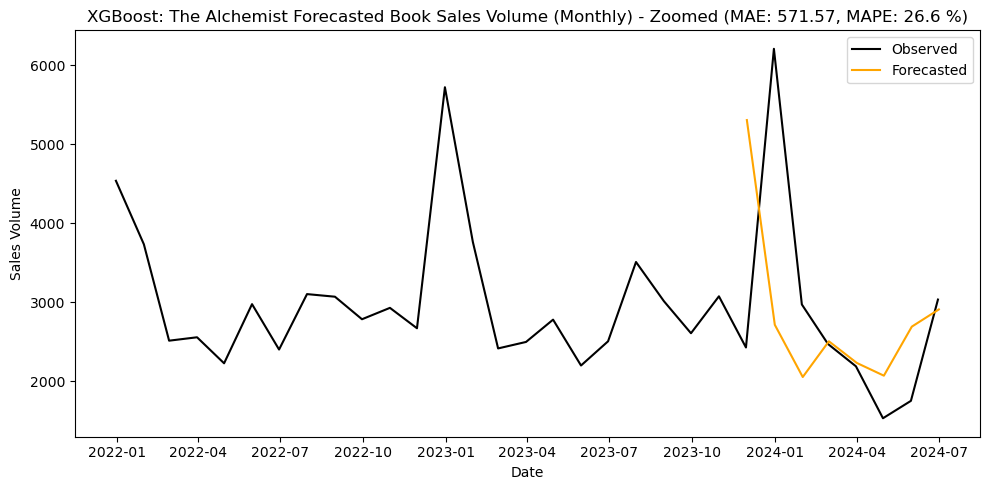

In [ ]:
# Forecast and plot the sales data.
alchemist_title = 'XGBoost: The Alchemist Forecasted Book Sales Volume (Monthly)'
alchemist_xgb_monthly_pred, alchemist_xgb_monthly_mae, alchemist_xgb_monthly_mape = forecast_and_plot_xgb(alchemist_test_xgb_monthly, alchemist_xgb_model_monthly, fh, df_alchemist_monthly, alchemist_title)

- The forecast (orange) misses the amplitude of the Jan 2024 spike and smooths the subsequent decline
- Through Feb-Apr it alternates between over and under predicting, but then recovers by early summer
- Pattern suggests that XGBoost captures the level/trend but not the event/ holiday spikes or strong seasonality on a monthly scale reflected by the higher error (MAE: 571.57, MAPE: 26.6%)

#### **9.5.1.2 The Very Hungry Caterpillar**

In [ ]:
# Identify the best XGBoost model.
caterpillar_path = 'models/caterpillar_xgb_model_monthly.pkl'
fh = np.arange(1, len(alchemist_test_xgb_monthly) + 1)

# Train the model.
caterpillar_xgb_model_monthly = train_or_load_xgb_model(caterpillar_train_xgb_monthly, param_grid, caterpillar_path, fh, sp=12, seasonal_model='multiplicative')

Loading existing model from models/caterpillar_xgb_model_monthly.pkl


In [ ]:
# View the best hyperparameters if model loaded.
if os.path.exists(caterpillar_path):
    all_params = caterpillar_xgb_model_monthly.get_params(deep=True)
    pprint.pprint(chosen_params_from_grid(all_params, param_grid))

{'xgb__estimator__gamma': 0,
 'xgb__estimator__max_depth': 3,
 'xgb__estimator__n_estimators': 100,
 'xgb__window_length': 12}


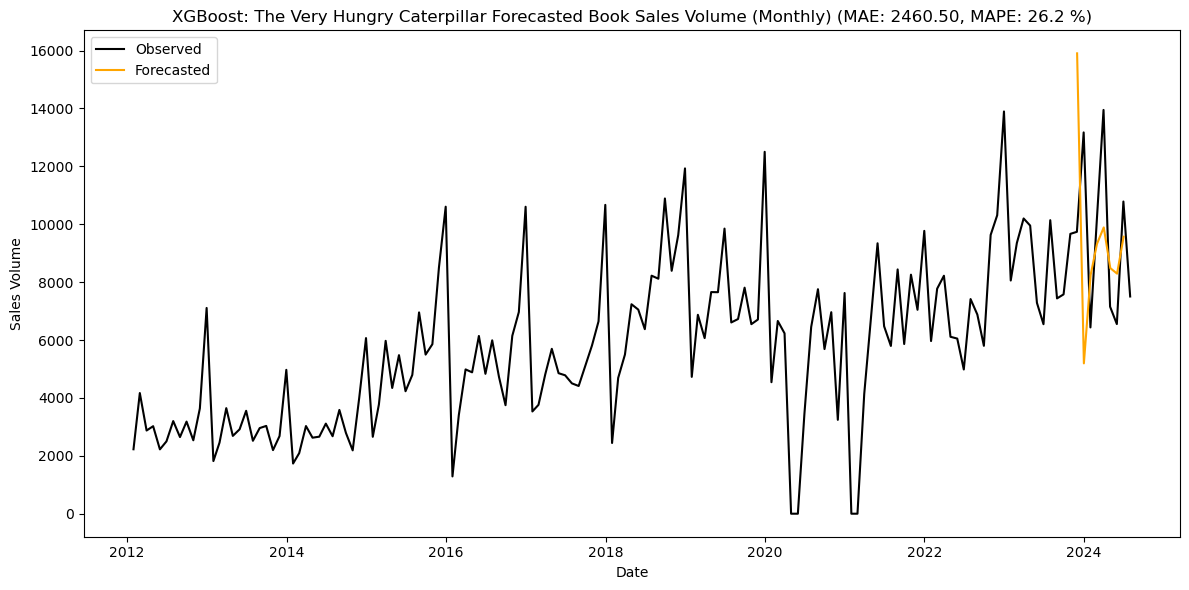

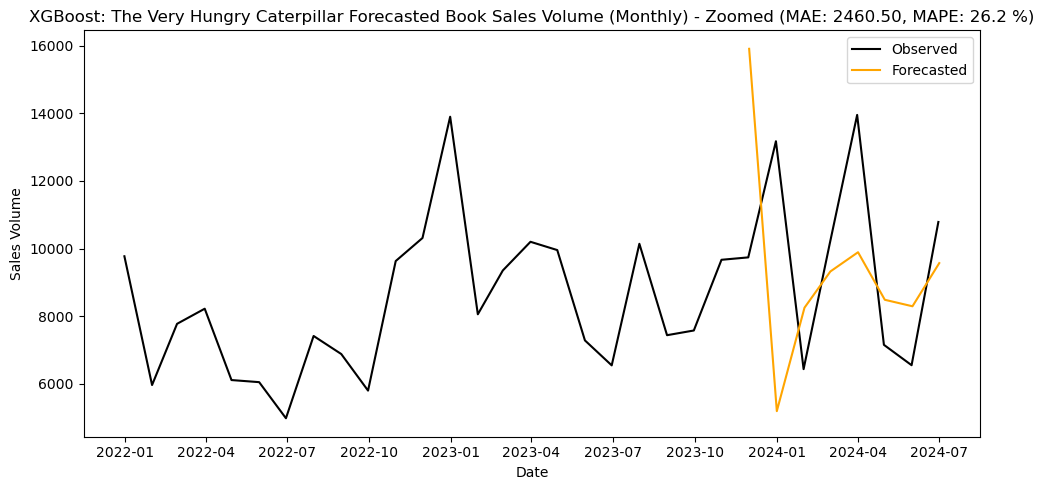

In [ ]:
# Forecast and plot the sales data.
caterpillar_title = 'XGBoost: The Very Hungry Caterpillar Forecasted Book Sales Volume (Monthly)'
caterpillar_xgb_monthly_pred, caterpillar_xgb_monthly_mae, caterpillar_xgb_monthly_mape = forecast_and_plot_xgb(caterpillar_test_xgb_monthly, caterpillar_xgb_model_monthly, fh, df_caterpillar_monthly, caterpillar_title)

- The forecast (orange) wildly overshoots the first month of the horizon and then collapses
- Following this the line is over-smoothed where it under predicts the peaks and over predicts the troughs
- This pattern suggests the model captured the level/trend but not the event/holiday spikes or strong annual seasonality on a monthly scale, reflected by the higher error (MAE: 2460.50, MAPE: 26.2%).

# **10. Model Performance Comparisons**

## **10.1 Comparison of SARIMA vs ML/DL Models vs Hybrid Techniques (Weekly Data)**

### **10.1.1 The Alchemist Weekly Models**

In [ ]:
# Comparison of Alchemist Models (weekly data).
alchemist_model_comparison = pd.DataFrame({
    'Model': ['SARIMA Model', 'XGBoost Model', 'LSTM Model', 'Hybrid Sequential', 'Hybrid Parallel'],
    'MAE': [alchemist_arima_mae, alchemist_xgb_mae, alchemist_lstm_mae, alchemist_sequential_mae, alchemist_parallel_mae],
    'MAPE': [alchemist_arima_mape, alchemist_xgb_mape, alchemist_lstm_mape, alchemist_sequential_mape, alchemist_parallel_mape]
}).round({'MAE': 2, 'MAPE': 1})

display(alchemist_model_comparison.sort_values(by=['MAE', 'MAPE'], ascending=[True, True]))

Model     MAE  MAPE
3  Hybrid Sequential  134.29  19.8
4    Hybrid Parallel  137.93  21.5
0       SARIMA Model  141.64  21.8
1      XGBoost Model  157.43  22.7
2         LSTM Model  185.16  28.5

- The Hybrid Sequential model performed the best (MAE= 134, MAPE= 19.8%) with the lowest MAPE and MAE compared to all standalone models.
- The Hybrid Parallel model was the second best, with a slight improvement (MAPE=21.5%) over the SARIMA baseline (21.8%)
- The standalone XGBoost and LSTM models performed worse than the SARIMA baseline model.

### **10.1.2 The Very Hungry Caterpillar Weekly Models**

In [ ]:
# Comparison of Caterpillar Models (weekly data).
caterpillar_model_comparison = pd.DataFrame({
    'Model': ['SARIMA Model', 'XGBoost Model', 'LSTM Model', 'Hybrid Sequential', 'Hybrid Parallel'],
    'MAE': [caterpillar_arima_mae, caterpillar_xgb_mae, caterpillar_lstm_mae, caterpillar_sequential_mae, caterpillar_parallel_mae],
    'MAPE': [caterpillar_arima_mape, caterpillar_xgb_mape, caterpillar_lstm_mape, caterpillar_sequential_mape, caterpillar_parallel_mape]
}).round({'MAE': 2, 'MAPE': 1})

display(caterpillar_model_comparison.sort_values(by=['MAE', 'MAPE'], ascending=[True, True]))

Model     MAE  MAPE
4    Hybrid Parallel  504.46  22.0
0       SARIMA Model  523.72  23.3
3  Hybrid Sequential  524.11  23.3
1      XGBoost Model  562.55  24.4
2         LSTM Model  653.21  28.4

- The Hybrid Parallel model performed the best (MAE= 504, MAPE= 22.0%) with the lowest MAPE and MAE compared to all standalone models.
- The Hybrid sequential, standalone XGBoost and LSTM models all performed worse than the SARIMA baseline model.

## **10.2 Comparison of Weekly Models vs Monthly Models**

To allow a like for like comparion, the weekly predictions generated by the weekly models were aggregated to monthly predictions. These aggregated predictions were then used to generate new MAPE and MAE vs the monthly test data, and then compared with the monthly predicitons generated directly by the monthly models.

For clarity: the weekly models were trained on weekly data and the monthly models were trained on monthly data.

### **10.2.1 Functions**

In [ ]:
# Function to aggregate the weekly predictions to monthly
def aggregate_weekly_pred(weekly_pred, weekly_test, y_full_monthly, monthly_pred, model_type, book):

    # Format the variables.
    weekly_test = weekly_test['volume'] if isinstance(weekly_test, pd.DataFrame) else weekly_test
    weekly_pred = pd.Series(np.asarray(weekly_pred).ravel(), index=weekly_test.index)

    weekly_test.index = (weekly_test.index.to_timestamp(how='end')
                     if isinstance(weekly_test.index, pd.PeriodIndex)
                     else pd.DatetimeIndex(weekly_test.index).to_period('W').to_timestamp(how='end'))

    weekly_pred.index = (weekly_pred.index.to_timestamp(how='end')
                     if isinstance(weekly_pred.index, pd.PeriodIndex)
                     else pd.DatetimeIndex(weekly_pred.index).to_period('W').to_timestamp(how='end'))

    # Aggregate the weekly data.
    agg_weekly_test = weekly_test.resample('M').sum()
    agg_weekly_pred = weekly_pred.resample('M').sum()

    # Calculate new mae and mape.
    agg_weekly_mae = mean_absolute_error(agg_weekly_test, agg_weekly_pred)
    agg_weekly_mape = mean_absolute_percentage_error(agg_weekly_test, agg_weekly_pred) * 100

    # Plot the data.
    plt.plot(y_full_monthly, label='Observed', color='black')
    plt.plot(agg_weekly_pred, label='Weekly Aggregated Forecast', color='orange')
    plt.plot(monthly_pred, label='Monthly Forecast', color='red')
    plt.title(f'Weekly vs Monthly {model_type} Forecast for {book} Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Zoomed plot.
    zoom_start = agg_weekly_test.index[0] - pd.DateOffset(months=24)
    zoom_end = agg_weekly_test.index[-1]
    zoom = y_full_monthly[(y_full_monthly.index >= zoom_start) & (y_full_monthly.index <= zoom_end)]

    plt.title(f'Weekly vs Monthly {model_type} Forecast for {book} Sales Volume - Zoomed')
    plt.plot(zoom, label='Observed', color='black')
    plt.plot(agg_weekly_pred, label='Weekly Aggregated Forecast', color='orange')
    plt.plot(monthly_pred, label='Monthly Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return agg_weekly_pred, agg_weekly_mae, agg_weekly_mape

### **10.2.2 SARIMA Comparison**

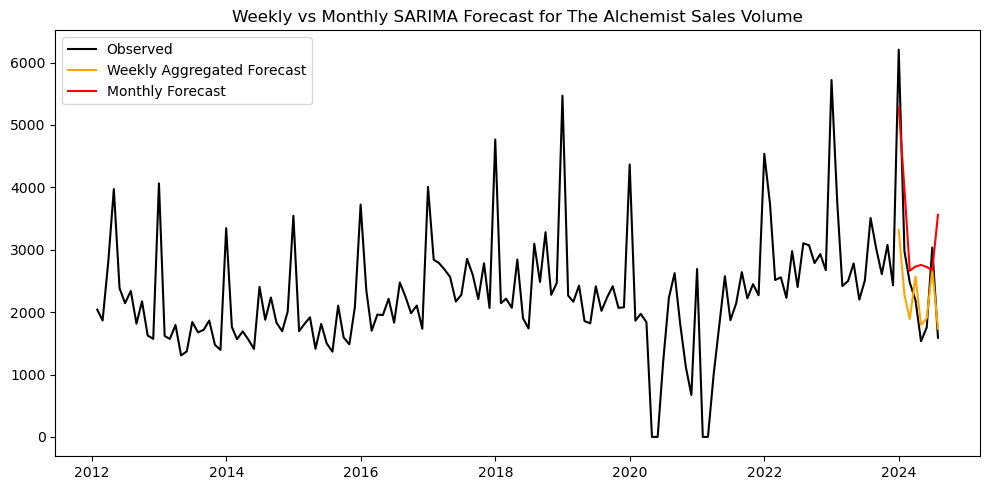

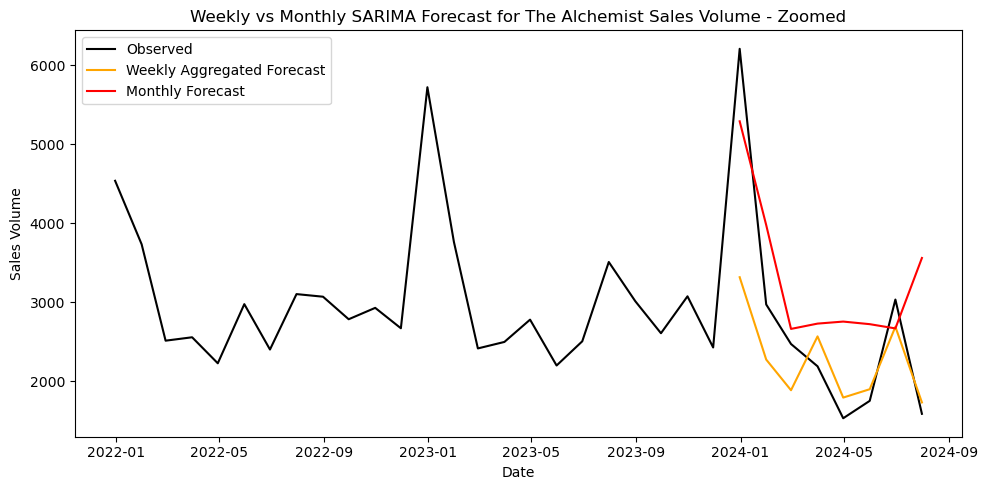

Model     MAE  MAPE (%)
0  SARIMA Weekly (Aggregated)  468.70      17.1
1     SARIMA Monthly (Direct)  897.47      44.0

In [ ]:
# Comparison of SARIMA Models (The Alchemist).
alcemist_agg_weekly_arima_pred, alchemist_agg_weekly_arima_mae, alchemist_agg_weekly_arima_mape = aggregate_weekly_pred(
    alchemist_arima_pred,
    alchemist_test_arima,
    df_alchemist_monthly,
    alchemist_arima_monthly_pred,
    'SARIMA',
    'The Alchemist'
    )

alchemist_arima_comparison = pd.DataFrame({
    'Model': ['SARIMA Weekly (Aggregated)', 'SARIMA Monthly (Direct)'],
    'MAE': [alchemist_agg_weekly_arima_mae, alchemist_arima_monthly_mae],
    'MAPE (%)': [alchemist_agg_weekly_arima_mape, alchemist_arima_monthly_mape]
}).round({'MAE': 2, 'MAPE (%)': 1})

display(alchemist_arima_comparison)

- The SARIMA weekly model significantly outperforms the monthly model (MAPE= 17.1% vs 44.0%) in terms of accuracy.
- The plot shows the monthly model (red) overshoots right after the holiday spike and stays biased, while the aggregated weekly forecast (orange) tracks the post-peak-level much better.

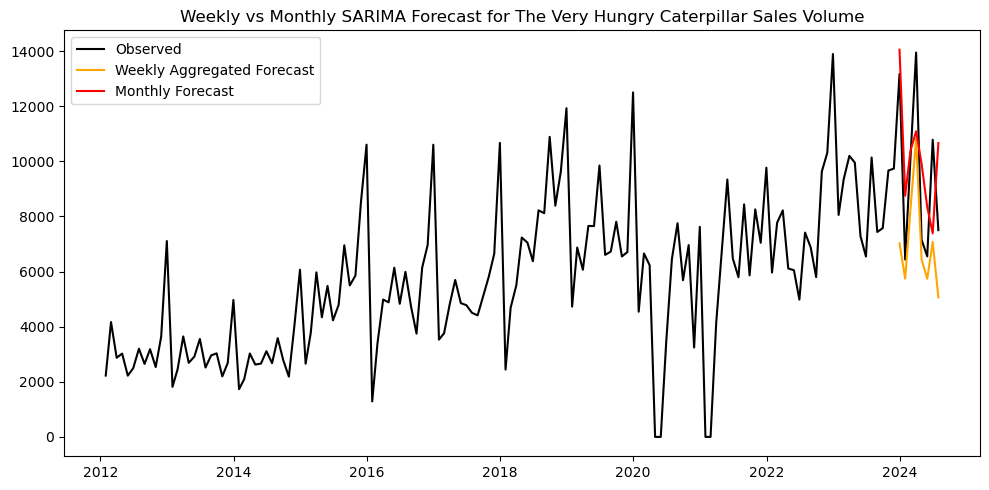

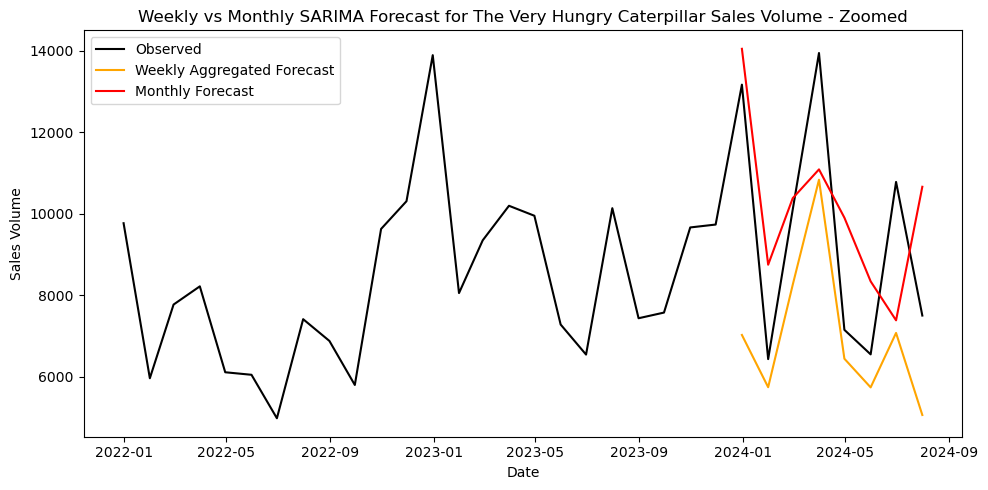

Model      MAE  MAPE (%)
0  SARIMA Weekly (Aggregated)  1719.86      18.3
1     SARIMA Monthly (Direct)  2179.89      25.7

In [ ]:
# Comparison of SARIMA Models (The Very Hungry Caterpillar).
caterpillar_agg_weekly_arima_pred, caterpillar_agg_weekly_arima_mae, caterpillar_agg_weekly_arima_mape = aggregate_weekly_pred(
    caterpillar_arima_pred,
    caterpillar_test_arima,
    df_caterpillar_monthly,
    caterpillar_arima_monthly_pred,
    'SARIMA',
    'The Very Hungry Caterpillar'
    )

caterpillar_arima_comparison = pd.DataFrame({
    'Model': ['SARIMA Weekly (Aggregated)', 'SARIMA Monthly (Direct)'],
    'MAE': [caterpillar_agg_weekly_arima_mae, caterpillar_arima_monthly_mae],
    'MAPE (%)': [caterpillar_agg_weekly_arima_mape, caterpillar_arima_monthly_mape]
}).round({'MAE': 2, 'MAPE (%)': 1})

display(caterpillar_arima_comparison)

- The SARIMA weekly model outperforms the monthly model (MAPE= 18.3% vs 25.7%) in terms of accuracy.
- The plot shows the monthly model (red) overshoots right after the holiday spike and lags at turning points, while the aggregated weekly forecast (orange) tracks the firection much better, although still damps peak amplitude.

### **10.2.3 XGBoost Comparison**

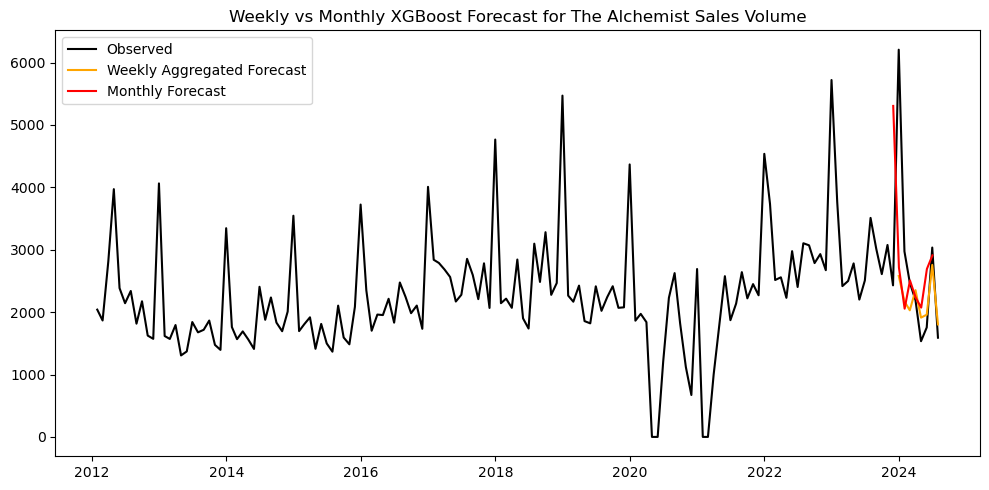

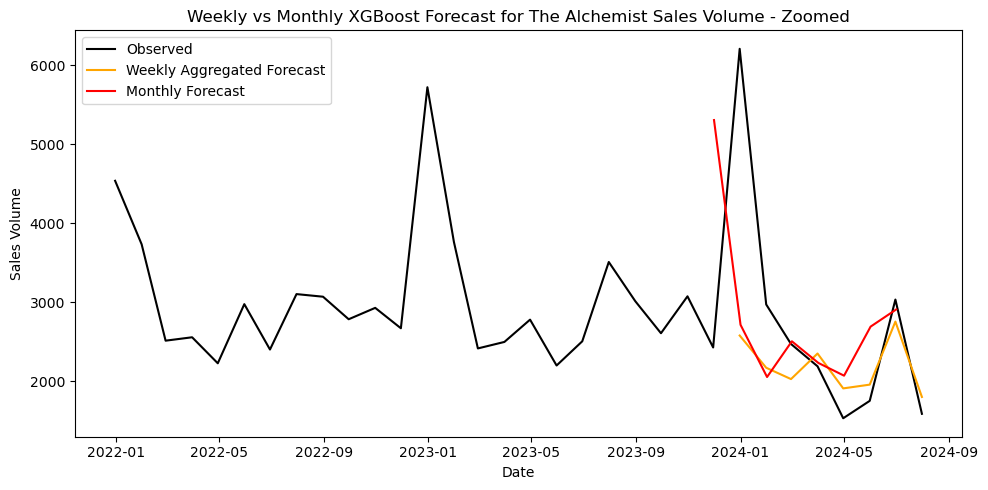

Model     MAE  MAPE (%)
0  XGBoost Weekly (Aggregated)  551.38      19.2
1     XGBoost Monthly (Direct)  571.57      26.6

In [ ]:
# Comparison of XGBoost Models (The Alchemist).
alcemist_agg_weekly_xgb_pred, alchemist_agg_weekly_xgb_mae, alchemist_agg_weekly_xgb_mape = aggregate_weekly_pred(
    alchemist_xgb_pred,
    alchemist_test_xgb,
    df_alchemist_monthly,
    alchemist_xgb_monthly_pred,
    'XGBoost',
    'The Alchemist'
    )

alchemist_xgb_comparison = pd.DataFrame({
    'Model': ['XGBoost Weekly (Aggregated)', 'XGBoost Monthly (Direct)'],
    'MAE': [alchemist_agg_weekly_xgb_mae, alchemist_xgb_monthly_mae],
    'MAPE (%)': [alchemist_agg_weekly_xgb_mape, alchemist_xgb_monthly_mape]
}).round({'MAE': 2, 'MAPE (%)': 1})

display(alchemist_xgb_comparison)

- The XGBoost weekly model outperforms the monthly model (MAPE= 19.2% vs 26.6%) in terms of accuracy.
- The plot shows the monthly model (red) overshoots right after the big holiday spike and stays biased while the weekly model tracks the changes much better.

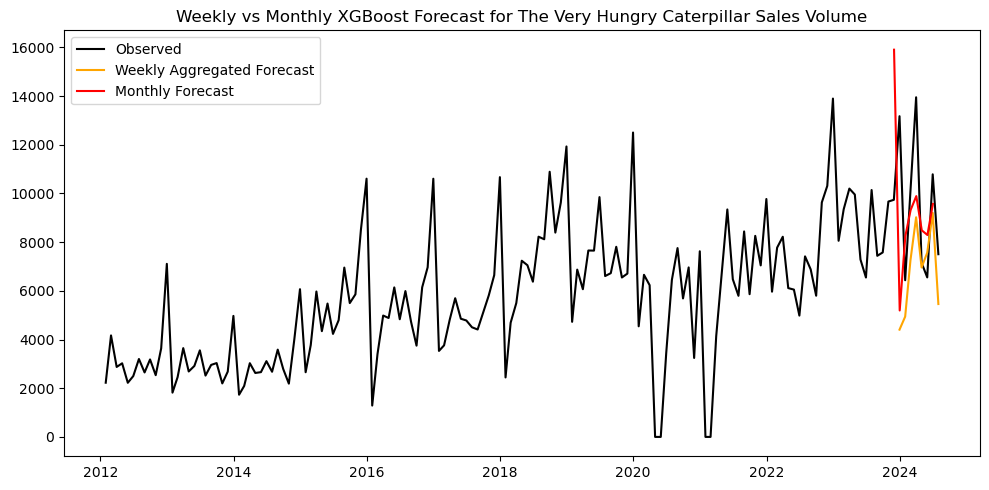

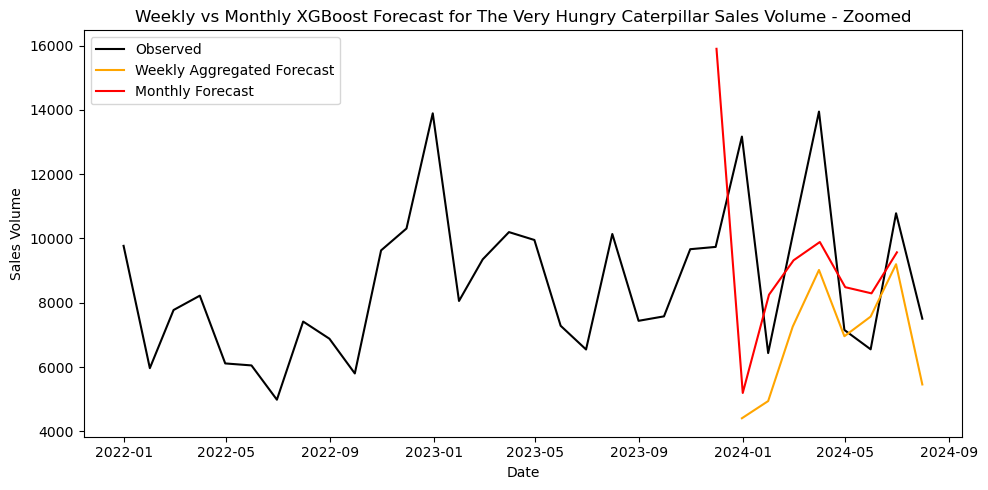

Model      MAE  MAPE (%)
0  XGBoost Weekly (Aggregated)  2147.92      23.5
1     XGBoost Monthly (Direct)  2460.50      26.2

In [ ]:
# Comparison of XGBoost Models (The Very Hungry Caterpillar).
caterpillar_agg_weekly_xgb_pred, caterpillar_agg_weekly_xgb_mae, caterpillar_agg_weekly_xgb_mape = aggregate_weekly_pred(
    caterpillar_xgb_pred,
    caterpillar_test_xgb,
    df_caterpillar_monthly,
    caterpillar_xgb_monthly_pred,
    'XGBoost',
    'The Very Hungry Caterpillar'
    )

caterpillar_xgb_comparison = pd.DataFrame({
    'Model': ['XGBoost Weekly (Aggregated)', 'XGBoost Monthly (Direct)'],
    'MAE': [caterpillar_agg_weekly_xgb_mae, caterpillar_xgb_monthly_mae],
    'MAPE (%)': [caterpillar_agg_weekly_xgb_mape, caterpillar_xgb_monthly_mape]
}).round({'MAE': 2, 'MAPE (%)': 1})

display(caterpillar_xgb_comparison)

- The XGBoost weekly model outperforms the monthly model (MAPE= 23.52% vs 26.2%) in terms of accuracy, although to a lesser degree than the previous SARIMA models.
- The plot shows the monthly model (red) is unstable around the post-holiday period whole the weekly model (orange) tracks the direction much better but has a tendancy to under-predict.

# **11. Conclusions**

- For 'The Alchemist', the sequential SARIMA + LSTM model gave the best results (MAE = 134.29, MAPE= 19.8%)
- For 'The Very Hungry Caterpillar, the parallel SARIMA + LSTM model gave the best results (MAE= 504.46, MAPE= 22.0%)
- Direct monthly modelling underperformed weekly modelling in all cases suggesting that training models on weekly data and then aggregating the prediction if needed gives better results.
- ML and DL models in isolation all underperformed the SARIMA benchmark model where they appeared to capture the general trend but missed seasonal/ event driven spikes
- Future work to improve these models could be to include more calendar information as lag features and to add exogeneous regressors to improve predictions.